## python import

In [ ]:
import yfinance as yf  # Yahoo Finance 的 API，用於下載股票數據
import numpy as np  # 用於數學運算
import pandas as pd  # 用於數據處理
from datetime import timedelta ,date ,datetime  # 用於處理日期和時間
import matplotlib.pyplot as plt  # 用於繪製圖表

In [ ]:
%pip install git+https://github.com/jcrichard/pyrb
%pip install empyrical

  Cloning https://github.com/jcrichard/pyrb to /tmp/pip-req-build-pbm9g50z
  Running command git clone --filter=blob:none --quiet https://github.com/jcrichard/pyrb /tmp/pip-req-build-pbm9g50z
  Resolved https://github.com/jcrichard/pyrb to commit 250054efe02ce48cd1ae1ef72f8d808951af5a53
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for pyrb: filename=pyrb-1.0.1-py3-none-any.whl size=10093 sha256=e9c996a6bf37d1ceccf6fd1c2b4d0e997e41b86c7e86e5432b531b87a81e3ffa
  Stored in directory: /tmp/pip-ephem-wheel-cache-f0kj_kxr/wheels/94/4d/41/c3b52414ed8ab6e4b71a6bcd4637f9049b4854605909e08d37
Successfully built pyrb
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 692.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39754 sha256=f691e38ce3bceb65e73b93461f226d02873f28d495095249933a422bc9cda696
  Stored in di

In [ ]:
import pyrb
from pyrb import EqualRiskContribution ,ConstrainedRiskBudgeting ,RiskBudgeting

In [ ]:
!pip install mosek

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 30.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive') # Here, you need to log in with your Google account.
os.environ["MOSEKLM_LICENSE_FILE"] = "/content/gdrive/MyDrive/mosek" # Specify the license path

Mounted at /content/gdrive


In [ ]:
import mosek
import cvxpy as cp
import scipy
from itertools import product
import empyrical
import quantstats as qs
import seaborn as sns

In [ ]:
!pip install QuantStats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 725.3 kB/s eta 0:00:00


In [ ]:
import quantstats as qs

## Stocks class and some codes

In [ ]:
class Stocks():
  def __init__(self, arg_stocks_list=[], arg_begin='2015-01-01', arg_end='2023-10-01'):
    """
    Initialize the Stocks class.

    Parameters:
    - arg_stocks_list: List of stock symbols.
      For example:
        ['2330.TW','2337.TW','2357.TW','2454.TW','3231.TW','3443.TW'] or
        ['TSM','AAPL','GOOG','MSFT','AMZN','GOOGL']
    - arg_begin: Start date for the stock data.
    - arg_end: End date for the stock data.

    Returns:
    - None: This function doesn't return anything but initializes the class instance.
    """
    self.stocks_list = arg_stocks_list  # List of stock symbols
    self.stocks_list.sort()

    self.start_date = arg_begin  # Start date
    self.end_date = arg_end  # End date

    self.N = len(self.stocks_list)  # Number of stocks

    self.data = None
    self.set_data()
    self.data.plot()  # Plot the stock data

    self.M = len(self.data)  # The number of rows in the data

    self.rtns = None
    self.set_rtns()
    self.rtns_cumprod()

    self.expected_rtns = None
    self.correlation_matrix = None
    self.std_dev = None
    self.covariance_matrix = None
    self.set_basic_elements(self.rtns)

  def set_data(self):
    """
    This function downloads stock data for a list of stocks and stores it in a DataFrame.

    Parameters:
    - self: The instance of the class where the function is called.

    Returns:
    - None: The function modifies the 'data' attribute of the 'self' object, it does not return anything.
    """
    self.data = pd.DataFrame()  # Initialize an empty DataFrame to store data
    # Iterate over each stock in the list of stocks
    for stock in self.stocks_list:
      # Download the stock data using the yfinance library
      df = yf.download(stock, start=self.start_date, end=self.end_date)
      # Select only the adjusted closing price from the downloaded data
      df = df[['Adj Close']]
      # Rename the column to the stock symbol for clarity
      df = df.rename(columns = {'Adj Close': stock})
      # Check if the main DataFrame is empty
      if self.data.empty:
        # If it is, assign the downloaded data to the main DataFrame
        self.data = df
      else:
        # If it's not, concatenate the downloaded data to the main DataFrame
        self.data = pd.concat([self.data, df], axis=1)
      # Print the stock symbol to indicate the progress
      print(stock)
    # The function does not return anything as it modifies the 'data' attribute in-place
    return
  def set_rtns(self):
    """
    Calculate the DataFrame of daily returns for each stock.

    Parameters:
    - self: the instance of the class.

    Returns:
    - None: this function doesn't return anything but updates the rtns attribute of the class instance.
    """
    self.rtns = pd.DataFrame()
    for stock in self.stocks_list:
      self.rtns[stock] = self.data[stock].pct_change() + 1
    self.rtns.fillna(1, inplace=True)
    return
  def rtns_cumprod(self):
    """
    Plot the cumulative product of returns.

    Parameters:
    - self: the instance of the class.

    Returns:
    - None: this function doesn't return anything but plots the rtns_cumprod attribute of the class.
    """
    self.rtns.cumprod(axis = 0).plot()
    return

  def set_expected_rtns(self,arg_rtns):
    """
    Calculate the expected returns.

    Parameters:
    - self: the instance of the class.
    - arg_rtns: DataFrame of returns.

    Returns:
    - None: this function doesn't return anything but updates the expected_rtns attribute of the class instance.
    """
    self.expected_rtns = arg_rtns.mean()
    return
  def set_correlation(self,arg_rtns):
    """
    Calculate the correlation matrix.

    Parameters:
    - self: the instance of the class.
    - arg_rtns: DataFrame of returns.

    Returns:
    - None: this function doesn't return anything but updates the correlation_matrix attribute of the class instance.
    """
    self.correlation_matrix = np.corrcoef(arg_rtns,None,False)
    return
  def set_std_dev(self,arg_rtns):
    """
    Calculate the standard deviation.

    Parameters:
    - self: the instance of the class.
    - arg_rtns: DataFrame of returns.

    Returns:
    - None: this function doesn't return anything but updates the std_dev attribute of the class instance.
    """
    self.std_dev = np.std(arg_rtns)
    return
  def set_cov(self):
    """
    Calculate the covariance matrix.

    Parameters:
    - self: the instance of the class.

    Returns:
    - None: this function doesn't return anything but updates the covariance_matrix attribute of the class instance.
    """
    self.covariance_matrix = np.zeros([self.N,self.N])
    for i in range(self.N):
      for j in range(self.N):
        self.covariance_matrix[i][j]=self.correlation_matrix[i][j]*self.std_dev[i]*self.std_dev[j]
    return
  def set_basic_elements(self,arg_rtns):
    """
    Calculate the basic elements.

    Parameters:
    - self: the instance of the class.
    - arg_rtns: DataFrame of returns.

    Returns:
    - None: this function doesn't return anything but updates the expected_rtns, correlation_matrix, std_dev, and covariance_matrix attributes of the class instance.
    """
    self.set_expected_rtns(arg_rtns)
    self.set_correlation(arg_rtns)
    self.set_std_dev(arg_rtns)
    self.set_cov()
    return

In [ ]:
# Get return
def get_return(stock_arr, start, end):
    """
    Retrieve the daily returns of stocks.

    Parameters:
    - stock_arr: List of stock tickers.
    - start: Start date for data retrieval.
    - end: End date for data retrieval.

    Returns:
    - returns: DataFrame of daily returns for each stock.
    """
    n = len(stock_arr)
    stocks = yf.download(stock_arr, start=start, end=end)

    # Calculate the daily returns
    returns = stocks['Adj Close'].pct_change()
    returns = returns.fillna(0)

    return returns


In [ ]:
# Get sharp_ratio
def sharp_ratio(stoke_return,risk_free=0.043):
  """
    Calculate the sharp ratio.

    Parameters:
    - stoke_return: DataFrame of stock return.
    - risk_free: risk_free rate

    Returns:
    - returns: DataFrame of daily returns for each stock.
    """
  pct_return=stoke_return.pct_change()
  return (pct_return.mean()-risk_free/365)/pct_return.std()

In [ ]:
def print_SR_sr(arg_result):
  # arg_result=backtesting_start_end(day_equal,weight_equal,n)
  # pct_return=arg_result.loc[:,"strategy_cum_return"]
  sr=empyrical.sharpe_ratio(arg_result.iloc[:,-1].pct_change())
  SR=sharp_ratio(arg_result.iloc[:,-1],0)
  print(SR*252**0.5,sr)
  # print(arg_result.iloc[:,-1].pct_change())
  return

In [ ]:
def list_cov(returns_train, n, interval=7, cov_days=30):
    """
    Computes the covariance matrix for the training data.

    Parameters:
    - returns_train: DataFrame, historical returns of stocks for training.
    - n: int, number of stocks.
    - interval: int, interval for selecting data.
    - cov_days: int, number of days for covariance calculation.

    Returns:
    List of covariance matrices.
    """
    cov = []
    for i in range(len(returns_train) - cov_days - 1, 1, -interval):
        cov.append((returns_train.iloc[-1 - i - cov_days:-1 - i, 0:n]).cov())
    return cov

In [ ]:
def list_mu(returns_train, n, interval=7, cov_days=30):
    """
    Computes the covariance matrix for the training data.

    Parameters:
    - returns_train: DataFrame, historical returns of stocks for training.
    - n: int, number of stocks.
    - interval: int, interval for selecting data.
    - cov_days: int, number of days for covariance calculation.

    Returns:
    List of covariance matrices.
    """
    mu = []
    for i in range(len(returns_train) - cov_days - 1, 1, -interval):
        mu.append((returns_train.iloc[-1 - i - cov_days:-1 - i, 0:n]).mean(axis=0))
    return mu

In [ ]:
def retrieve_pass_day(returns_test, n, cov_days=30):
    """
    Retrieve the days that have passed.

    Parameters:
    - returns_test: DataFrame, historical returns of stocks for testing.
    - n: int, number of stocks.
    - cov_days: int, number of days for covariance calculation.

    Returns:
    DataFrame with Retrieving the days that have passed.
    """
    pass_day = 0
    returns_test["pass_day"] = {}
    for i in range(len(returns_test) - cov_days - 1, 1, -1):
        returns_test.iloc[-1 - i, n] = int(pass_day)
        pass_day += 1
    returns_test = returns_test.dropna()
    returns_test.pop("pass_day")
    return returns_test

In [ ]:
def backtesting_start_end(returns_train_pass, strategy_weight, n):
    """
    Performs backtesting for the training data.

    Parameters:
    - returns_train_pass: DataFrame, historical returns of stocks.
    - strategy_weight: list, strategy weights.
    - n: int, number of stocks.

    Returns:
    DataFrame with cumulative returns.
    """
    TAX_RATE = 0.001425 + 0.003 / 2
    returns_pct = returns_train_pass.copy()
    strategy_cum_return = [1]
    for i in range(1, len(returns_pct)):
        total_value = strategy_cum_return[i - 1] * (
                    1 + strategy_weight[i - 1].dot(np.array(returns_pct.iloc[i, 0:n]).reshape([n, 1])))
        delta = np.linalg.norm(
            (total_value * strategy_weight[i] - strategy_cum_return[i - 1] * strategy_weight[i - 1]), ord=1) / 2
        total_value -= delta * TAX_RATE
        strategy_cum_return.append(float(total_value))
    returns_pct["strategy_cum_return"] = strategy_cum_return
    return returns_pct

## Risk Contribution of Portfolio Assets
### Motivation
First, we introduce a well-known portfolio optimization model called Markowitz's Mean-Variance Portfolio. \\

The central idea behind it is the concept of diversification to manage risk. \\
The goal is to
$$\underset{\textbf{w}} {\max} \textbf{w}^Tμ - λ\textbf{w}^TΣ\textbf{w} \\ \text{s.t.} \space 1^T\textbf{w} = 1$$

where $\textbf{w}^Tμ$ is the expected return of the portfolio and $\textbf{w}^TΣ\textbf{w}$ is the expected variance i.e. the risk of the portfolio. \\
Thus the optimization is to maximize the return and reduce risks within limits ( depend on the trade-off parameter $λ$ ) in the meantime. \\

The biggest problem of Markowitz's Portfolio is that it did not exercise control over individual risks. \\
Although our optimization is successful to reduce the risk overall, it does nothing on risk diversification. \\
This may be a problem since it permits excessive concentration of weight in those outstanding-performing assets. \\
When these assets actually encounter issues, the losses will far exceed imagination (e.g., the 2008 financial crisis).

Focusing on how individual risks being allocated is the central idea of risk parity portfolio, which is also what we aim to introduce in this topic.






### Profit and Loss of the Portfolio
The total profit or loss of the portfolio ($\Pi$) is calculated as the sum of the profits or losses of each asset in the portfolio:
$$\Pi = \sum_{i=1}^n \Pi_i, \quad $$

### Risk-Adjusted Performance Measure
The risk-adjusted performance measure ($RAPM$) is a measure used to examine the performance of an investment portfolio by adjusting for the risk involved.  
It's calculated as the expected return of the portfolio divided by the risk of the portfolio.  
The same measure can be calculated for an individual asset in the portfolio, considering the risk of the asset given the portfolio:

$$RAPM(\Pi) := \frac{\mathbb{E}[\Pi]}{\mathcal{R}(\Pi)}$$
$$ \quad RAPM(\Pi_i|\Pi) := \frac{\mathbb{E}[\Pi_i]}{\mathcal{R}(\Pi_i|\Pi)}$$

Here, $\mathcal{R}(*)$ is a coherent risk measure.  
- Following Artzner et al. (1999), $\mathcal{R}$ is said to be '**coherent**' if it satisfies the following properties:  
  1. **Subadditivity**:  
  $\mathcal{R} (x_1 + x_2) \leq \mathcal{R} (x_1) + \mathcal{R} (x_2)$  
  The risk of two portfolios should be less than the sum of the risks of the two separate portfolios.  
  2. **Homogeneity**:  
  $\mathcal{R} (\lambda x) = \lambda \mathcal{R} (x)$ if $\lambda \geq 0$.  
  Leveraging or deleveraging the portfolio increases or decreases the risk measure in the same magnitude.  
  3. **Monotonicity**:  
  If $x_1 \prec x_2$, then $\mathcal{R} (x_1) \geq \mathcal{R} (x_2)$.  
  If portfolio x2 has a better return than portfolio x1 under all scenarios, risk measure $\mathcal{R}(x_1)$ should be higher than risk measure $\mathcal{R}(x_2)$.  
  4. **Translation Invariance**:  
  If $m \in \mathbb{R}$, then $\mathcal{R} (x + m) = \mathcal{R} (x) - m$  
  Adding a cash position of amount $m$ to the portfolio reduces the risk by $m$.


### **Theorem**
The risk of an individual asset given the portfolio ($\mathcal{R}(\Pi_i|\Pi)$) can be calculated as follows:

$$\mathcal{R}(\Pi_i|\Pi)=\frac{d}{dh}\mathcal{R}(h\Pi_i+\Pi)|_{h=0}$$

This holds if the following conditions are met:

1.  Full allocation property:  
The total risk of the portfolio is the sum of the risks of each asset given the portfolio.
 $$\mathcal{R}(\Pi) = \sum_{i=1}^n \mathcal{R}(\Pi_i|\Pi)$$
2. $RAPM$ compatibility:  
There exists a positive $\epsilon_i$ such that if the risk-adjusted performance measure of an asset given the portfolio is greater than the risk-adjusted performance measure of the portfolio,  
then increasing the weight of the asset in the portfolio will increase the risk-adjusted performance measure of the portfolio.  
i.e
$$\exists \epsilon_i > 0$$ such that $$RAPM(\Pi_i|\Pi) > RAPM(\Pi) \Rightarrow RAPM(\Pi + h\Pi_i) > RAPM(\Pi) \quad \forall \ 0 < h < \epsilon_i$$

## **Risk Contribution**
The risk contribution of asset $i$ ($\mathcal{RC}_i(\textbf{w})$) is the contribution of an individual asset to the overall risk of the portfolio.  
It's calculated as the weight of the asset times the partial derivative of the risk with respect to the weight of the asset.   
The sum of the risk contributions of all assets equals the total risk of the portfolio, satisfying the Euler allocation principle.

Consider a portfolio with $N$ assets, a mean vector $\mu \in \mathbb{R}^N$, and a covariance matrix $\Sigma \in \mathbb{R}^{N \times N}$. The portfolio is represented by $\textbf{w} \in \mathbb{R}^N$. \\
If the risk measurements $f(\textbf{w})$ are well defined, then the "risk contribution" can be quantified.

### **Theorem** (Euler's Theorem)

If $f:\mathbb{R}^N \longrightarrow \mathbb{R}$ is a continuously differentiable function and a positively homogeneous function of degree one  
i.e. $$f(c\textbf{w})=cf(\textbf{w}) \forall c>0$$
Then Euler's theorem can be expressed as:

$$f(\textbf{w})=\sum_{i=1}^N w_i\frac{\partial f}{\partial w_i} \tag{1}$$

Here, $w_i\frac{\partial f}{\partial w_i}$ can be regarded as the risk contribution from asset $i$ to the total risk $f(\textbf{w})$.
  

## Proof  
The risk contribution of asset $i$, denoted as $\mathcal{RC}_i(\textbf{w})$, does satisfy Euler's theorem(1):  

i.e.  
$$\mathcal{R}(\textbf{w}) = \sum_{i=1}^n w_i\frac{\partial \mathcal{R}(\textbf{w})}{\partial w_i} = \sum_{i=1}^n \mathcal{RC}_i$$

**Proof Start:**  
Let's define a function $g(t)$ as follows:

$$g(t) = \mathcal{R}(t\textbf{w})$$

Here, $\mathcal{R}(*)$ is a coherent risk measure and thus homogeneous of degree 1.  
$$\mathcal{R}(t\textbf{w}) = t\mathcal{R}(\textbf{w})$$

The derivative of $g(t)$ with respect to $t$ is:

$$g'(t) = \frac{\mathrm{d}}{\mathrm{d}t}\mathcal{R}(t\textbf{w}) = \sum_{i=1}^n \frac{\partial \mathcal{R}(t\textbf{w})}{\partial (tw_i)} \cdot \frac{\partial (tw_i)}{\partial t} = \sum_{i=1}^n \frac{\partial \mathcal{R}(t\textbf{w})}{\partial (tw_i)} w_i$$

Also, the derivative of $g(t)$ with respect to $t$ can be written as:

$$g'(t) = \frac{\mathrm{d}}{\mathrm{d}t}t\mathcal{R}(\textbf{w}) = \mathcal{R}(\textbf{w})$$

Therefore, we have:

$$\Rightarrow g'(t) = \mathcal{R}(\textbf{w}) = \sum_{i=1}^n \frac{\partial \mathcal{R}(t\textbf{w})}{\partial (tw_i)} w_i$$

Taking $t=1$, we get:

$$\Rightarrow \mathcal{R}(\textbf{w}) = \sum_{i=1}^n \frac{\partial \mathcal{R}(\textbf{w})}{\partial w_i} w_i = \sum_{i=1}^n \mathcal{RC}_i$$

$\blacksquare$

## **Risk Budgeting Portfolio**
A Risk Parity Portfolio is a portfolio such that each asset has the same risk contribution.  
Given the risk measure $\mathcal{R}(\textbf{w})$, it satisfies:

$$\mathcal{RC}_i(\textbf{w})=w_i\frac{\partial \mathcal{R}(\textbf{w})}{\partial w_i}=w_j\frac{\partial \mathcal{R}(\textbf{w})}{\partial w_j}\ \  \forall i,j $$

A Risk Budgeting Portfolio is a more general concept.  
The goal is to control the risk allocation of the portfolio.  
Given a budget vector $\textbf{b}=[b_1, ... , b_N]^T>0$ , and $\textbf{b}^T\textbf{1}=1$,  
where budget $\textbf{b}$ is interpreted as a predetermined percentage risk contribution target for all the assets,  
it satisfies:

$$\mathcal{RC}_i(\textbf{w})=w_i\frac{\partial \mathcal{R}(\textbf{w})}{\partial w_i}=b_i\mathcal{R}(\textbf{w})\ \  \forall i $$

Obviously, the Risk Parity portfolio is a special case of the Risk Budgeting portfolio with $b_i = \frac{\textbf{1}}{N}\ \  \forall i $.

### Relative Risk Contribution

Relative risk contribution is a concept used in portfolio theory and risk management.  
It refers to the proportion of the total risk that each asset contributes to a portfolio.

In a portfolio with multiple assets, each asset contributes to the overall risk of the portfolio.  
The relative risk contribution of each asset is calculated by dividing the risk contribution of each asset by the total risk of the portfolio.  
Relative risk contribution( $\mathcal{RRC}$ ) can be written as:
$$\mathcal{RRC}_i(\textbf{w})= \frac{\mathcal{RC}_i(\textbf{w})}{\mathcal{R}(\textbf{w})} $$

Then in the Risk Budgeting Portfolio:
$$\mathcal{RRC}_i(\textbf{w})= b_i$$


### Non-linear System

We consider the following non-linear system:

- The risk contribution of each asset $i$ in the portfolio, denoted as $\mathcal{RC}_i(\textbf{w})$, is equal to the product of the relative risk contribution $b_i$ and the total risk of the portfolio $\mathcal{R}(\textbf{w})$.
- The sum of the weights of all assets in the portfolio equals 1, and each weight is non-negative.

This can be written as:

$$\begin{cases}
\mathcal{RC}_i(\textbf{w})=b_i\mathcal{R}(\textbf{w}) \\
\sum_{i=1}^Nw_i=1 ,\hspace{5mm} w_i\ge0
\end{cases}
$$

### Optimization Problem

Using the Lagrange method, the above system can be transformed into the following optimization problem:

- Minimize the total risk of the portfolio $\mathcal{R}(\mathcal{y})$.
- Subject to the constraint that the sum of the product of the relative risk contribution $b_i$ and the natural logarithm of the weight of each asset $\mathcal{y}_i$ is greater than or equal to an arbitrary constant $c$, and each weight is non-negative.

This can be written as:

$$
\Longleftrightarrow \underset{y}{\min}\mathcal{R}(\mathcal{y}) \ \text{s.t.}
\begin{cases}
\sum_{i=1}^Nb_iln(\mathcal{y}_i)\ge c \\
\mathcal{y}\ge0
\end{cases}
$$

where $c$ is an arbitrary constant.

We can understand this equivalence by considering the Karush-Kuhn-Tucker ([KKT](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions)) conditions, which are similar to the Lagrange method.  
First, we define a Lagrangian function $\Phi(y,\lambda,\lambda_c)$:

$$
\Phi(y,\lambda,\lambda_c) = \mathcal{R}(y) - λ^T(y-0)- \lambda_c(\sum_{i=1}^n b_i\ln{y_i}-c)
$$

Next, we set the gradient of this function to zero, which gives us:

$$
\frac{∂}{∂y_i}\Phi(y,\lambda,\lambda_c) = 0 \Rightarrow \frac{∂}{∂y_i} \mathcal{R}(y) = \lambda_i + λ_c\frac{∂}{∂y_i} (\sum_{i=1}^n b_i\ln{y_i}-c)
$$

By KKT conditions, we also have the equation:

$$λ_iy_i = 0$$

which leads to $λ_i = 0$ provided by $ln \space{y_i}$ is not defined for $y_i = 0 ⇒y_i > 0$

Further simplifying, we get:

$$
\Rightarrow \frac{\partial \mathcal{R}(y)}{\partial y_i} = \frac{\partial (\lambda_c\sum_{i=1}^n b_i\ln{y_i}-c)}{\partial y_i} = \lambda_c \frac{b_i}{y_i} \ \forall i
$$

This implies that:

$$
\Rightarrow {y_i}\frac{\partial \mathcal{R}(y)}{\partial y_i} = \mathcal{RC}_i = \lambda_c {b_i} \Rightarrow \frac{\mathcal{RC}_i}{\mathcal{RC}_j} = \frac{b_i}{b_j}
$$

Finally, we can obtain the optimal $y_i^*$​, and then get $w_i$​ through normalization:

$$
w_i = \frac{y_i^*}{\sum_{i=1}^n y_i^*}
$$

Such that
$$
\sum_{i=1}^n w_i = 1
$$

### Solution

The solution to the optimization problem depends on the values of the relative risk contributions $b_i$ and the correlation coefficients $\rho_{i,j}$.

1. If $b_i > 0$ for all $i$, then a solution exists and is unique.
2. If $b_i \ge 0$ for all $i$, then there may be several solutions.
3. If $\rho_{i,j} \ge 0$ for all $i$ and $j$, then the solution is unique.



### Overview of Risk Budgets in Different Portfolios

There are several types of portfolios, each with its own method of allocating risk budgets. \\
Here are a few examples:

1. **Equal Risk Contribution (ERC) Portfolio**: \\
This type of portfolio is designed so that each asset contributes equally to the overall risk. \\
In other words, the risk budget for each asset, denoted as
$$b=\frac{1}{N}$$
where $N$ is the total number of assets in the portfolio.

2. **Marginal Contribution to Risk (MCR) Portfolio**: \\
In this portfolio, the risk budgets are allocated in proportion to the product of the weight of the asset and its volatility. \\
This can be represented as
$$b_i \propto w_i \sigma_i$$
where $b_i$ is the risk budget for asset $i$, $w_i$ is the weight of asset $i$, and $\sigma_i$ is the volatility of asset $i$.

3. **Minimum Variance Portfolio**: \\
For this portfolio, the risk budget for each asset is equal to the weight of the asset. \\
This is expressed as
$$b_i = w_i$$
where $b_i$ is the risk budget for asset $i$ and $w_i$ is the weight of asset $i$.

Each of these portfolios offers a unique approach to risk management

### Optimal Solution
Consider the utility function $u(\textbf{w}) = \textbf{w}^T \mu - \frac{\phi}{2}\mathcal{R}(\textbf{w})^2$.  
The optimal solution is obtained when the derivative of the utility function with respect to the weights is zero.  
This can be written as:

$$\Leftrightarrow \partial_{\textbf{w}}u(\textbf{w})=0$$
$$\Leftrightarrow\mu = \phi \mathcal{R}(\textbf{w})\frac{\partial\mathcal{R}(\textbf{w})}{\partial\textbf{w}}$$

### Performance Contribution

The performance contribution of each asset $i$ in the portfolio, denoted as $\mathcal{PC}_i$, is equal to the product of the weight of the asset $\mathcal{w}_i$ and its expected return $\mu_i$.  
This can be written as:

$$\mathcal{PC}_i = w_i\mu_i= \phi\mathcal{R}(\textbf{w})\mathcal{RC}_i\propto b_i$$

This implies that the performance contribution of each asset is proportional to its relative risk contribution.

### Consideration of Different Portfolios

We consider three types of portfolios:

1. **Weight Balanced (WB)**:  
In this portfolio, the ratio of the weight of each asset $i$ to its relative risk contribution $b_i$ is the same for all assets.  
This can be written as:
$$\frac{w_i}{b_i}=\frac{w_j}{b_j}$$

2. **Marginal Balanced (MB)**:  
In this portfolio, the partial derivative of the total risk of the portfolio with respect to the weight of each asset is the same for all assets.  
This can be written as:
$$\partial_i\mathcal{R}(\textbf{w})=\partial_j\mathcal{R}(\textbf{w})$$

3. **Risk Budgeting (RB)**:  
In this portfolio, the ratio of the risk contribution of each asset $i$ to its relative risk contribution $b_i$ is the same for all assets.  
This can be written as:
$$\frac{\mathcal{RC}_i}{b_i}=\frac{\mathcal{RC}_j}{b_j}$$

### Risk Comparison
The total risk of the MB portfolio is less than or equal to the total risk of the RB portfolio, which in turn is less than or equal to the total risk of the WB portfolio.  
This can be written as:

$$\mathcal{R}_{MB} \le \mathcal{R}_{RB} \le \mathcal{R}_{WB}$$

**Proof:**  
Consider the previous optimization:

$$\underset{y} {\min} R(y) \ \text{s.t.} \
\begin{cases}
    \sum_{i=1}^n b_i\ln{y_i} \geq c \\
    y \geq 0
\end{cases}$$

Then these three cases can be viewed as optimization with different $c$.

- $R_{MB}: c = -\infty$ since it equals to $\underset{y} {\min} R(y) \ \text{s.t.} \ y \geq 0$
- $R_{WB}: c = \sum_{i=1}^n b_i\ln b_i$
- $R_{RB}: c \in (-\infty, \sum_{i=1}^n b_i\ln b_i]$

With the smaller $c$ meaning the more loose condition, implying the optimization $R(y^*) = \underset{y} {\min} R(y)$ would be smaller.

Thus $$c_{MB} < c_{RB} < c_{WB} \Rightarrow \mathcal{R}_{MB} < \mathcal{R}_{RB} < \mathcal{R}_{WB}$$  
$\blacksquare$  
In particular, the total risk of the Minimum Variance (MV) portfolio is less than or equal to the total risk of the Equal Risk Contribution (ERC) portfolio, which in turn is less than or equal to the total risk of the Equal Weight (EW) portfolio, is a key insight:

$$\sigma_{MV} \le \sigma_{ERC} \le \sigma_{EW}$$

This insight can be very useful in portfolio management and risk assessment.

### Stability

A stable portfolio leads to low turnover and transaction costs. This is an important consideration in portfolio management.


## Variance and Standard Deviation in Portfolio Theory

In portfolio theory, we often use standard deviation as measures of risk.  

$$\mathcal{R}(\textbf{w}) = \sigma(\textbf{w})$$

Here, we will discuss the relationship with Euler's theorem.

### Variance
The variance of a portfolio, denoted as $\sigma^2(\textbf{w})$, is calculated as $\textbf{w}^T\Sigma\textbf{w}$, where $\textbf{w}$ is the vector of portfolio weights and $\Sigma$ is the covariance matrix of the returns.  
However, this measure does not satisfy Euler's theorem.

### Standard Deviation
On the other hand, the standard deviation of a portfolio, denoted as $\sigma(\textbf{w})$, is calculated as $\sqrt{\textbf{w}^T\Sigma\textbf{w}}$.  
Interestingly, this measure does satisfy Euler's theorem.  
**Proof:**

$$
\begin{matrix}
\sum_{i=1}^N w_i\frac{\partial \sigma}{\partial w_i}&=&\sum_{i=1}^N w_i (\frac{\Sigma\textbf{w}}{\sqrt{\textbf{w}^T\Sigma\textbf{w}}}) \\
 &=&\frac{1}{\sqrt{\textbf{w}^T\Sigma\textbf{w}}}\sum_{i=1}^N w_i (\Sigma\textbf{w})_i \\
 &=& \frac{1}{\sqrt{\textbf{w}^T\Sigma\textbf{w}}}\textbf{w}^T\Sigma\textbf{w}\\
 &=&\sigma(\textbf{w})
\end{matrix}
$$

$\blacksquare$  

Therefore, we often take volatility (standard deviation) as the risk measure in portfolio theory:

$$\mathcal{R}(\textbf{w}) = \sigma(\textbf{w}) = \sqrt{\textbf{w}^T\Sigma \textbf{w}}$$

then

$$\mathcal{RC}_i(\textbf{w})= w_i\frac{\partial \mathcal{R}(\textbf{w})}{\partial w_i} = \frac{w_i(\Sigma \textbf{w})_i}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}$$


We can then formulate the Risk Parity (RP) and Risk Budgeting (RB) as follows:

$$
\begin{matrix}
RP: &\frac{w_i(\Sigma \textbf{w})_i}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}&=&\frac{w_j(\Sigma \textbf{w})_j}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}\\
\Rightarrow&w_i(\Sigma\textbf{w})_i&=& w_j(\Sigma\textbf{w})_j\\
RB: &\frac{w_i(\Sigma \textbf{w})_i}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}&=&b_i\sqrt{\textbf{w}^T\Sigma \textbf{w}}\\
\Rightarrow&w_i(\Sigma\textbf{w})_i&=& b_i\textbf{w}^T\Sigma\textbf{w}
\end{matrix}
$$

The formula for the Relative Risk Contribution( $\mathcal{RRC}$ ) of the $i$-th asset is given by:

$$\mathcal{RRC}_i(\textbf{w})= \frac{\mathcal{RC}_i(\textbf{w})}{\mathcal{R}(\textbf{w})} = \frac{w_i(\Sigma \textbf{w})_i}{\textbf{w}^T\Sigma \textbf{w}}$$

## Optimization problems

The goal is to solve the following equation for Relative Risk Contribution:

$$\mathcal{RRC}_i(\textbf{w})= \frac{w_i(\Sigma \textbf{w})_i}{\textbf{w}^T\Sigma \textbf{w}}=b_i\ \  \forall i $$

The feasible set is denoted as:

$$\{\textbf{w}|\textbf{w}^T\textbf{1}:=1\}\cap W$$

Here, the constraints are $\textbf{w}^T\textbf{1}=1$ and $W$ is a convex set.

### **Solution**

Let's define:

$$x_i=\frac{w_i}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}} \Rightarrow (\Sigma \textbf{w})_i=\frac{b_i}{x_i} \ \  \forall i $$

We solve for $x$, then normalize:

$$w_i=\frac{x_i}{\sum_{k=1}^nx_k}\ \ \ \  \forall i $$

If $\Sigma$ is diagonal and $W=\{\textbf{w}|\textbf{w} \ge 0\}$, the RB risk contribution of asset $i$ admits a unique solution:
$$x_i=\frac{\sqrt{b_i}}{\Sigma_{ii}}\ \  \forall i $$
i.e.
$$w_i=\frac{\frac{\sqrt{b_i}}{\Sigma_{ii}}}{\sum_{k=1}^n\frac{\sqrt{b_k}}{\Sigma_{kk}}}\ \ \ \  \forall i $$

However, if $\Sigma$ is non-diagonal or when there are additional constraints,

the closed-form solution does not exist anymore and optimization problems are constructed instead.

## **Equivalence Convex Optimization**

We aim to transpose the problem to its equivalent optimization form. \\
A function is **convex** if $\forall 0\le \lambda \le1, f(\lambda x_1+(1-\lambda )x_2) \le \lambda f(x_1)+(1-\lambda )f(x_2)$. \\
Here are some examples of equivalent **convex** optimization:

1.
$$\text{minimize } f(\textbf{w}) = \frac{1}{2}\textbf{w}^T\Sigma \textbf{w} - \textbf{b}^T\ln(\textbf{w})$$
$$\text{ subject to } w_i\geq 0$$

   The gradient of $f(\textbf{w})$ is given by $\nabla f(\textbf{w}) = \Sigma \textbf{w} -\frac{\textbf{b}}{\textbf{w}}$.

2.
$$\text{minimize } f(\textbf{w}) = \sqrt{\textbf{w}^T\Sigma \textbf{w}} - \textbf{b}^T\ln(\textbf{w})$$
$$\text{ subject to } w_i\geq 0$$

   The gradient of $f(\textbf{w})$ is given by $\nabla f(\textbf{w}) = \frac{\Sigma \textbf{w}}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}} -\frac{\textbf{b}}{\textbf{w}}$. \\
   This leads to the condition $\widetilde{\textbf{w}}=\frac{\textbf{w}}{\sqrt{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}}$ such that $\Sigma\widetilde{\textbf{w}}= \frac{\textbf{b}}{\widetilde{\textbf{w}}}$.

3.
$$\text{minimize } \textbf{b}^T\ln(\textbf{w})$$
$$\text{ subject to }\sqrt{\textbf{w}^T\Sigma \textbf{w}}\geq \sigma_0 \text{ and } w_i\geq 0$$

   The Lagrangian function is given by $L(\textbf{w};\lambda) = \textbf{b}^T\ln(\textbf{w}) - \lambda(\sigma_0-\sqrt{\textbf{w}^T\Sigma \textbf{w}})$.

   The gradient of the Lagrangian function is given by $\nabla L(\textbf{w};\lambda) = \frac{\textbf{b}}{\textbf{w}}-\lambda\frac{\Sigma \textbf{w}}{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}$. \\
   This leads to the condition $\widetilde{\textbf{w}}=\frac{\sqrt{\lambda}}{\sqrt{\sqrt{\textbf{w}^T\Sigma \textbf{w}}}}\textbf{w}$ such that $\Sigma\widetilde{\textbf{w}}= \frac{\textbf{b}}{\widetilde{\textbf{w}}}$.

**Issues:**
1. This only solves the simplest situation with a simplex constraint set ($1^{T}\textbf{w}=1, w_i\geq 0$ long only).
2. It **cannot** maximize $\textbf{w}^T\mu$ or minimize $\textbf{w}^T\Sigma w$.
3. It is **not always convex** in the general case.


## Solution for Case 1 of Equivalence Convex Optimization

There are two primary methods to solve this case:
1. The Newton Algorithm
2. The Cyclical Coordinate Descent Algorithm (CCD).

### 1. Newton Algorithm

The Newton Algorithm is particularly advantageous due to its rapid convergence, specifically, it exhibits quadratic convergence. \\
Consider the following optimization problem:

$$\text{minimize } f(\textbf{w}) = \frac{1}{2}\textbf{w}^T\Sigma \textbf{w} - \textbf{b}^T\ln(\textbf{w}) $$
$$\text{ subject to } w_i\geq 0$$

The goal is to find a vector $\textbf{w}$ such that $$\nabla f(\textbf{w}) = \Sigma \textbf{w} -\frac{\textbf{b}}{\textbf{w}}$$

The iteration in the Newton Algorithm is given by:

$$\textbf{w}^{(k+1)} = \textbf{w}^{(k)} - H^{-1}(\textbf{w}^{(k)})\nabla f(\textbf{w}^{(k)})$$

where:

$$\nabla f(\textbf{w}) = \Sigma \textbf{w} - \frac{\textbf{b}}{\textbf{w}}$$

and the Hessian matrix is defined as:

$$H(\textbf{w}) = \Sigma + \text{Diag}\left(\frac{\textbf{b}}{\textbf{w}^2}\right)$$

### 2. Cyclical Coordinate Descent Algorithm (CCD)

The Cyclical Coordinate Descent (CCD) algorithm iteratively updates each coordinate separately. \\
Given the objective function:

$$\text{minimize } f(\textbf{w}) = \frac{1}{2}\textbf{w}^T\Sigma \textbf{w} - \textbf{b}^T\ln(\textbf{w}) $$
$$ \text{ subject to } w_i\geq 0$$

The update rule for each coordinate $w_i^{(k+1)}$ is given by:

$$w_i^{(k+1)} = \text{arg min } f(w_1^{(k+1)}, ..., w_{i-1}^{(k+1)}, w_i, w_{i+1}^{(k)}, ..., w_n^{(k)})$$

We aim to minimize the individual component $f_i$ for each $w_i$ with the following form:

$$f_i = \frac{1}{2}w_i^2\sigma^2 + w_i(w_{-i}^T\boldsymbol{\Sigma}_{:,i}) - b_i\ln(w_i)$$

where $w_{-i}^T = (w_1, ..., w_{i-1}, 0, w_{i+1}, ..., w_n)$

The gradient with respect to $w_i$ is given by:

$$\nabla_i f = w_i\sigma^2 + w_{-i}^T\boldsymbol{\Sigma}_{:,i} - \frac{b_i}{w_i}$$

Solving the quadratic equation gives us:

$$w_i^{*} = \frac{-(w_{-i}^T\boldsymbol{\Sigma}_{:,i}) + \sqrt{(w_{-i}^T\boldsymbol{\Sigma}_{:,i})^2 - 4\sigma^2_ib_i}}{2\sigma^2}$$

This represents the update rule for each coordinate in the CCD algorithm.


In [ ]:
# Newton's Algorithm
def newton(w0, b, cov, max_err, max_iter=1000):
  """
  This function implements Newton's method to solve a convex optimization problem.

  Parameters:
  - w0: shape(n, 1) The initial guess for the optimization.
  - b: shape(n, 1) The vector of coefficients.
  - cov: shape(n, n) The covariance matrix.
  - max_err: The maximum error allowed for convergence.
  - max_iter: The maximum number of iterations.

  Returns:
  - w: array of Optimized vector of shape(n,1).
  """
  n = len(cov)

  # Define the objective function, its gradient, and Hessian
  f = lambda w: 0.5 * w.T.dot(cov.dot(w)) - b.T.dot(np.log(w))  # Objective function
  df = lambda w: cov.dot(w) - b / w  # Gradient of the objective function
  d2f = lambda w: cov + np.diag((b / (w ** 2)).reshape(n))  # Hessian of the objective function

  w = [w0]  # Initialize the solution
  err = 100  # Initialize the error
  i, t = 0, 0  # Initialize the iteration counters

  # Iterative optimization using Newton's method
  while err >= max_err and t < max_iter:
    if abs(w[-1][0]) > 1e4:
      # To prevent divergence, return an invalid result if w values become too large
      w.append([-1])
      return w

      # Update the solution using Newton's method
    w.append(w[i] - np.linalg.inv(d2f(w[i])).dot(df(w[i])))
    i += 1
    err = np.linalg.norm(w[i] - w[i - 1], ord=1)  # Compute the error
    t += 1

    # Ensure non-negativity of w values
    w[-1][w[-1] < 0] = 0.0001

  # Normalize the result to ensure it is a probability vector
  w = np.array(w).reshape(len(w), n)
  w = (w.T / w.sum(axis=1)).T

  return w


In [ ]:
# Cyclical Coordinate Descent Algorithm (CCD)
def CCD(w0, b, cov, max_err, max_iter=1000):
  """
  Implements the Cyclical Coordinate Descent (CCD) algorithm for solving a convex optimization problem.

  Parameters:
  - w0: ndarray of shape(n, 1). Initial guess for the optimization.
  - b: ndarray of shape(n, 1). Vector of coefficients.
  - cov: ndarray of shape(n, n). Covariance matrix.
  - max_err: float. Maximum error allowed for convergence.
  - max_iter: int. Maximum number of iterations.

  Returns:
  - w: ndarray of shape(n,1). Optimized vector.
  """
  n = len(cov)
  w = [w0]
  err = 100
  k, t = 0, 0

  # Iterative optimization using CCD
  while err >= max_err and t < max_iter:
    next_w = []

    # Update each coordinate separately
    for i in range(len(w0)):
      w_i = np.array(w[k])
      w_i[i] = 0
      next_w.append(
          (-(w_i.T @ cov[:, i]) + np.sqrt((w_i.T @ cov[:, i])**2 + 4 * cov[i, i] * b[i])) /
          (2 * cov[i, i])
          )

    # Append the updated vector to the result
    w.append(np.array(next_w).reshape(n, 1))

    # To prevent divergence, return an invalid result if w values become too large or too small
    if abs(w[-1][0]) > 1e4 or abs(w[-1][0]) < 1e-5:
      w.append([-1])
      return w

    k += 1
    err = np.abs(np.sum(w[k] - w[k - 1]))
    t += 1

  # Normalize the result to ensure it is a probability vector
  w = np.array(w).reshape(len(w), n)
  w = (w.T / np.sum(w, axis=1)).T

  return w


## Code Verification for Two Primary Methods

We are using the [pyrb](https://github.com/jcrichard/pyrb) package to verify that our code correctly calculates the weight vector $\textbf{w}$. \\
The risk measure is defined as follows:

$$\text{Risk Measure: } \mathcal{R}(w)= -\textbf{w}^T(\mu-r) + c\sqrt{\textbf{w}^T\Sigma \textbf{w}}$$

In this equation:
- $\textbf{w}$ is the portfolio weights vector
- $\mu$ is the expected returns vector
- $r$ is the risk-free rate
- $c$ is a constant representing the risk aversion coefficient
- $\Sigma$ is the covariance matrix

The goal is to minimize the risk measure, which will give us the optimal portfolio weights. \\
This is a key step in portfolio optimization. \\
The [pyrb](https://github.com/jcrichard/pyrb) package provides tools to perform this calculation. \\
We are checking our code to ensure that it correctly implements this calculation. \\

The goal is to check the results and ensure the accuracy of our calculations.

1. We have applied Equal Risk Contribution (ERC) optimization to one year's worth of data for five stocks: TSM, TSLA, AAPL, GOOG, and META.
 - **Newton Method**:
    - Number of iterations: 11
    - Resulting weights: \\
    [0.28651137, 0.20475155, 0.15832236, 0.12582536, 0.22458936]

 - **Cyclical Coordinate Descent Algorithm (CCD)**:
    - Number of iterations: 33
    - Resulting weights: \\
    [0.28651137, 0.20475155, 0.15832236, 0.12582536, 0.22458936]

 - **pyrb.EqualRiskContribution**:
    - Resulting weights: \\
    [0.28651137 0.20475155 0.15832236 0.12582536 0.22458936]
2. We have applied given risk budget to half year's worth of data for same stocks in above.
 - **Newton Method**:
    - Number of iterations: 11
    - Resulting weights: \\
    [0.30763202 0.3345829  0.14330344 0.15048812 0.06399353]

 - **Cyclical Coordinate Descent Algorithm (CCD)**:
    - Number of iterations: 32
    - Resulting weights: \\
    [0.30763202 0.3345829  0.14330344 0.15048812 0.06399353]

 - **pyrb.RiskBudgeting**:
    - Resulting weights: \\
    [0.30763202 0.33458288 0.14330345 0.15048812 0.06399353]


The results from both the Newton Method and the Cyclical Coordinate Descent Algorithm match exactly, which is a good sign. \\
This suggests that our code is working correctly and providing consistent results across different optimization methods.


In [ ]:
# Get today's date
today_date = date.today()
# List of stock symbols
stocks_1 = Stocks(['TSM', 'TSLA', 'AAPL', 'GOOG', 'META'], today_date - timedelta(days=360), today_date)
# Set initial weights
w0 = np.ones([5, 1])

print("ERC, one year")
# Set risk budget for ERC optimization
ERC_b = np.ones([5, 1])
ERC_b /= stocks_1.N
print('b^T:', ERC_b.T)
# Apply Newton method for optimization
ans_1_netwon = newton(w0, ERC_b, stocks_1.covariance_matrix, 1e-8, 1000)
print("Newton method: iterating =", len(ans_1_netwon), ', ', ans_1_netwon[-1].T)
# Apply Cyclical Coordinate Descent (CCD) for optimization
ans_1_CCD = CCD(w0, ERC_b, stocks_1.covariance_matrix, 1e-8, 1000)
print("CCD: iterating =", len(ans_1_CCD), ', ', ans_1_CCD[-1].T)
# Solve for optimal weights using Equal Risk Contribution (ERC) approach
ERC = pyrb.EqualRiskContribution(stocks_1.covariance_matrix)
ERC.solve()
optimal_weights_1 = ERC.x
print('pyrb.EqualRiskContribution:', optimal_weights_1)


print("\nGiven RB, half year")
stocks_2 = Stocks(['TSM', 'TSLA', 'AAPL', 'GOOG', 'META'], today_date - timedelta(days=180), today_date)
# Set risk budget
given_b = np.array([0.2, 0.35, 0.15, 0.25, 0.05]).reshape([5, 1])
print('b^T:', given_b.T)
# Apply Newton method for optimization
ans_2_newton = newton(w0, given_b, stocks_2.covariance_matrix, 1e-8, 1000)
print("Newton method: iterating =", len(ans_2_newton), ', ', ans_2_newton[-1].T)
# Apply Cyclical Coordinate Descent (CCD) for optimization
ans_2_CCD = CCD(w0, given_b, stocks_2.covariance_matrix, 1e-8, 1000)
print("CCD: iterating =", len(ans_2_CCD), ', ', ans_2_CCD[-1].T)
# Solve for optimal weights using given risk budget approach
RB = pyrb.RiskBudgeting(stocks_2.covariance_matrix,given_b)
RB.solve()
optimal_weights_2 = RB.x
print('pyrb.RiskBudgeting:', optimal_weights_2)

ERC, one year
[*********************100%%**********************]  5 of 5 completed
b^T: [[0.2 0.2 0.2 0.2 0.2]]
Newton method: iterating = 11 ,  [0.28651137 0.20475155 0.15832236 0.12582536 0.22458936]
CCD: iterating = 33 ,  [0.28651137 0.20475155 0.15832236 0.12582536 0.22458936]
pyrb.EqualRiskContribution: [0.28651137 0.20475155 0.15832236 0.12582536 0.22458936]

Given RB, half year
[*********************100%%**********************]  5 of 5 completed
b^T: [[0.2  0.35 0.15 0.25 0.05]]
Newton method: iterating = 11 ,  [0.30763202 0.3345829  0.14330344 0.15048812 0.06399353]
CCD: iterating = 32 ,  [0.30763202 0.3345829  0.14330344 0.15048812 0.06399353]
pyrb.RiskBudgeting: [0.30763202 0.33458288 0.14330345 0.15048812 0.06399353]


## **Roncalli's Formulation (2013) Optimization**

The risk budgeting portfolio is obtained by minimizing the risk subject to a constraint on the risk budget. \\
This can be formulated as:

$$\textbf{w}_{RB}=\text{arg min }\mathcal{R}(\textbf{w})$$
$$\text{subject to }\sum_{i=1}^Nb_iln(w_i)\geq\kappa^*$$

where $\kappa^*$ is a constant. \\
Using the Lagrange formulation, we get:

$$\textbf{w}^*(\lambda)=\text{arg min }\mathcal{R}(w)-\lambda\sum_{i=1}^Nb_iln(w_i)\tag1$$

where $\lambda$ is an arbitrary constant. \\
The risk budgeting portfolio is then given by:

$$\textbf{w}_{RB}=\frac{\textbf{w}^*(\lambda)}{1^T\textbf{w}^*(\lambda)}$$

There also are two methods to solve it.
## 1. Newton Algorithm (May be improved)

### Solving Equation (1) by the Newton Algorithm

According to Spinu (2013), equation (1) can be solved using the Newton algorithm. The iterative formula is given by:

$$\textbf{w}^{(k+1)}=\textbf{w}^{(k)}-\eta^{(k)}(\frac{\partial^2f(\textbf{w}^{(k)})}{\partial\textbf{w}\partial\textbf{w}^T})^{-1} \hspace{2mm}\frac{\partial f(\textbf{w}^{(k)})}{\partial\textbf{w}}$$

where $\eta^{(k)}\in\lbrack0,1\rbrack$ is the step size and $k$ is the iteration index. Generally, we set $\eta^{(k)}=1$.

### Computation of First and Second Derivatives

The first and second derivatives are computed using the following analytical expressions:

- The first derivative with respect to $\mathcal{w}_i$ is given by:

$$\frac{\partial f(\textbf{w})}{\partial w_i}=\frac{\mathcal{RC}_i(\textbf{w})}{w_i}-\lambda\frac{b_i}{w_i}$$

- The second derivative with respect to $w_i$ and $w_j$ is given by:

$$\frac{\partial^2 f(\textbf{w})}{\partial w_i\partial w_j}=\frac{c}{\sigma(\textbf{w})}(\Sigma_{i,j}-\frac{(\Sigma\textbf{w})_i(\Sigma\textbf{w})_j}{\sigma^2(\textbf{w})})$$

- The second derivative with respect to $\mathcal{w}_i$ is given by:

$$\frac{\partial^2 f(\textbf{w})}{\partial w_i^2}=\frac{c}{\sigma(\textbf{w})}(\sigma_i^2-\frac{(\Sigma\textbf{w})_i^2}{\sigma^2(\textbf{w})})+\lambda\frac{b_i}{w_i^2}$$

## 2. Cyclical Coordinate Descent Algorithm (CCD)

### The Descent Algorithm

The descent algorithm can be represented as follows:

$$\textbf{w}^{(k+1)}=\textbf{w}^{(k)}+\Delta\textbf{w}^{(k)}=\textbf{w}^{(k)}-\eta D^{(k)}$$

### The Coordinate Descent Algorithm

The coordinate descent algorithm can be represented as follows:

$$w_i^{(k+1)}=w_i^{(k)}+\Delta w_i^{(k)}=w_i^{(k)}-\eta D_i^{(k)}$$

There are two approaches concerning the choice of the variable $i$:

- Random Coordinate Descent or RCD (Nesterov, 2012)
- Cyclical Coordinate Descent or CCD (Tseng, 2001)

### The CCD Algorithm

The CCD algorithm can be represented as follows:

$$w_i^{(k+1)}=\text{arg min }f(w_1^{(k+1)} ,...,w_{i-1}^{(k+1)},w_i,w_{i+1}^{(k+1)},...,w_N^{(k+1)})$$

According to Griveau-Billion et al. (2013), equation (1) can be solved by the CCD algorithm as follows:

$$w_i=\frac{-c(\sigma_i\sum_{j\neq i}
w_j\rho_{i,j}\sigma_j)+(\mu_i-r)\sigma(\textbf{w})+\sqrt{(c(\sigma_i\sum_{j\neq i}
w_j\rho_{i,j}\sigma_j)-(\mu_i-r)\sigma(\textbf{w}))^2+4\lambda cb_i\sigma_i^2\sigma\textbf{w})}}{2c\sigma_i^2}$$

This can be simplified by setting $\lambda=1$.



In [ ]:
# Roncalli's Formulation of Newton's method
def Roncallis_Formulation_newton(arg_w0, arg_b, arg_stocks, tol, max_iter=1000, arg_c=1, arg_r=[48763], arg_ld=1):
  """
  This function implements the Roncalli's Formulation of Newton's method for portfolio optimization.

  Parameters:
  - arg_w0 (n*1 float array): Initial weights of the stocks.
  - arg_b (n*1 float array): The budget constraint for the portfolio.
  - arg_stocks (object): The stocks object containing expected returns and covariance matrix.
  - tol (float): The tolerance level for the error.
  - max_iter (int): The maximum number of iterations (default is 1000).
  - arg_c (float): The risk aversion parameter (default is 1).
  - arg_r (n*1 float array): The expected return of the stocks (default is the expected return of the stocks).
  - arg_ld (float): The Lagrange multiplier for the budget constraint (default is 1).

  Returns:
  - w: The optimized weights of the stocks.
  """
  w = arg_w0
  next_w = arg_w0
  error = 1
  c = arg_c
  r = arg_stocks.expected_rtns if arg_r == [48763] else arg_r
  ld = arg_ld

  for i in range(max_iter):
    w = next_w
    if error < tol:
      break

    RC = np.zeros(arg_stocks.N)
    sigma = (w.T.dot(arg_stocks.covariance_matrix.dot(w)))**0.5
    for j in range(arg_stocks.N):
      RC[j] = w[j]*(-(arg_stocks.expected_rtns-r)[j]+c*(arg_stocks.covariance_matrix.dot(w)[j])/sigma)

    df = np.array([RC[j]/w[j]-ld*(arg_b[j]/w[j]) for j in range(arg_stocks.N)])

    ddf = np.zeros([arg_stocks.N,arg_stocks.N])
    sigma = (w.T.dot(arg_stocks.covariance_matrix.dot(w)))**0.5
    for j in range(arg_stocks.N):
      for k in range(arg_stocks.N):
        if k == j:
          ddf[j][k] = (c/sigma)*(arg_stocks.std_dev[j]-(arg_stocks.covariance_matrix.dot(w)[j]/sigma))*(arg_stocks.std_dev[j]+(arg_stocks.covariance_matrix.dot(w)[j]/sigma)) + (ld/w[j])*(arg_b[j]/w[j])
        else:
          ddf[j][k] = (c/sigma)*(arg_stocks.covariance_matrix[j][k]-(arg_stocks.covariance_matrix.dot(w)[j]/sigma)*(arg_stocks.covariance_matrix.dot(w)[k]/sigma))

    next_w = w - np.linalg.inv(ddf).dot(df)
    error = abs(sum(next_w - w))

  for i in range(arg_stocks.N):
    if w[i] < 0:
      w[i] = 1e-8
  return pd.DataFrame({'weight':(w/np.sum(w)).T[0]},arg_stocks.stocks_list)

In [ ]:
# Roncalli's Formulation of Cyclical Coordinate Descent Algorithm (CCD)
def Roncallis_Formulation_ccd(arg_w0, arg_b, arg_stocks, tol, max_iter=1000, arg_c=1, arg_r=[48763], arg_ld=1):
  """
  This function applies the Coordinate Descent (CCD) algorithm to find the optimal portfolio weights.

  Parameters:
  - arg_w0 (n*1 float array): Initial weights of the stocks.
  - arg_b (n*1 float array): The budget constraint for the portfolio.
  - arg_stocks (object): The stocks object containing expected returns and covariance matrix.
  - tol (float): The tolerance level for the error.
  - max_iter (int): The maximum number of iterations (default is 1000).
  - arg_c (float): The risk aversion parameter (default is 1).
  - arg_r (n*1 float array): The expected return of the stocks (default is the expected return of the stocks).
  - arg_ld (float): The Lagrange multiplier for the budget constraint (default is 1).

  Returns:
  - A DataFrame with the optimal portfolio weights for each stock.
  """
  w = arg_w0
  next_w = arg_w0
  error = 1
  c = arg_c
  r = arg_stocks.expected_rtns if arg_r == [48763] else arg_r
  ld = arg_ld
  iter=0
  for k in range(max_iter):
    w=next_w
    if error < tol:
      break
    temp_weights=np.zeros(arg_stocks.N)
    for i in range(arg_stocks.N):
      sigma=(w.T.dot(arg_stocks.covariance_matrix.dot(w)))**0.5
      wps=0
      for j in range(arg_stocks.N):
        wps+=w[j]*arg_stocks.correlation_matrix[i][j]*arg_stocks.std_dev[j] if j!=i else 0
      first_term = -c*(arg_stocks.std_dev[i]*wps)
      denominator = 2 * c * arg_stocks.std_dev[i]**2
      second_term = (arg_stocks.expected_rtns - r)[i] * sigma
      third_term = ((-first_term - (arg_stocks.expected_rtns - r)[i] * sigma)**2 + 2 * ld  * arg_b[i] * denominator * sigma)**0.5
      temp_weights[i]=first_term/denominator+ second_term/denominator+ third_term/denominator
    next_w = temp_weights
    error = abs(sum(w.T[0] - next_w))
    iter+=1
    if iter > max_iter:
      break
  return pd.DataFrame({'weight':next_w/np.sum(next_w)},arg_stocks.stocks_list)

## Code Verification
We are using the [pyrb](https://github.com/jcrichard/pyrb) package to verify that our code correctly calculates the weight vector $\textbf{w}$. \\
We have applied given risk budget [0.30, 0.20, 0.15, 0.15, 0.20] to one year's worth of data for five stocks: AAPL, GOOG, META, TSLA, and TSM.
 - **Newton Method**:
    - Resulting weights: \\
    [0.39583  0.186678  0.10944  0.097235  0.210817]

 - **Cyclical Coordinate Descent Algorithm (CCD)**:
    - Resulting weights: \\
    [0.39583  0.186678  0.10944  0.097235  0.210817]

 - **pyrb.RiskBudgeting**:
    - Resulting weights: \\
    [0.39583036 0.18667767 0.10944041 0.0972349  0.21081667]


The results from both the Newton Method and the Cyclical Coordinate Descent Algorithm match exactly, which is a good sign. \\
This suggests that our code is working correctly and providing consistent results across different optimization methods.

In [ ]:
# Get today's date
today_date = date.today()
# List of stock symbols
stocks = Stocks(['TSM', 'TSLA', 'AAPL', 'GOOG', 'META'], today_date - timedelta(days=365), today_date)
# Set initial weights
w0 = np.ones([5, 1])

print("\nGiven RB, one year")
# Set risk budget
given_b = np.array([0.30, 0.20, 0.15, 0.15, 0.20]).reshape([5, 1])
print('b^T:', given_b.T)
# Apply Newton method for optimization
ans_newton = Roncallis_Formulation_newton(w0, given_b, stocks, 1e-5)
print("Newton method: ", ans_newton.T)
# Apply Cyclical Coordinate Descent (CCD) for optimization
ans_ccd = Roncallis_Formulation_ccd(w0, given_b, stocks, 1e-5)
print("CCD: ", ans_ccd.T)
# Solve for optimal weights using given risk budget approach
RB = pyrb.RiskBudgeting(stocks.covariance_matrix,given_b)
RB.solve()
optimal_weights = RB.x
print('pyrb.RiskBudgeting:', optimal_weights)



Given RB, one year
b^T: [[0.3  0.2  0.15 0.15 0.2 ]]
Newton method:             AAPL      GOOG     META      TSLA       TSM
weight  0.39583  0.186678  0.10944  0.097235  0.210817
CCD:             AAPL      GOOG     META      TSLA       TSM
weight  0.39583  0.186678  0.10944  0.097235  0.210817
pyrb.RiskBudgeting: [0.39583036 0.18667767 0.10944041 0.0972349  0.21081667]


## **Nonconvex Optimization**

Previously, we introduced the constraints of convex optimization.

When seeking to find the risk parity portfolio via optimization, we suggest penalizing the summation of squared differences among risk contributions:

$$
\begin{matrix}
\underset{\textbf{w}} {\text{minimize}} &\sum_{i,j=1}^N(w_i(\Sigma\textbf{w})_i-w_j(\Sigma\textbf{w})_j)^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

This objective can be simplified to:

$$
\begin{matrix}
\underset{\textbf{w},\theta} {\text{minimize}} &\sum_{i=1}^N(w_i(\Sigma\textbf{w})_i-\theta)^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

To find a portfolio that aligns as closely as possible with the risk budgeting targets $\textbf{b}$, we solve:

$$
\begin{matrix}
\underset{\textbf{w}} {\text{minimize}} &\sum_{i=1}^N(\frac{w_i(\Sigma\textbf{w})_i}{\textbf{w}^T\Sigma\textbf{w}}-b_i)^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

There are also other alternative (though different) problem formulations. For example:

$$
\begin{matrix}
\underset{\textbf{w}} {\text{minimize}} &\sum_{i,j=1}^N(\frac{w_i(\Sigma\textbf{w})_i}{b_i}-\frac{w_j(\Sigma\textbf{w})_j}{b_j})^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

and

$$
\begin{matrix}
\underset{\textbf{w}} {\text{minimize}} &\sum_{i=1}^N(w_i(\Sigma\textbf{w})_i-b_i\textbf{w}^T\Sigma\textbf{w})^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

and

$$
\begin{matrix}
\underset{\textbf{w}} {\text{minimize}} &\sum_{i=1}^N(\frac{w_i(\Sigma\textbf{w})_i}{\sqrt{\textbf{w}^T\Sigma\textbf{w}}}-b_i\sqrt{\textbf{w}^T\Sigma\textbf{w}})^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

and

$$
\begin{matrix}
\underset{\textbf{w},\theta} {\text{minimize}} &\sum_{i=1}^N(\frac{w_i(\Sigma\textbf{w})_i}{b_i}-\theta)^2 \\
\text{subject to} &\textbf{w}^T\textbf{1}=1, &\textbf{w}\in W
\end{matrix}
$$

However, **all** the above formulations are **nonconvex**, and there are many more specific formulations.

In the next part, we'll introduce a powerful algorithm called Successive Convex Approximation (SCA).

## **Successive Convex Approximation (SCA)**

The **goal** of SCA is to minimize the function
$$U(\textbf{w}) = \sum_{i=1}^N g_i(\textbf{w})^2+\lambda  F(\textbf{w})$$
subject to the constraints $\textbf{w} \in W$.

**Where:**
- $\sum_{i=1}^N g_i(\textbf{w})^2 = R(\textbf{w})$ represents the risk concentration measurement. \\
For example, $g_i(\textbf{w}) = \frac{w_i{(\Sigma\textbf{w})}_i}{{\textbf{w}^T\Sigma\textbf{w}}}-\frac{1}{N}$.
- $F(\textbf{w})$ is a convex function that represents some traditional preferences on the portfolio. \\
Examples include $0,-\mu^T\textbf{w},-\mu^T\textbf{w}+c \space \textbf{w}^T\Sigma\textbf{w}$.
- $\lambda \ge 0$ is a trade-off parameter.
- $\textbf{w} \in W$ represents the capital budget ($1^T\textbf{w} = 1$) and other convex constraints.

The **idea** behind SCA is that nonconvex problems are difficult to solve, \\
so we solve a sequence of simpler problems (convex optimization):
1. Find a good enough approximation $\widetilde{U}(\textbf{w},\textbf{w}^{(k)})$ that approaches $U(\textbf{w})$ at $\textbf{w}^{(k)}$.
2. Iterate $\textbf{w}^{(k+1)} = \underset{\textbf{w}\in W} {\text{min}} \space \widetilde U(\textbf{w};\textbf{w}^{(k)})$.
3. Ensure $\widetilde U(\textbf{w};\textbf{w}^{(k)})$ satisfies:
   - $\widetilde U(\textbf{w};\textbf{w}^{(k)})$ is uniformly strongly convex and continuously differentiable. \\
   (A function is **strongly convex** if there exists $\alpha > 0$ such that $f(x) - α||x||^2$ is convex.) \\
   (A function is **uniformly strongly convex** if there exists a positive constant $m$ such that $f(x) - m||x||^2 $ is convex for all $x$.)
   - $\nabla\widetilde U(\textbf{w};\textbf{w}^{(k)})$ is Lipschitz continuous on $W$. \\
   (A function $f$ is **Lipschitz continuous** if there is a constant $C$ such that $|f(y) - f(x)| \le C|y - x|$.)
   - $\nabla\widetilde U(\textbf{w};\textbf{w}^{(k)}) \big |_{\textbf{w}=\textbf{w}^{(k)}} = \nabla U(\textbf{w}) \big|_{\textbf{w}=\textbf{w}^{(k)}}$.




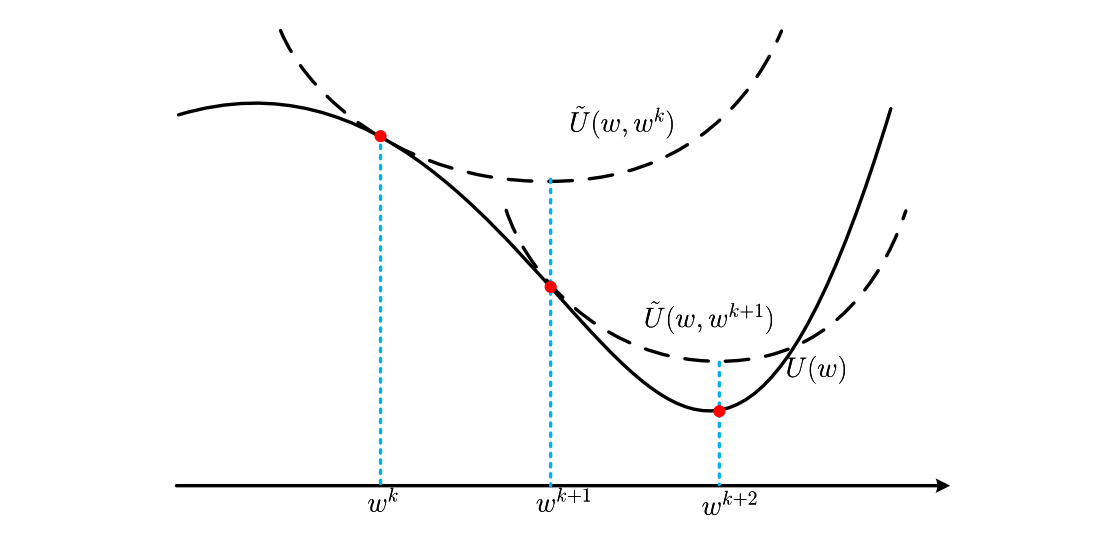

## **Successive Convex Approximation (SCA) Illustrated with the Newton Method**
**<font color='red'>Please note that as the number of assets increases, the probability of errors in this part of the algorithm also increases.</font>**

The Newton method can be utilized within the framework of Successive Convex Approximation (SCA). \\
The approximation is expressed as:

$$\widetilde U(\textbf{w},\textbf{w}^{(k)}) = U(\textbf{w}^{(k)}) + \nabla {U(\textbf{w}^{(k)})}^T(\textbf{w}-\textbf{w}^{(k)}) + \frac{1}{2\alpha^{(k)}}{(\textbf{w}-\textbf{w}^{(k)})}^T∇^2U(\textbf{w}^{(k)})(\textbf{w}-\textbf{w}^{(k)})$$  

In this context, the update rule becomes:

$$\textbf{w}^{(k+1)} = \textbf{w}^{(k)}-\alpha^{(k)}{(\nabla^2 {U(\textbf{w}^{(k)})})}^{-1}\nabla {U(\textbf{w}^{(k)})}$$

## Challenges and Potential Solutions with the Newton Method

### Challenges:
1. The computation of the Hessian matrix can be complex and may necessitate manual calculations.
2. The method does not offer a mechanism to determine the learning rate $\alpha^{(k)}$.

### Potential Solutions:
1. Finite differences can be employed to estimate the second-order derivatives. \\
The formula is as follows:

$$\frac{\partial f}{\partial w_i}(\textbf{w}^{(0)}) \approx \frac{f(\textbf{w}^{(0)}+h*e_i)-f(\textbf{w}^{(0)}-h*e_i)}{2h}$$

2. A line search can be conducted to find the optimal step size at each iteration. \\
This involves minimizing the objective function along the search direction. The goal is:

$$\underset{\alpha} {\text{min}} \space \phi(\alpha) = f(\textbf{w}^{(k)} + \alpha p^{(k)})$$
where
$$p^{(k)} = {(\nabla^2 {U(\textbf{w}^{(k)})})}^{-1}\nabla {U(\textbf{w}^{(k)})}$$

### Armijo Condition:
The Armijo condition provides a sufficient decrease condition and is given by:

$$f(\textbf{w}^{(k)}+\alpha p^{(k)}) \le f(\textbf{w}^{(k)}) + c_1\alpha (p^{(k)})^T \nabla f(\textbf{w}^{(k)}) $$
$$ 0< c_1< 1$$

### Wolfe Conditions:
The Wolfe conditions consist of the Armijo condition (sufficient decrease condition) and the curvature condition:
  1. Armijo condition:
  $$f(\textbf{w}^{(k)}+\alpha p^{(k)}) \le f(\textbf{w}^{(k)}) + c_1\alpha (p^{(k)})^T \nabla f(\textbf{w}^{(k)}) $$
  2. Curvature condition:
  $$(p^{(k)})^T \nabla f(\textbf{w}^{(k)}+\alpha p^{(k)}) \ge c_2 (p^{(k)})^T \nabla f(\textbf{w}^{(k)})$$
  $$0< c_1 < c_2< 1$$

### Quasi-Newton Method:
In situations where the Hessian is either unavailable or too costly to compute at every iteration, the Quasi-Newton method can be used. \\
In this method, the Hessian is updated by analyzing successive gradient vectors. \\
This approach forms the basis of the **Broyden-Fletcher-Goldfarb-Shanno algorithm (BFGS)**.

### Numerical differentiation for gradient and hessian matrix

In [ ]:
def objective_function(w, cov, lambda_, mu, c, n, b):
    """
    Objective function combining risk preferences and concentration constraints (U(w))

    Parameters:
    - w: shape(n, 1) weight of assets
    - cov: shape(n, n) Covariance matrix.
    - lambda_: trade-off parameter
    - mu: shape(n, 1) mean of assets
    - c: trade-off parameter with (w^T @ cov @ w)
    - n: number of assets

    Returns:
    - f: U(w)
    """
    if w.shape != (w.size,1):
      w=w.reshape([w.size, 1])
    f = (lambda_ * (-mu.T @ w + c * w.T @ cov @ w))

    # Adding risk concentration constraints
    for i in range(n):
        Mi = np.zeros([n, n])
        Mi[i, :] = cov[i, :]
        f += ((w.T @ Mi @ w) / (w.T @ cov @ w) - b[i]) ** 2

    return f


def gradient(arg_f, x0):
    """
    Define the gradient of the objective function

    Parameters:
    - arg_f: function f
    - x0: shape(n, 1) Initial guess for the optimization.

    Returns:
    - g: shape(n, 1) gradient of U(w) at w=x0
    """
    if x0.shape != (x0.size,1):
      x0=x0.reshape([x0.size,1])
    h = 1e-4
    n = x0.size
    e = np.eye(n)
    g = []

    # Numerical differentiation for each component of the gradient
    for i in range(n):
        ei = e[:, i].reshape([n, 1])
        g.append((arg_f(x0 + h * ei) - arg_f(x0 - h * ei)) / (2 * h))

    return np.array(g).reshape([n, 1])

def hessian(arg_f, x0):
    """
    Define the hessian of the objective function

    Parameters:
    - arg_f: function f
    - x0: shape(n, 1) Initial guess for the optimization.

    Returns:
    - g: shape(n, n) hessian of U(w) at w=x0
    """
    h = 1e-4
    n = x0.size
    e = np.eye(n)
    hessian = np.zeros([n, n])

    # Numerical differentiation for each component of the Hessian
    for i in range(n):
        ei = e[:, i].reshape([n, 1])
        for j in range(n):
            ej = e[:, j].reshape([n, 1])
            hessian[i, j] = (
                (arg_f(x0 + (ei + ej) * h / 2) +
                 arg_f(x0 - (ei + ej) * h / 2) -
                 arg_f(x0 + (ei - ej) * h / 2) -
                 arg_f(x0 - (ei - ej) * h / 2)) / (h ** 2))[0, 0]

    return hessian



# trash 1
def Backtracking(f,x_k,d,alpha=0.9,beta=0.5):
  k=0
  step=1

  while f(x_k+step*d) > f(x_k) + alpha*step* gradient(f, x_k).T @d:
    step*=beta
    k+=1
  print("k : ",k)
  return step


# trash 2
def step_size(f,x_k,d):

  def phi(alpha, x_k, d, f):
    x_new = x_k + alpha * d
    return f(x_new)
  result = scipy.optimize.minimize_scalar(lambda alpha: phi(alpha, x_k, d, f))
  alpha_optimal = result.x
  print("alpha : ",alpha_optimal)
  return alpha_optimal


# big trash
# Successive Convex Approximation (SCA) using Newton's Method
def SCA_newton(x0, b, cov, f, n, max_err, times=1000):
    """
    SCA_newton's method for solving a constrained optimization problem.

    Parameters:
    - x0: shape(n,1) Initial guess for the optimization.
    - b: shape(n,1) Coefficients vector.
    - cov: shape(n,n) Covariance matrix.
    - f: finction with one parameter w
    - n: number of assets
    - max_err: Maximum error allowed for convergence.
    - times: Maximum number of iterations.

    Returns:
    - x: array of Optimized vector of shape(n,1).
    """
    x = [x0]
    err = 520
    i, t = 0, 0
    # Iterative optimization using Newton's method
    while err >= max_err and t < times:
        # if abs(x[-1][0]) > 1e5:
        #     # To prevent divergence, return an invalid result if x values become too large
        #     x.append([-1])
        #     return x

        # Update x using Newton's method
        d = np.linalg.inv(hessian(f, x[i])) @ gradient(f, x[i])


        step = scipy.optimize.line_search(f,lambda w:gradient(f,w).reshape(n),x[i].reshape(n),-d.reshape(n))
        step=step[0]
        if step==None:
            step = scipy.optimize.line_search(f,lambda w:gradient(f,w).reshape(n),x[i].reshape(n),d.reshape(n))
            step=-step[0]

        x.append(x[i] - step * d)

        print(x[i])
        print(step*d)
        print(x[i+1])
        i += 1
        err = np.linalg.norm(x[i] - x[i - 1], ord=np.inf)
        t += 1

        if np.linalg.norm(gradient(f, x[i]))<max_err:
          break
        # Ensure non-negativity of x values
        # x[-1][x[-1] < 0] = 0.0001

    # Normalize the result to ensure it is a probability vector
    x = np.array(x).reshape(len(x), n)
    x = (x.T / x.sum(axis=1)).T

    return x

def Quasi_Newton(x0, b, cov, f, n, max_err, times=1000):
  b_k= np.eye(n)
  x = [x0]
  err = 520
  i, t = 0, 0
  # Iterative optimization using Newton's method
  while err >= max_err and t < times:
    d = np.linalg.inv(b_k) @ gradient(f, x[i])

    step = scipy.optimize.line_search(f,lambda w:gradient(f,w).reshape(n),x[i].reshape(n),-d.reshape(n))
    step=step[0]
    if step==None:
       step = scipy.optimize.line_search(f,lambda w:gradient(f,w).reshape(n),x[i].reshape(n),d.reshape(n))
       step=-step[0]

    s= step * d
    print("step",step)
    x.append(x[i] - s)
    y=gradient(f, x[i+1]) -gradient(f, x[i])
    b_k=b_k + (y@y.T)/(y.T@s) - (b_k@s@s.T@b_k.T)/(s.T@b_k@s)

    i += 1
    if np.linalg.norm(gradient(f, x[i]))<max_err:
      break
    # err = np.linalg.norm(x[i] - x[i - 1], ord=np.inf)
    # print(err)
    t += 1
  x = np.array(x).reshape(len(x), n)
  x = (x.T / x.sum(axis=1)).T

  return x



##The approximation method he provided are not practical
In the process of approximating the gradient and Hessian matrix, \\
we persist in utilizing the original expression $U$, rather than resorting to $\widetilde U$. \\
The approximation method that has been provided, upon application, yields differences that are not of practical significance. \\
This is primarily due to the fact that it necessitates the approximation of the Hessian matrix.

In [ ]:
# Using wave U

def wave_U(f,w,w_k,alpha):
  if w.shape != (w.size,1):
      w=w.reshape([w.size, 1])
  return f(w_k) + gradient(f,w_k).T@(w-w_k) + (w-w_k).T@hessian(f,w_k)@(w-w_k)/(2*alpha)

# big trash
# Successive Convex Approximation (SCA) using Newton's Method
def SCA_newton(x0, b, cov, f, n, max_err, times=1000):
    """
    SCA_newton's method for solving a constrained optimization problem.

    Parameters:
    - x0: shape(n,1) Initial guess for the optimization.
    - b: shape(n,1) Coefficients vector.
    - cov: shape(n,n) Covariance matrix.
    - f: finction with one parameter w
    - n: number of assets
    - max_err: Maximum error allowed for convergence.
    - times: Maximum number of iterations.

    Returns:
    - x: array of Optimized vector of shape(n,1).
    """
    x = [x0]
    err = 520
    i, t = 0, 0
    alpha = 0.5
    # Iterative optimization using Newton's method
    while err >= max_err and t < times:
        wave_f=lambda w: wave_U(f,w,x[i],alpha)
        d = np.linalg.inv(hessian(wave_f, x[i])) @ gradient(wave_f, x[i])


        step = scipy.optimize.line_search(wave_f,lambda w:gradient(wave_f,w).reshape(n),x[i].reshape(n),-d.reshape(n))
        step=step[0]
        if step==None:
            step = scipy.optimize.line_search(wave_f,lambda w:gradient(wave_f,w).reshape(n),x[i].reshape(n),d.reshape(n))
            step=-step[0]
        alpha=step
        x.append(x[i] - alpha * d)

        print("step",alpha)
        i += 1
        err = np.linalg.norm(x[i] - x[i - 1], ord=np.inf)
        t += 1

        if np.linalg.norm(gradient(wave_f, x[i]))<max_err:
          break
        # Ensure non-negativity of x values
        # x[-1][x[-1] < 0] = 0.0001

    # Normalize the result to ensure it is a probability vector
    x = np.array(x).reshape(len(x), n)
    x = (x.T / x.sum(axis=1)).T

    return x

def Quasi_Newton(x0, b, cov, f, n, max_err, times=1000):
  b_k= np.eye(n)
  x = [x0]
  err = 520
  i, t = 0, 0
  alpha = 0.1
  # Iterative optimization using Newton's method
  while err >= max_err and t < times:
    wave_f=lambda w: wave_U(f,w,x[i],alpha)
    d = np.linalg.inv(b_k) @ gradient(wave_f, x[i])

    step = scipy.optimize.line_search(wave_f,lambda w:gradient(wave_f,w).reshape(n),x[i].reshape(n),-d.reshape(n))
    step=step[0]
    if step==None:
       step = scipy.optimize.line_search(wave_f,lambda w:gradient(wave_f,w).reshape(n),x[i].reshape(n),d.reshape(n))
       step=step[0]
       if step==None:
        step=1
       else:
        step=-step
    alpha =step

    s= alpha * d
    print("step",alpha)
    x.append(x[i] - s)
    y=gradient(wave_f, x[i+1]) -gradient(wave_f, x[i])
    b_k=b_k + (y@y.T)/(y.T@s) - (b_k@s@s.T@b_k.T)/(s.T@b_k@s)

    i += 1
    if np.linalg.norm(gradient(wave_f, x[i]))<max_err:
      break
    # err = np.linalg.norm(x[i] - x[i - 1], ord=np.inf)
    # print(err)
    t += 1
  x = np.array(x).reshape(len(x), n)
  x = (x.T / x.sum(axis=1)).T

  return x

In [ ]:
from pyrb import EqualRiskContribution
# np.set_printoptions(precision=8, suppress=True)
# Get today's date
d = date.today()

# List of stock symbols
stoke = ['TSM', 'TSLA', 'AAPL', 'GOOG', 'META']
# stoke = ['TSM', 'TSLA']
stoke.sort()


# Get returns and covariance matrix
returns = get_return(stoke, d - timedelta(days=365), d)

# Set initial weights and target weights for ERC optimization
n = len(stoke)
cov = returns.cov().values
x0 = np.ones([n, 1])/n
b = np.ones([n, 1])/n
lambda_, c=0, 0
mu=returns.mean(axis=0).values.reshape([n,1])

f=lambda w: objective_function(w, cov, lambda_, mu, c, n, b )
ans=Quasi_Newton(x0, b, cov,f,n ,max_err=1e-6, times=1000)
# ans=SCA_newton(x0, b, cov,f,n ,max_err=1e-6, times=1000)
# print(ans)
print("Newton method: iterating =", len(ans), ', ', ans[-1].T)



# Solve for optimal weights using Equal Risk Contribution (ERC) approach
ERC = EqualRiskContribution(returns.cov())
ERC.solve()
optimal_weights = ERC.x
print('Comparison:', optimal_weights)
# ERC.get_volatility()



[*********************100%%**********************]  5 of 5 completed
step [[0.1474352]]
step [[0.29840412]]
step [[0.54858001]]
step -1.0
step [[0.50696894]]
step -1.0
step -1.0
step -1.0
Newton method: iterating = 9 ,  [0.2936247  0.203837   0.15745561 0.12302447 0.22205823]
Comparison: [0.29362464 0.20383703 0.15745561 0.12302448 0.22205825]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [ ]:
s=['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '1590.TW', '2002.TW', '2105.TW', '2207.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2357.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2801.TW', '2881.TW', '2882.TW', '2884.TW', '2885.TW', '2886.TW', '2887.TW', '2891.TW', '2892.TW', '2912.TW', '3008.TW', '3034.TW', '3045.TW', '3711.TW', '4904.TW', '4938.TW', '5871.TW', '5876.TW', '5880.TW', '6415.TW', '6505.TW', '8046.TW', '9910.TW', '2376.TW', '1722.TW', '2344.TW']

In [ ]:
# List of stock symbols
a = '1101110212161301130313261402159020022105220723032308231723272330235723792382239524082412245424742633280128812882288428852886288728912892291230083034304537114904493858715876588064156505666980469910237617222344'
stoke = []

# Extract stock symbols from the string 'a'
for i in range(0, len(a), 4):
    stoke.append(a[i:i + 4] + ".TW")

# Remove specific stock symbols
stoke.remove("6669.TW")
stoke.remove("2633.TW")

# Sort the list of stock symbols
stoke.sort()
# Get returns and covariance matrix
returns = get_return(stoke, d - timedelta(days=252), d)

# Set initial weights and target weights for ERC optimization
n = len(stoke)
cov = returns.cov().values
x0 = np.ones([n, 1])/n
b = np.ones([n, 1])/n
lambda_, c=0, 0
mu=returns.mean(axis=0).values.reshape([n,1])

f=lambda w: objective_function(w, cov, lambda_, mu, c, n, b )
# ans=Quasi_Newton(x0, b, cov,f,n ,max_err=1e-6, times=1000)
ans=SCA_newton(x0, b, cov,f,n ,max_err=1e-6, times=1000)
# print(ans)
print("Newton method: iterating =", len(ans), ', ', ans[-1].T)



# Solve for optimal weights using Equal Risk Contribution (ERC) approach
ERC = EqualRiskContribution(returns.cov())
ERC.solve()
optimal_weights = ERC.x
print('Comparison:', optimal_weights)
# ERC.get_volatility()

[*********************100%%**********************]  50 of 50 completed


KeyboardInterrupt: ignored

##**Alternative Method:**
We've taken the nonconvex term $R(\textbf{w})$ and convexified it by linearizing each $g_i(\textbf{w})$ within the square operation. \\
We've also added the proximal term $\lVert \textbf{w}-\textbf{w}^{(k)} \rVert_2^2$ to ensure convergence.

The function $\widetilde U(\textbf{w};\textbf{w}^{(k)})$ is defined as follows:

$$\widetilde U(\textbf{w};\textbf{w}^{(k)}) = \sum_{i=1}^n [g_i(\textbf{w}^{(k)})+\nabla g_i(\textbf{w}^{(k)})^T(\textbf{w}-\textbf{w}^{(k)})]^2+\frac{\tau}{2}\lVert \textbf{w}-\textbf{w}^{(k)} \rVert_2^2+\lambda F(\textbf{w})$$

**Key Insight:** \\
By linearizing the nonconvex functions $g_i (\textbf{w})$ inside the square, we can convert them into quadratic convex functions:

$$P(\textbf{w};\textbf{w}^{(k)}) = \sum_{i=1}^n [g_i(\textbf{w}^{(k)})+\nabla g_i(\textbf{w}^{(k)})^T(\textbf{w}-\textbf{w}^{(k)})]^2$$

This can be rewritten as:

$$P(\textbf{w};\textbf{w}^{(k)})=\lVert A^k(\textbf{w}-\textbf{w}^{(k)})+g(\textbf{w}^{(k)}) \rVert^2$$

where

$$A^{(k)} = [\nabla g_1(\textbf{w}^{(k)}), ..., \nabla g_n(\textbf{w}^{(k)})]^T$$  
$$g(\textbf{w}^{(k)}) = [g_1(\textbf{w}^{(k)}), ..., g_n(\textbf{w}^{(k)})]^T$$  

This leads to:

$$P(\textbf{w};\textbf{w}^{(k)}) = (\textbf{w}-\textbf{w}^{(k)})^T(A^{(k)})^TA^{(k)}(\textbf{w}-\textbf{w}^{(k)})+g(\textbf{w}^{(k)})^Tg(\textbf{w}^{(k)})+2g(\textbf{w}^{(k)})^TA^{(k)}(\textbf{w}-\textbf{w}^{(k)})$$  

As a result, we can minimize $U(\textbf{w})$ over $\textbf{w} \in W$:

$$\underset{\textbf{w} \in W}{\min} \space U(\textbf{w}) = \frac{1}{2}\textbf{w}^TQ^{(k)}\textbf{w} + \textbf{w}^Tq^{(k)} + \lambda F(\textbf{w})$$  

where

$$Q^{(k)} = 2(A^{(k)})^TA^{(k)} + \tau I$$  
$$q^{(k)} = 2(A^{(k)})^Tg(\textbf{w}^{(k)}) - Q^{(k)}\textbf{w}^{(k)}$$

Under these assumptions, the problem is strongly convex and can be solved using existing efficient solvers. \\
Moreover, if $F(\textbf{w})$ is linear or convex quadratic, and only contains linear constraints, the problem reduces to a Quadratic Programming (QP).

**Theorem:**  
Under certain technical conditions, suppose:

$$\tau > 0, \gamma^{(k)} \in (0,1] , \gamma^{(k)} →0,\sum_k\gamma^{(k)}=+\infty  , \sum_k(\gamma^{(k)})^2 < +\infty  $$

Let $\{\textbf{w}^{(k)}\}$ be the sequence generated by the algorithm. \\
Then, every limit point of $\{\textbf{w}^{(k)}\}$ (at least one such point exists) is a stationary point.

For instance, we can take:

$$\gamma^{(k)} = \gamma^{(k-1)}(1-\alpha * \gamma^{(k-1)})\space where \space \alpha = {10}^{-7}$$

with $\gamma^{(0)}=0.9$ and $\tau = 0.05 \frac{Tr(\Sigma)}{(2n)}$

Thus, we can iterate:

$$ \hat{\textbf{w}}^{(k)} = \underset{\textbf{w} \in W}{\min} \space U(\textbf{w};\textbf{w}^{(k)}) = \frac{1}{2}\textbf{w}^TQ^{(k)}\textbf{w} + \textbf{w}^Tq^{(k)} + \lambda F(\textbf{w})$$

$$\textbf{w}^{(k+1)} = \textbf{w}^{(k)}+\gamma^{(k)}(\hat{\textbf{w}}^{(k)} -\textbf{w}^{(k)}) $$

###For the General Case
Consider the function $g_i(\textbf{w})$ defined as follows:

$$g_i(\textbf{w}) = \frac{w_i{(\Sigma\textbf{w})}_i}{{\textbf{w}^T\Sigma\textbf{w}}}-b_i = \frac{\textbf{w}^T M_i \textbf{w}}{{\textbf{w}^T\Sigma\textbf{w}}}-b_i$$

Here, $M_i$ is a sparse matrix where the i-th row is identical to that of the covariance matrix $\Sigma$.

The gradient of $g_i(\textbf{w})$ can then be computed as:

$$\nabla g_i(\textbf{w}) =\frac{(\textbf{w}^T\Sigma \textbf{w})(M_i+M_i^T)\textbf{w}-(\textbf{w}^TM_i\textbf{w})(2\Sigma)\textbf{w}}{({\textbf{w}^T\Sigma\textbf{w}})^2}$$

This formulation allows us to handle the general case in our optimization problem. \\
The gradient computation is crucial for the iterative update in the algorithm. \\
The sparse nature of the matrix $M_i$ can potentially lead to computational efficiency.

##Solvers to solve $\hat{\textbf{w}}^{(k)}$
In this case, we utilize the [cvxpy](https://github.com/cvxpy/cvxpy) package to solve for $\hat{\textbf{w}}^{(k)}$. \\
We specifically use the [cvxpy.MOSEK](https://docs.mosek.com/latest/pythonapi/intro_info.html) solver due to its superior efficiency. \\
However, it's important to note that using this solver requires obtaining a license. \\
Alternatively, other solvers such as **cvxpy.CVXOPT** can also be used if preferred. \\
This flexibility allows for adaptability based on specific project requirements and constraints.


In [ ]:
def gradient(cov, w, i):
    Mi = np.zeros([n, n])
    Mi[i, :] = cov[i, :]
    return (((w.T @ cov @ w)*(Mi+Mi.T)@w-(w.T @ Mi @ w)*2*cov@w )/ (w.T @ cov @ w)**2 )

def g_i(w, cov, b, i, n):
    # Function to compute g_i(w)
    Mi = np.zeros([n, n])
    Mi[i, :] = cov[i, :]
    return ((w.T @ Mi @ w) / (w.T @ cov @ w) - b[i])

def g(w, cov, b, n):
    # Function to compute the vector g(w)
    g = []
    for i in range(n):
        g.append(g_i(w, cov, b, i, n))
    return np.array(g).reshape([n, 1])

def A(w, cov, b, n):
    # Function to compute the matrix A(w)
    a = []
    for i in range(n):
        # gi = lambda w: g_i(w, cov, b, i, n)
        # a.append(gradient(gi, w))
        a.append(gradient(cov, w, i))
    a = np.array(a).reshape([n, n])
    return a

def big_Q(w, cov, b, n, tau):
    # Function to compute the matrix Q(w)
    e = np.eye(n)
    a = A(w, cov, b, n)
    return 2 * a.T @ a + tau * e

def small_q(w, cov, b, n, Q):
    # Function to compute the vector q(w)
    a = A(w, cov, b, n)
    return 2 * a.T @ g(w, cov, b, n) - Q(w) @ w

def SCRIP_computation(x0, b, cov, n, lambda_, mu, tau, c, Q, q ,C, D, max_err=1e-6, times=1000):
    # Function to perform SCRIP computation


    err = 520
    x = [x0]
    t, i = 0, 0
    ONE = np.ones([1, n])

    w = cp.Variable([n, 1])
    gamma=0.9
    while err >= max_err and t < times:
        # optimize \hat{w}
        try:
          prob = cp.Problem(
              cp.Minimize((1 / 2) * cp.quad_form(w, Q(x[i])+lambda_ *c*cov) + w.T @ (q(x[i]) - lambda_ * mu) ),
              [ONE @ w == 1,
              w >= 0,
              C @ w <= D]
          )
          prob.solve(solver=cp.MOSEK) # cp.MOSEK  cp.CVXOPT

          x.append(x[i]+gamma*(w.value-x[i]))

          gamma=gamma*(1-1e-7*gamma)

          i += 1
          err = np.linalg.norm(x[i] - x[i - 1], ord=np.inf)
          t += 1

        # if tau is too small s.t. problem cannot be solved
        except:
          # print("NONO")
          tau *= 100
          Q = lambda w: big_Q(w, cov, b, n, tau)
          x = SCRIP_computation(x0, b, cov, n, lambda_, mu, tau, c, Q, q, C, D, max_err, times)
          break


    tau= 0.05*np.trace(cov)/(2*n)
    Q = lambda w: big_Q(w, cov, b, n, tau)

    return x

def SCRIP(n, mu, cov, c=0, lambda_=0, C=np.array([]), D=np.array([]), b=np.array([]), max_err=1e-6, times=1000):
    # Function to perform SCRIP optimization for a portfolio

    # some setting
    if len(C) == 0 or len(D) == 0:
        C = np.ones([1, n])
        D = np.ones([1])

    if len(b) == 0:
        b = np.ones([n, 1]) / n

    tau= 0.05*np.trace(cov)/(2*n)
    Q = lambda w: big_Q(w, cov, b, n, tau)
    q = lambda w: small_q(w, cov, b, n, Q)

    x0 = np.ones([n, 1]) / n
    ans = SCRIP_computation(x0, b, cov, n, lambda_, mu, tau, c, Q, q, C, D, max_err, times)
    return ans


## Code Verification
We have applied to 50 days' worth of data for stocks: ['TSM', 'AAPL', 'GOOG', 'MSFT', 'AMZN', 'GOOGL']
1. With ERC
 - **SCRIP**:
    - Resulting weights: \\
    [0.21212312 0.15701018 0.13949823 0.14111297 0.17517212 0.17508338]

 - **pyrb.EqualRiskContribution**:
    - Resulting weights: \\
    [0.21212462 0.15700979 0.13949753 0.14111231 0.17517231 0.17508344]
2. With CRB, \\
take C = [[0,0,0,-1.0,-1.0,-1.0],[1,0,0,1,-1,0]] and D = [-0.3,-0.05]
 - **SCRIP**:
    - Resulting weights: \\
    [0.11327094 0.17986667 0.152369   0.09934972 0.26262066 0.19252301]

 - **pyrb.ConstrainedRiskBudgeting**:
    - Resulting weights: \\
    [0.14082118 0.16001941 0.13653921 0.10183607 0.29265948 0.16812464]

In [ ]:
today_date = date.today()
# List of stock symbols
stocks = Stocks(['TSM', 'AAPL', 'GOOG', 'MSFT', 'AMZN', 'GOOGL'], today_date - timedelta(days=50), today_date)

# Call SCRIP optimization function
ans = SCRIP(stocks.N, stocks.expected_rtns, stocks.covariance_matrix, c=1, lambda_=0,  b=np.array([]), max_err=1e-6, times=100)
print("SCRIP =", len(ans), ', ', ans[-1].T)

# Solve for optimal weights using Equal Risk Contribution (ERC) approach
ERC = pyrb.EqualRiskContribution(stocks.covariance_matrix)
ERC.solve()
optimal_weights = ERC.x
print('Comparison:', optimal_weights)


/usr/local/lib/python3.10/dist-packages/pyrb/solvers.py:57: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  Sx = np.dot(cov, x)
/usr/local/lib/python3.10/dist-packages/pyrb/solvers.py:58: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  sigma_x = np.sqrt(np.dot(Sx, x))


[*********************100%%**********************]  6 of 6 completed
SCRIP = 7 ,  [[0.21212312 0.15701018 0.13949823 0.14111297 0.17517212 0.17508338]]
Comparison: [0.21212462 0.15700979 0.13949753 0.14111231 0.17517231 0.17508344]


In [ ]:
# Call SCRIP optimization function
C = np.array([[0,0,0,-1.0,-1.0,-1.0],[1,0,0,1,-1,0]])
D = np.array([-0.3,-0.05])
ans = SCRIP(n, mu, cov, c=1, lambda_=10, C=C ,D=D.reshape([len(D),1]), b=np.array([]), max_err=1e-6, times=1000)
print("SCRIP =", len(ans), ', ', ans[-1].T)
print(f"c @ x = {(C@ans[-1]).T}")

# Solve for optimal weights using Equal Risk Contribution (ERC) approach
CRB = ConstrainedRiskBudgeting(cov,C=C,d=D)
CRB.solve()
optimal_weights = CRB.x
print('Comparison:', optimal_weights)
print(CRB)

[*********************100%%**********************]  6 of 6 completed
SCRIP = 9 ,  [[0.11327094 0.17986667 0.152369   0.09934972 0.26262066 0.19252301]]
c @ x = [[-0.55449339 -0.05      ]]
Comparison: [0.14082118 0.16001941 0.13653921 0.10183607 0.29265948 0.16812464]
solver: admm_ccd
----------------------------
solution x: [14.0821 16.0019 13.6539 10.1836 29.2659 16.8125]
lambda star: 0.9698
risk contributions: [10.3786 16.3163 16.3165 12.0234 28.649  16.3161]
sigma(x): 0.9906
sum(x): 100.0
mu(x): 0.0
C@x: [-0.56262019 -0.05000223]




##General constraints

Take stocks =['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '1590.TW', '1722.TW', '2002.TW', '2105.TW', '2207.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2344.TW', '2357.TW', '2376.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2801.TW', '2881.TW', '2882.TW', '2884.TW', '2885.TW', '2886.TW', '2887.TW', '2891.TW', '2892.TW', '2912.TW', '3008.TW', '3034.TW', '3045.TW', '3711.TW', '4904.TW', '4938.TW', '5871.TW', '5876.TW', '5880.TW', '6415.TW', '6505.TW', '8046.TW', '9910.TW']

1. The strategy cumulative return

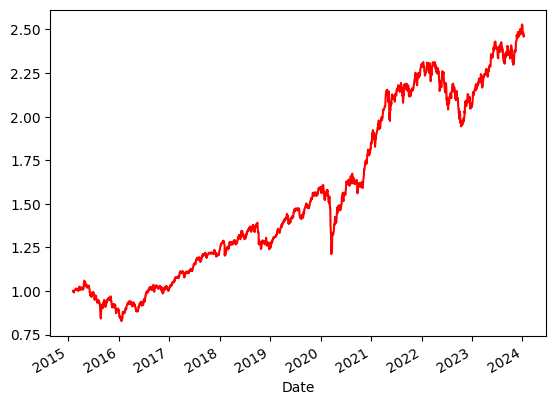

2. The weight evolution over time

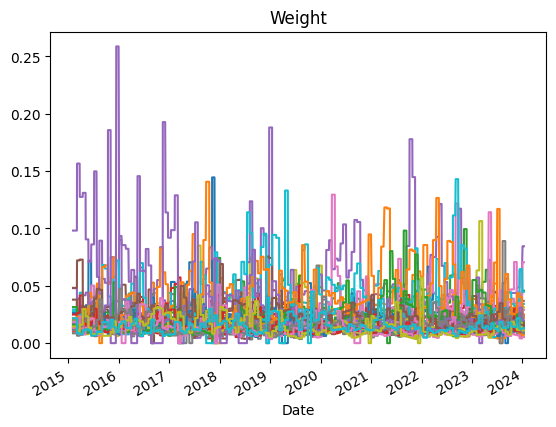


- The annualized Sharpe ratio \\
  1.044534308971257
- Sharpe ratio \\
  1.044534308971257

In [ ]:
def day_weight_start_end_SCRIP_1(returns_train_pass, n, mu, cov, interval=7, cov_days=30):
    """
    Calculates daily weights using the SCRIP for the training data.

    Parameters:
    - returns_train_pass: DataFrame, historical returns of stocks for training.
    - n: int, number of stocks.
    - cov: list, covariance matrices.
    - interval: int, interval for selecting data.
    - cov_days: int, number of days for covariance calculation.

    Returns:
    Tuple containing DataFrame with pass days and list of strategy weights.
    """
    pass_day = 0
    strategy_weight = []
    x0 = np.ones([n, 1])/n
    cov_index = 0
    for i in range(len(returns_train_pass) - 1, -1, -1):
        if pass_day % interval == 0:
            x_SCRIP = SCRIP(n, mu[cov_index].values.reshape([n, 1]), cov[cov_index].values, c=0, lambda_=0, b=np.array([]), max_err=1e-6, times=100)
            strategy_weight.append(x_SCRIP[-1].reshape([n]))
            cov_index += 1
        else:
            strategy_weight.append(strategy_weight[-1])
        pass_day += 1
    return returns_train_pass, strategy_weight


[*********************100%%**********************]  50 of 50 completed


[[ 0.2  0.8  0.7  0.4 -0.8 -0.4  0.5  0.7 -0.2  0.3  0.2  0.1 -0.1 -0.1
   0.3  0.   0.9 -0.5 -0.9  0.7  0.5  0.6  0.3 -0.9 -0.1 -0.4  0.8 -0.5
   0.7 -1.   0.3 -0.2 -0.1 -0.7 -0.2 -0.5  0.7  0.  -0.1  0.8 -1.  -0.7
   0.   0.6  0.9 -1.  -1.  -0.9 -0.5  0.6]
 [ 0.1 -0.7  0.6  0.7  0.5 -0.8  0.7 -0.6  0.5 -0.6  0.6  0.4 -0.8 -0.2
   0.9 -0.9 -0.3 -0.9 -0.2 -0.4 -0.3  0.6  0.3 -0.1 -0.7 -0.8 -0.4  0.9
   0.6  0.  -0.4 -0.7 -0.5 -0.2  0.9 -0.7  0.3  0.9 -0.6 -0.4  0.1  0.7
   0.5 -0.8 -0.8  0.5  0.4  0.  -0.1 -0.9]]
[[0.3]
 [0.9]]


<ipython-input-11-49c56a2ace1a>:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns_test["pass_day"] = {}


Text(0.5, 1.0, 'Weight')

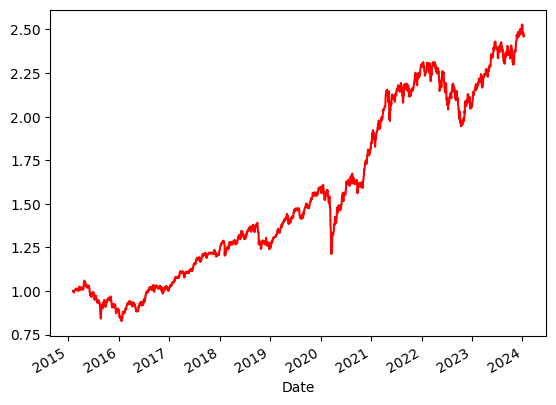

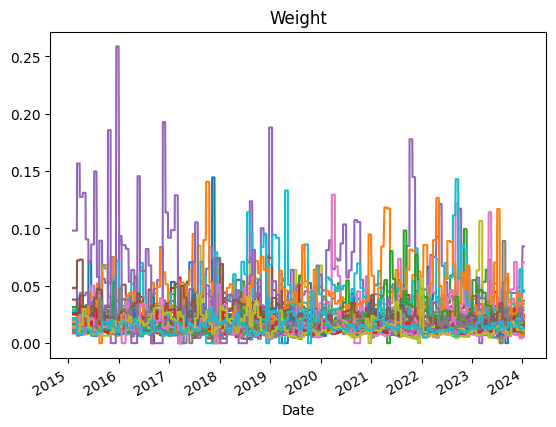

In [ ]:
# List of stock symbols
stoke =['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '1590.TW', '1722.TW', '2002.TW', '2105.TW', '2207.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2344.TW', '2357.TW', '2376.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2801.TW', '2881.TW', '2882.TW', '2884.TW', '2885.TW', '2886.TW', '2887.TW', '2891.TW', '2892.TW', '2912.TW', '3008.TW', '3034.TW', '3045.TW', '3711.TW', '4904.TW', '4938.TW', '5871.TW', '5876.TW', '5880.TW', '6415.TW', '6505.TW', '8046.TW', '9910.TW']
stoke.sort()

# Set parameters
interval = 14
cov_days = 30

# Get historical returns for the selected stocks
d = date.today()
returns_ALL = get_return(stoke, d - timedelta(days=365 * 9 + cov_days), d)

# Drop missing values in the returns
returns_ALL.dropna(inplace=True)

# Get the number of stocks
n = len(returns_ALL.columns)

# Calculate covariance matrices
mu = list_mu(returns_ALL, n, interval, cov_days)
cov = list_cov(returns_ALL, n, interval, cov_days)

# Retrieve the days that have passed for returns_ALL_pass data
returns_ALL_pass = returns_ALL.copy()
returns_ALL_pass = retrieve_pass_day(returns_ALL_pass, n, cov_days)

# Calculate day weights and perform backtesting
day, weight = day_weight_start_end_SCRIP_1(returns_ALL_pass, n, mu, cov, interval, cov_days)
result = backtesting_start_end(day, weight, n)
# Plot the strategy cumulative return
result_plot = result.strategy_cum_return.plot(color='red')
# Plot the weight evolution over time
pd_weight = pd.DataFrame(weight, columns=returns_ALL_pass.columns, index=day.index)
weight_plt = pd_weight.plot()
weight_plt.legend_ = None
weight_plt.set_title("Weight")


<ipython-input-12-2db2001ab1c0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


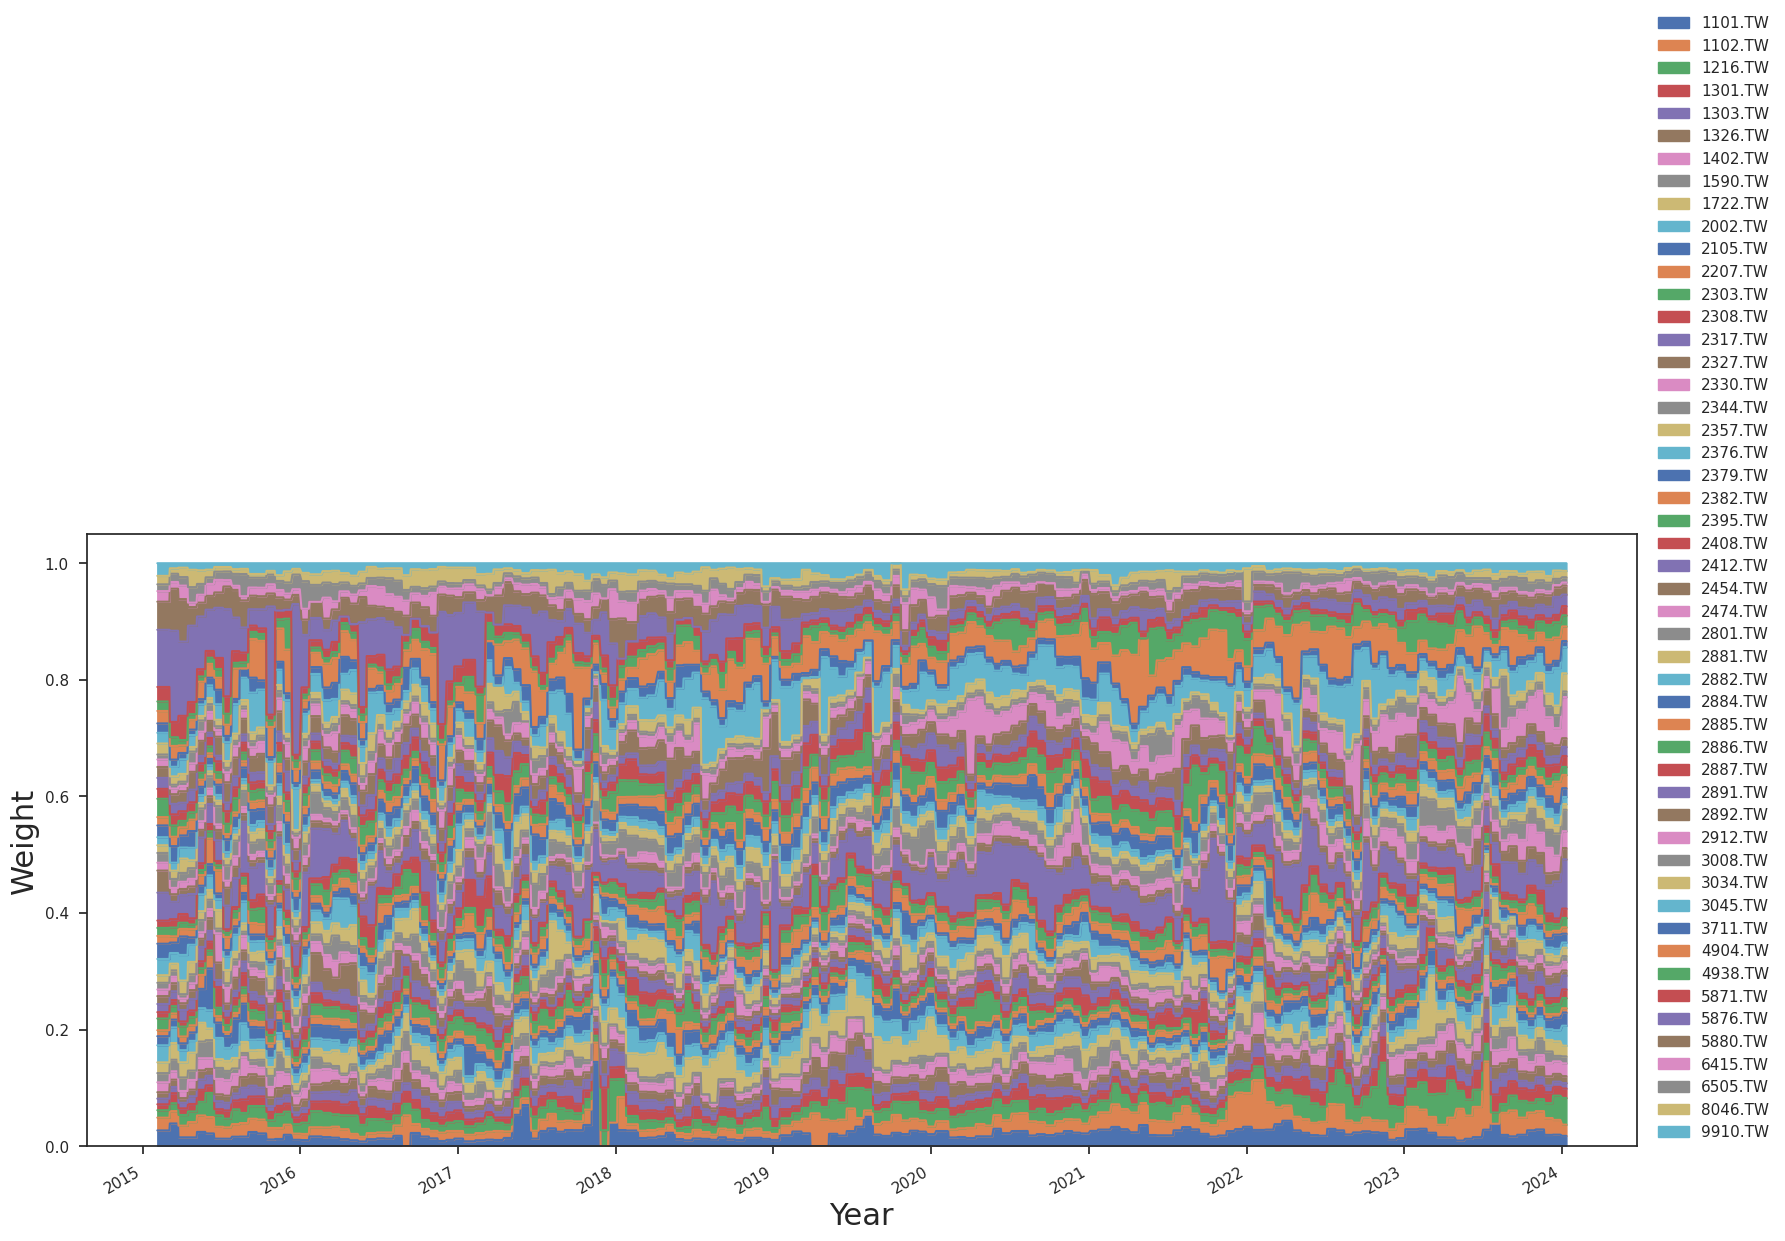

In [ ]:
plt.style.use('seaborn')
sns.set_style("white")
sns.set_theme(style = "ticks")

pd_weight.plot.area(figsize = (20,9))
plt.ylabel("Weight", fontsize = 22)
plt.xlabel("Year", fontsize = 22)
plt.legend(bbox_to_anchor=(1.01,0),loc=3,borderaxespad=0)


In [ ]:
print_SR_sr(result)

1.044534308971257 1.044534308971257


Under general constraints, it is much slower than other methods. \\
However, in cases where additional other convex constraints are introduced, \\
it is much faster than pyrb

##For Linear Equality Constraints

In particular, there's only linear equality constraints.

Problem can reduce to a Quadratic Programming (QP) with Constraint $C\textbf{w} = c$

$\hat{\textbf{w}}^{(k)} = \underset{\textbf{w} \in W}{\min} \space U(\textbf{w};\textbf{w}^{(k)})$ has the close form solution.

>while not converagence:
>
>> $\lambda^{(k)} = -(C(Q^{(k)})^{-1}C^T)^{-1}(C(Q^{(k)})^{-1}q^{(k)} + c)$
>>
>> $\hat{\textbf{w}}^{(k)} = -(Q^{(k)})^{-1}(q^{(k)} + C^T\lambda^{(k)}) $
>>
>> $\textbf{w}^{(k+1)} = \textbf{w}^{(k)} + \gamma^{(k)}(\hat{\textbf{w}}^{(k)} - \textbf{w}^{(k)})$
>>
>> $k ← k+1$
>
>end while

## For Linear Constraints

Quadratic Programming (QP) with Constraint $C\textbf{w} = c$ , $ D\textbf{w} \le d$

While we can still use the general version of the algorithm, \\
this specific method theoretically offers higher efficiency.

problem does not admit a closed-form solution. \\
One way to find an optimal solution is via the dual decomposition method.

> while not converagence:
>
> > $i=\color{red}{1}, \widetilde{\textbf{w}}^{(0)} = \textbf{w}^{(k)}, LC = \lVert B(Q^{(k)})^{-1}B^T\rVert_2$
> >
> > while not converagence:
> > >
> > > $\widetilde{\textbf{w}}^{(i)} = -(Q^{(k)})^{-1}(q^{(k)}+C^T\lambda^\color{red}{(i-1)}+D^Tμ^\color{red}{(i-1)})$
> > >
> > > $\bar{\widetilde{\textbf{w}}}^{(i)} = \widetilde{\textbf{w}}^{(i)} + \frac{i-1}{i+2} (\widetilde{\textbf{w}}^{(i)}-\widetilde{\textbf{w}}^{(i-1)})$
> > >
> > > $\lambda^\color{red}{(i)} = \lambda^\color{red}{(i-1)} + \frac{i-1}{i+2} (\lambda^\color{red}{(i-1)}-\lambda^\color{red}{(i-2)}) + \frac{1}{LC}(C\bar{\widetilde{\textbf{w}}}^{(i)}-c)$
> > >
> > > $μ^\color{red}{(i)} = [ \space μ^\color{red}{(i-1)} +  \frac{i-1}{i+2} (μ^\color{red}{(i-1)}-μ^\color{red}{(i-2)}) + \frac{1}{LC}(D\bar{\widetilde{\textbf{w}}}^{(i)}-d )\space ]^+$
> > >
> > > $i ← i+1$
> > >
> > end while ( if it converges, we don't update i )
> >
> > $\lambda^{(0)} = \lambda^{(i)}, \mu^{(0)} = \mu^{(i)}$
> >
> > $\hat{\textbf{w}}^{(k)} = \widetilde{\textbf{w}}^{(i)}$
> >
> > $\textbf{w}^{(k+1)} = \textbf{w}^{(k)} + \gamma^{(k)}(\hat{\textbf{w}}^{(k)}-\textbf{w}^{(k)})$
> >
> > $k ← k+1$
>
> end while

Note that the text in red is where I believe corrections should be made.

## **Practice**
Now that we've implemented various algorithms for calculating weights, it's time to visualize their effectiveness.

The following is the implementation using the Newton's method to solve \\
the equal risk portfolio

## Backtesting

Take six stocks ['TSM', 'AAPL', 'GOOG', 'MSFT', 'AMZN', 'GOOGL']

1. The cumulative returns of the strategy

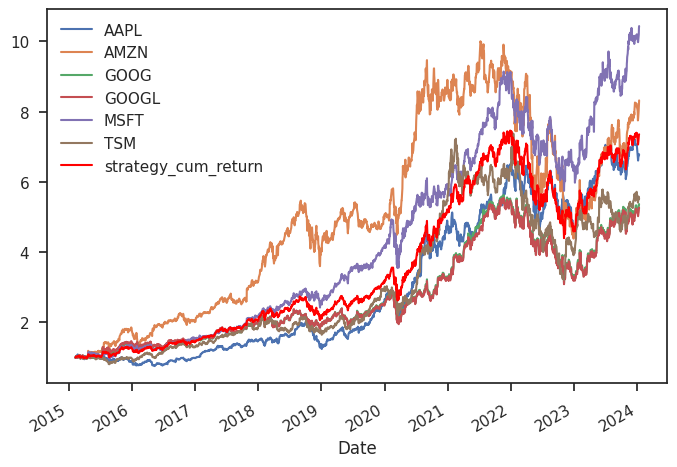

2. The daily weights assigned to each stock

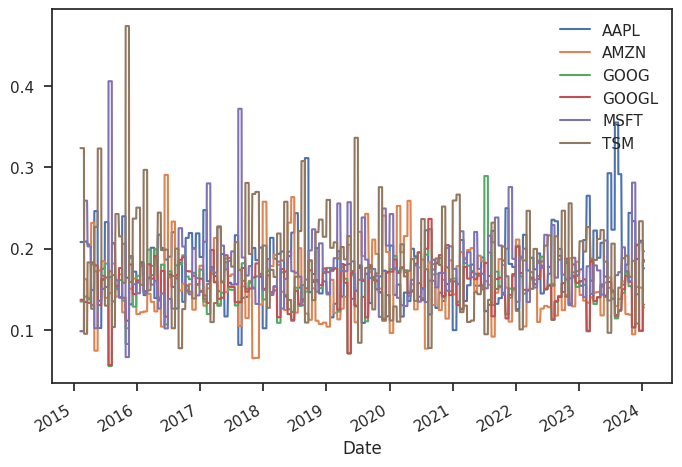

- The annualized Sharpe ratio \\
  0.924271120835698
- Sharpe ratio \\
  0.924271120835698



In [ ]:
def day_weight(stoke, T=270*10, interval=7, cov_days=30):
    """
    Calculate daily weights for the strategy based on historical returns.

    Parameters:
        stoke (list): List of stock symbols.
        T (int): Historical data period in days.
        interval (int): Interval for updating weights.
        cov_days (int): Number of days to calculate covariance.

    Returns:
        day (DataFrame): DataFrame containing pass days.
        strategy_weight (list): List of strategy weights.
    """
    d = date.today()
    returns_pct = get_return(stoke, d - timedelta(days=T), d)
    pass_day = 0
    strategy_weight = []
    n = len(stoke)
    x0 = np.ones([n, 1])
    b = np.ones([n, 1])
    b /= n
    returns_pct["pass_day"] = {}

    # Iterate over historical returns to calculate weights at specified intervals
    for i in range(len(returns_pct) - cov_days - 1, 1, -1):
        if pass_day % interval == 0:
            cov = (returns_pct.iloc[-1 - i - cov_days:-1 - i, 0:n]).cov()
            x_netwon = newton(x0, b, cov, 1e-8, 1000)
            strategy_weight.append(x_netwon[-1])
        else:
            strategy_weight.append(strategy_weight[-1])
        returns_pct.iloc[-1 - i, n] = int(pass_day)
        pass_day += 1

    day = returns_pct.dropna()
    day = day.loc[:, "pass_day"]
    return day, strategy_weight

def backtesting(day, strategy_weight):
    """
    Perform backtesting based on calculated weights.

    Parameters:
        day (DataFrame): DataFrame containing pass days.
        strategy_weight (list): List of strategy weights.

    Returns:
        returns_pct (DataFrame): DataFrame with cumulative returns.
    """
    TAX_RATE = 0.001425 + 0.003/2
    # TAX_RATE = 0
    returns_pct = get_return(stoke, day.index[0], day.index[-1] + timedelta(days=1))
    n = returns_pct.shape[1]
    returns_pct = pd.merge(returns_pct, day, on="Date", how="right")

    strategy_cum_return = [1]

    # Iterate over days to calculate cumulative returns with tax considerations
    for i in range(1, len(returns_pct)):
        total_value = strategy_cum_return[i-1] * (1 + strategy_weight[i-1].dot(np.array(returns_pct.iloc[i, 0:n]).reshape([n, 1])))
        delta = np.linalg.norm((total_value * strategy_weight[i] - strategy_cum_return[i-1] * strategy_weight[i-1]), ord=1) / 2
        total_value -= delta * TAX_RATE
        strategy_cum_return.append(float(total_value))

    returns_pct["strategy_cum_return"] = strategy_cum_return
    returns_pct.pop("pass_day")
    returns_pct.iloc[:, 0:n] = (1 + returns_pct.iloc[:, 0:n]).cumprod(axis=0)

    print(returns_pct.tail())
    return returns_pct


[*********************100%%**********************]  6 of 6 completed
<ipython-input-13-3795c217401f>:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns_pct["pass_day"] = {}
[*********************100%%**********************]  6 of 6 completed


                AAPL      AMZN      GOOG     GOOGL       MSFT       TSM  \
Date                                                                      
2024-01-05  6.609019  7.787668  5.131568  5.025548   9.978598  5.441147   
2024-01-08  6.768791  7.994639  5.248848  5.140699  10.166909  5.584809   
2024-01-09  6.753471  8.116354  5.324669  5.218824  10.196757  5.565691   
2024-01-10  6.791772  8.242895  5.370984  5.268069  10.386153  5.506150   
2024-01-11  6.769885  8.320643  5.366128  5.260664  10.436623  5.529092   

            strategy_cum_return  
Date                             
2024-01-05             7.065418  
2024-01-08             7.229474  
2024-01-09             7.281072  
2024-01-10             7.343478  
2024-01-11             7.356015  


<Axes: xlabel='Date'>

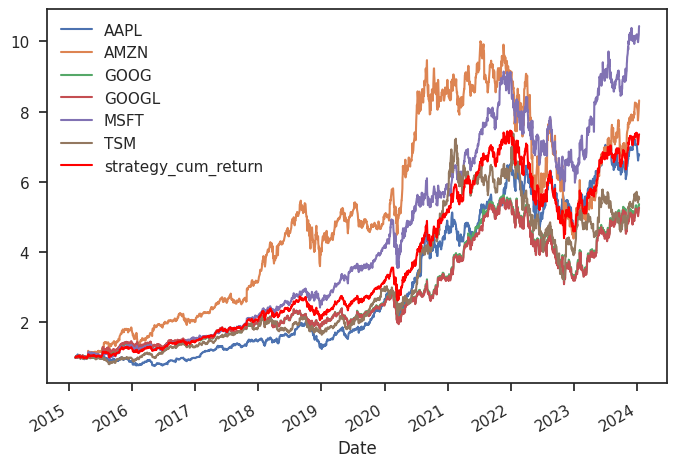

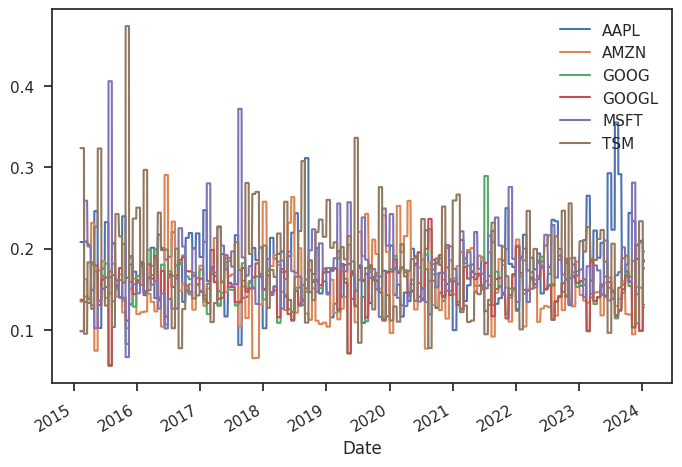

In [ ]:
# List of stocks in the portfolio
stoke = ['TSM', 'AAPL', 'GOOG', 'MSFT', 'AMZN', 'GOOGL']
stoke.sort()
n = len(stoke)

# Calculate daily weights and perform backtesting
day, weight = day_weight(stoke, T=365*9, interval=14, cov_days=15)
result = backtesting(day, weight)

# Visualize the results
result_plot = result.iloc[:, 0:n].plot()  # Individual stock returns
result_plot = result.strategy_cum_return.plot(color='red')  # Cumulative returns of the strategy
result_plot.legend()

# Plot the daily weights assigned to each stock
pd_weight = pd.DataFrame(weight, columns=stoke, index=day.index)
pd_weight.plot()



<ipython-input-15-2db2001ab1c0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


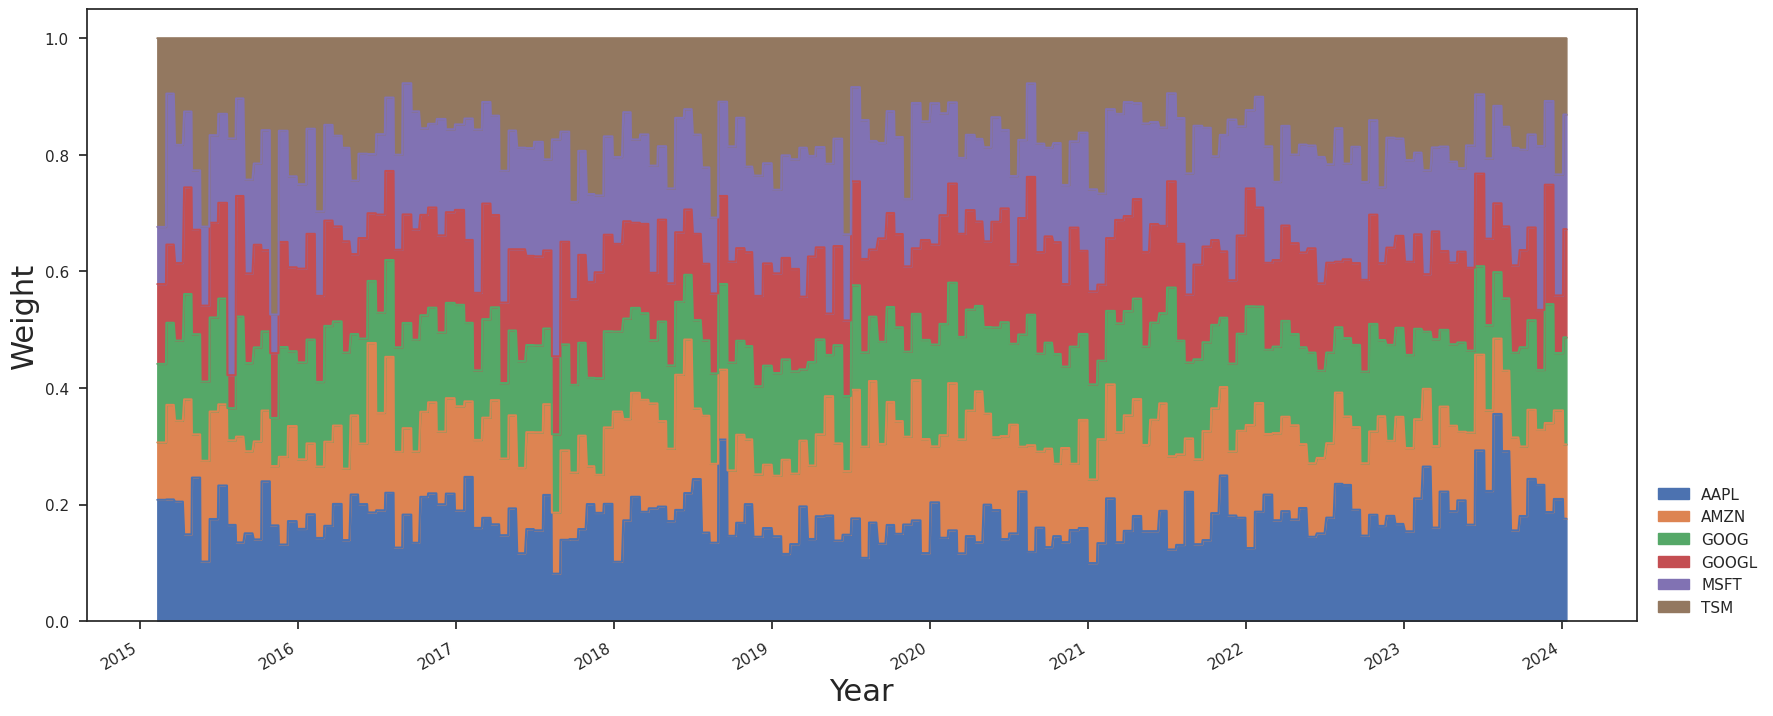

In [ ]:
plt.style.use('seaborn')
sns.set_style("white")
sns.set_theme(style = "ticks")

pd_weight.plot.area(figsize = (20,9))
plt.ylabel("Weight", fontsize = 22)
plt.xlabel("Year", fontsize = 22)
plt.legend(bbox_to_anchor=(1.01,0),loc=3,borderaxespad=0)


In [ ]:
# Extract strategy cumulative returns from the result DataFrame
pct_return = result.loc[:, "strategy_cum_return"]

# Print the cumulative returns
print(pct_return)

# Calculate Sharpe ratio using the empyrical library
# Note: risk-free rate is assumed to be 0.038/365
sr = empyrical.sharpe_ratio(pct_return.pct_change(), risk_free=0.038/365)

# Calculate annualized Sharpe ratio using the empyrical library
SR = empyrical.sharpe_ratio(pct_return, 0.038)

# Print the annualized Sharpe ratio
print(SR * 252**0.5, sr)


Date
2014-12-22    1.000000
2014-12-23    1.002410
2014-12-24    0.999263
2014-12-26    1.007116
2014-12-29    1.005918
                ...   
2023-11-17    7.190348
2023-11-20    7.270062
2023-11-21    7.215870
2023-11-22    7.285835
2023-11-24    7.243590
Name: strategy_cum_return, Length: 2247, dtype: float64
0.924271120835698 0.924271120835698


## Finding the Optimal Weight Vector \( b \) (First Version)

Using returns from the last 15 years, the initial 70% of the data was selected to determine the most suitable weight vector \( b \).



In [ ]:
def day_weight_start_end_newton_1(returns_test, b, interval=7, cov_days=30):
    """
    Calculate daily weights and intervals using Newton's Method for a given set of returns.

    Parameters:
    - returns_test: DataFrame containing historical returns.
    - b: Array of weights for risk contribution.
    - interval: Number of days between weight updates.
    - cov_days: Number of days used for calculating the covariance.

    Returns:
    - day: DataFrame containing weights for each day.
    - strategy_weight: List of calculated strategy weights.
    """
    returns_pct = returns_test
    pass_day = 0
    strategy_weight = []
    n = len(stoke)  # Assuming stoke is a global variable
    x0 = np.ones([n, 1])

    returns_pct["pass_day"] = {}
    for i in range(len(returns_pct) - cov_days - 1, 1, -1):
        if pass_day % interval == 0:
            cov = returns_pct.iloc[-1 - i - cov_days:-1 - i, 0:n].cov()
            x_newton = newton(x0, b, cov, 1e-8, 1000)  # Assuming newton is a global function
            strategy_weight.append(x_newton[-1])
        else:
            strategy_weight.append(strategy_weight[-1])
        returns_pct.iloc[-1 - i, n] = int(pass_day)
        pass_day += 1
    day = returns_pct.dropna()
    return day, strategy_weight  # day contains stoke

In [ ]:
# List of stocks and sorting alphabetically
stoke = ['TSM', 'AAPL', 'GOOG', 'MSFT', 'AMZN', 'GOOGL']
stoke.sort()

# Number of stocks
n = len(stoke)

# Current date
d = date.today()

# Get historical stock data for the specified stocks and time period
returns_ALL = get_return(stoke, d - timedelta(days=365 * 15), d)

# Split the dataset into training and testing sets
returns_train, returns_test = returns_ALL.iloc[:int(len(returns_ALL) * 0.7)], returns_ALL.iloc[int(len(returns_ALL) * 0.7):]

# Number of weight combinations and base weights with specified intervals
participate = 10  # 0.05 as an interval
base = [i for i in range(1, participate)]

# Generate all possible combinations of base weights using itertools.product
from itertools import product
base = list(product(base, repeat=n - 1))

# List to store the results for each combination
last_value = []

# Loop through each combination
for i in range(len(base)):
    print(i)

    # Calculate the remaining weight to ensure the total sum is 1
    temp = 1
    base[i] = list(base[i])
    if sum(base[i]) >= participate:
        continue
    else:
        base[i] = [j / participate for j in base[i]]

    # Calculate the remaining weight to ensure the total sum is 1
    for j in range(len(base[i])):
        temp -= base[i][j]
    base[i].append(temp)

    # Convert the list of weights to a NumPy array
    b = np.array(base[i]).reshape([n, 1])

    # Calculate daily weights and perform backtesting for each combination using the training dataset
    day, weight = day_weight_start_end_newton_1(returns_train, b, interval=14, cov_days=15)
    result = backtesting_start_end(day, weight, n)

    # Append the combination and the last cumulative return to the list
    base[i].append(result.iloc[-1, -1])
    last_value.append(base[i])


In [ ]:
# 歷史遺物
last_value_005=last_value
train_result=np.array(last_value)
argmax=np.argmax(train_result[:,len(train_result[0])-1])
print(argmax)
print(train_result[argmax])
plt.plot(range(len(train_result)),train_result[:,len(train_result[0])-1])
print(train_result[argmax][:n])
# 跟 equal weight 比
b_equal=np.ones([n,1])
b_equal/=n
day_equal,weight_equal = day_weight_start_end_newton_1(returns_test,b_equal,interval=14,cov_days=15)
result_equal=backtesting_start_end(day_equal,weight_equal,n)
day_equal,weight_equal = day_weight_start_end_newton_1(returns_test,train_result[argmax][:n].reshape([n,1]),interval=14,cov_days=15)
result=backtesting_start_end(day_equal,weight_equal,n)
result["equal_return"]=result_equal.iloc[:,-1]
ax=result.plot()
print(returns_test)

## Improvement
This improved version moves the calculation of the covariance matrix outside the loop and preprocesses the data before the loop. This should make the execution more efficient.

In [ ]:
def day_weight_start_end_netwon_2(returns_train_pass, b, n, cov, interval=7, cov_days=30):
    """
    Calculates daily weights using the Netwon method for the training data.

    Parameters:
    - returns_train_pass: DataFrame, historical returns of stocks for training.
    - b: array, capital budget.
    - n: int, number of stocks.
    - cov: list, covariance matrices.
    - interval: int, interval for selecting data.
    - cov_days: int, number of days for covariance calculation.

    Returns:
    Tuple containing original DataFrame returns_train_pass and list of strategy weights.
    """
    pass_day = 0
    strategy_weight = []
    x0 = np.ones([n, 1])/n
    cov_index = 0
    for i in range(len(returns_train_pass) - 1, -1, -1):
        if pass_day % interval == 0:
            x_netwon = newton(x0, b, cov[cov_index].values, 1e-8, 1000)
            if len(x_netwon[-1]) == 1:
                x_netwon.append(strategy_weight[-1])
            strategy_weight.append(x_netwon[-1])
            cov_index += 1
        else:
            strategy_weight.append(strategy_weight[-1])
        pass_day += 1
    return returns_train_pass, strategy_weight

In [ ]:
stoke = ['TSM', 'AAPL', 'GOOG', 'MSFT', 'AMZN', 'GOOGL']
stoke.sort()
n = len(stoke)
interval = 14
cov_days = 15

# Get historical returns data
d = date.today()
returns_ALL = get_return(stoke, d - timedelta(days=365 * 15), d)
returns_train, returns_test = returns_ALL.iloc[:int(len(returns_ALL) * 0.7)], returns_ALL.iloc[int(len(returns_ALL) * 0.7):]

# Calculate covariance matrices for training data
cov = list_cov(returns_train, n, interval, cov_days)

# Retrieve the days that have passed for training data
returns_train_pass = returns_train.copy()
returns_train_pass = retrieve_pass_day(returns_train_pass, n, cov_days)

# Define participation parameters
participate = 10  # 0.05 as the interval
base = [i for i in range(1, int(participate * 0.3) + 1)]

# Generate combinations of weights for stocks
from itertools import product
base = list(product(base, repeat=n - 1))

last_value = []
print(len(base))
for i in range(len(base)):
    print(i)
    base[i] = list(base[i])
    temp = participate - sum(base[i])
    if sum(base[i]) >= participate or temp > participate * 0.3:
        continue
    else:
        base[i].append(temp)
        base[i] = [j / participate for j in base[i]]

    # Set the weights and calculate results
    b = np.array(base[i]).reshape([n, 1])
    day, weight = day_weight_start_end_netwon_2(returns_train_pass, b, n, cov, interval, cov_days)
    result = backtesting_start_end(day, weight, n)

    # Append the last value for each combination
    base[i].append(result.iloc[-1, -1])
    last_value.append(base[i])


## Using 0.1 as an interval
Observation: Applying a 0.1 interval during testing shows poor performance. \\
Reason: The performance of $b_i$ might coincidentally appear good. \\
Improvement: Implement a cap (e.g., below 0.3) when running $b_i$ to enhance reliability, and this can also reduce execution time.

1. The cumulative returns of all strategies

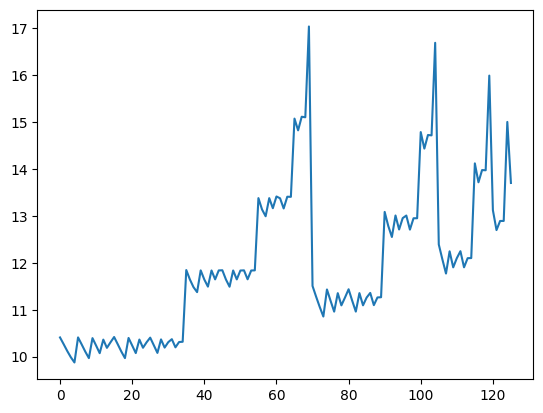

2. The cumulative returns for the best-performing strategy and equal weight

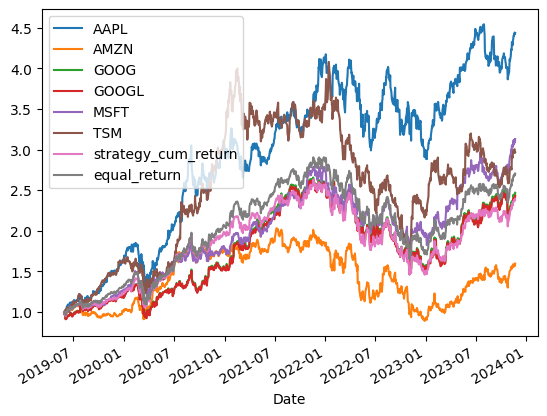


3. The cumulative returns for the best-performing strategy and equal weight on the training data

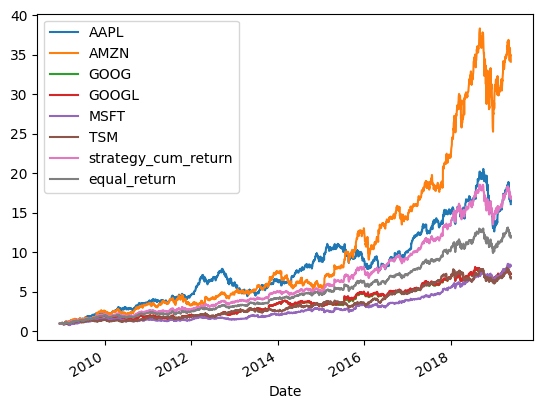


69
[ 0.1         0.5         0.1         0.1         0.1         0.1
 17.04088967]
[0.1 0.5 0.1 0.1 0.1 0.1]
                AAPL      AMZN      GOOG     GOOGL      MSFT       TSM  \
Date                                                                     
2019-05-29  0.995231  0.990612  0.984402  0.982783  0.990330  1.001063   
2019-05-30  1.000393  0.989049  0.985716  0.984073  0.996591  1.010359   
2019-05-31  0.982270  0.966587  0.973090  0.970989  0.980342  1.018592   
2019-06-03  0.972339  0.921729  0.913662  0.911527  0.949905  1.031076   
2019-06-04  1.007911  0.941806  0.928493  0.925348  0.976221  1.037450   
...              ...       ...       ...       ...       ...       ...   
2023-11-16  4.400033  1.555518  2.445885  2.403208  3.115068  2.963099   
2023-11-17  4.399569  1.581111  2.414848  2.374776  3.062732  2.994372   
2023-11-20  4.440389  1.591457  2.432130  2.391274  3.125585  3.005798   
2023-11-21  4.421603  1.567171  2.444474  2.403910  3.089397  2.959190   
202

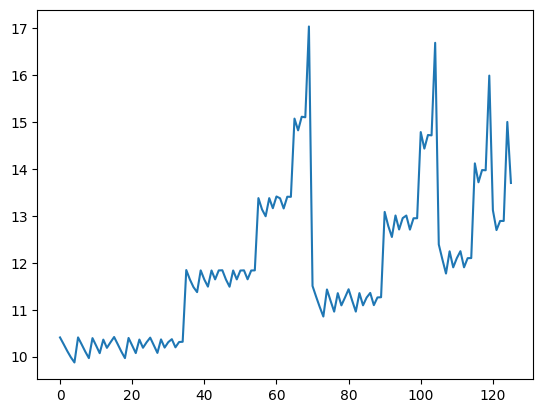

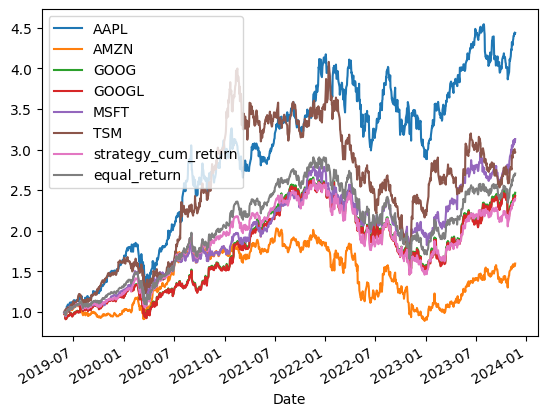

In [ ]:
# Convert the list to a NumPy array
train_result1 = np.array(last_value)

# Find the index of the maximum value in the last column
argmax = np.argmax(train_result1[:, len(train_result1[0]) - 1])
print(argmax)
print(train_result1[argmax])

# Plot the cumulative returns of all strategies
plt.plot(range(len(train_result1)), train_result1[:, len(train_result1[0]) - 1])

# Compare with equal weight
b_equal = np.ones([n, 1]) / n  # Equally weighted portfolio
day_equal, weight_equal = day_weight_start_end_netwon_2(returns_test, b_equal, n, cov, interval, cov_days)
result_equal = backtesting_start_end(day_equal, weight_equal, n)

# Generate weights and backtest results for the best-performing strategy
day_best, weight_best = day_weight_start_end_netwon_2(returns_test, train_result1[argmax][:n].reshape([n, 1]), n, cov, interval, cov_days)
result_best = backtesting_start_end(day_best, weight_best, n)

# Plot cumulative returns for the best-performing strategy and equal weight
result_best.iloc[:, 0:n] = (1 + result_best.iloc[:, 0:n]).cumprod(axis=0)
result_best["equal_return"] = result_equal.iloc[:, -1]
ax = result_best.plot()

# Print the results
print(result_best)


<ipython-input-14-20edb80c3c37>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns_pct["pass_day"]={}
<ipython-input-14-20edb80c3c37>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_pct["pass_day"]={}
<ipython-input-14-20edb80c3c37>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_pct["strategy_cum_return"]=strategy_cum_return
<ipython-input-14-20edb80c3c37>:34: Settin

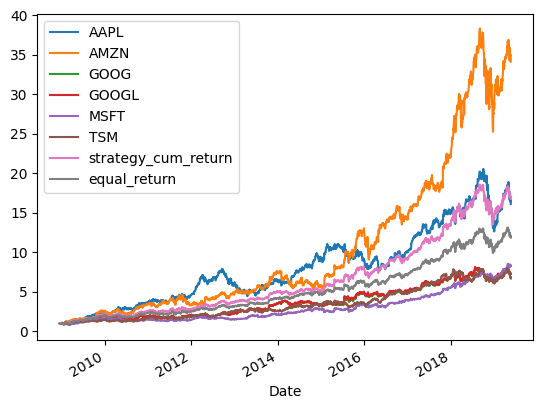

In [ ]:
# Generate weights and backtest results for the equally weighted strategy on the training data
day_equal_train, weight_equal_train = day_weight_start_end_netwon_2(returns_train, b_equal, n, cov, interval, cov_days)
result_equal_train = backtesting_start_end(day_equal_train, weight_equal_train, n)

# Generate weights and backtest results for the best-performing strategy on the training data
day_best_train, weight_best_train = day_weight_start_end_netwon_2(returns_train, train_result1[argmax][:n].reshape([n, 1]), n, cov, interval, cov_days)
result_best_train = backtesting_start_end(day_best_train, weight_best_train, n)

# Adjust the cumulative returns of the best-performing strategy for plotting
result_best_train.iloc[:, 0:n] = (1 + result_best_train.iloc[:, 0:n]).cumprod(axis=0)
result_best_train["equal_return"] = result_equal_train.iloc[:, -1]

# Plot cumulative returns for the best-performing strategy and equal weight on the training data
ax = result_best_train.plot()


## Upper Limit: 0.3, Interval: 0.1
Result: Slightly better performance compared to equal weight.


1. The cumulative returns of all strategies

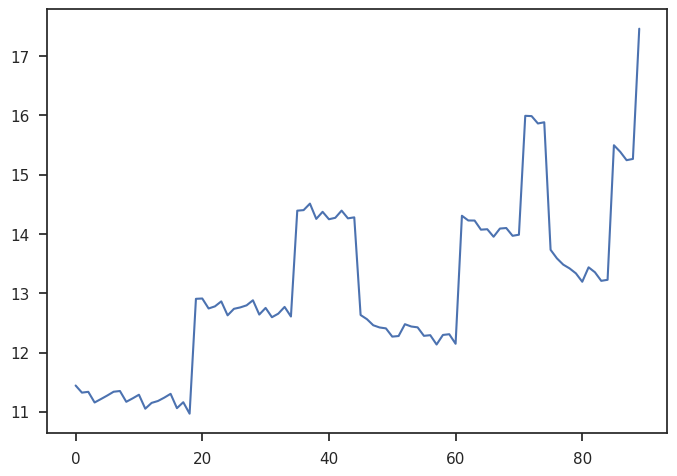

2. The cumulative returns for the best-performing strategy and equal weight

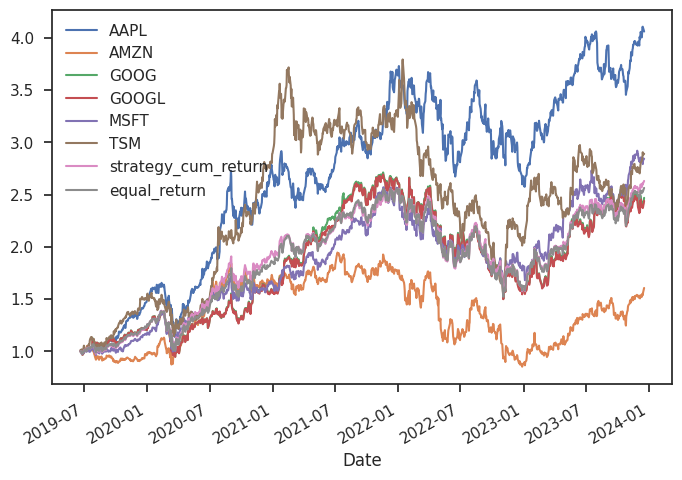

89
[ 0.3         0.3         0.1         0.1         0.1         0.1
 17.46088379]
                AAPL      AMZN      GOOG     GOOGL      MSFT       TSM  \
Date                                                                     
2019-06-21  0.996591  0.996408  1.009411  1.010932  1.000146  1.000247   
2019-06-24  0.995588  0.997764  1.003689  1.003144  1.006061  1.019006   
2019-06-25  0.980498  0.979189  0.977443  0.976985  0.974297  0.991989   
2019-06-26  1.001705  0.989386  0.971550  0.970464  0.977948  0.996067   
2019-06-27  1.001404  0.992748  0.968140  0.967149  0.979554  1.009066   
...              ...       ...       ...       ...       ...       ...   
2023-12-12  4.035329  1.537700  2.404851  2.380884  2.855984  2.839422   
2023-12-13  4.102685  1.551880  2.410790  2.381782  2.855907  2.853955   
2023-12-14  4.105793  1.537074  2.396934  2.370464  2.791522  2.904749   
2023-12-15  4.094602  1.563662  2.408450  2.382321  2.828140  2.879198   
2023-12-18  4.059784  1.60641

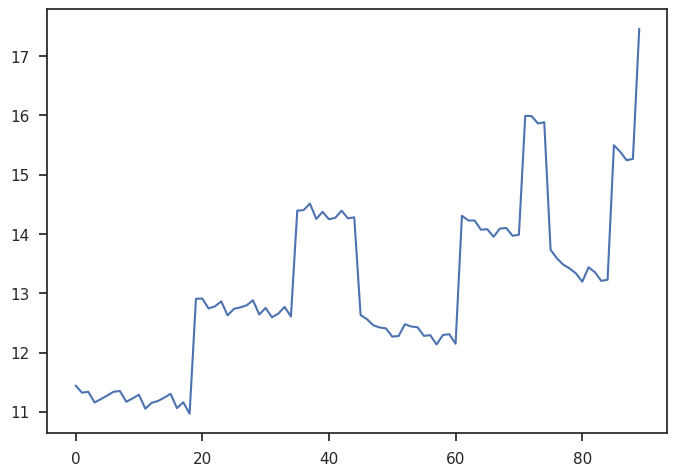

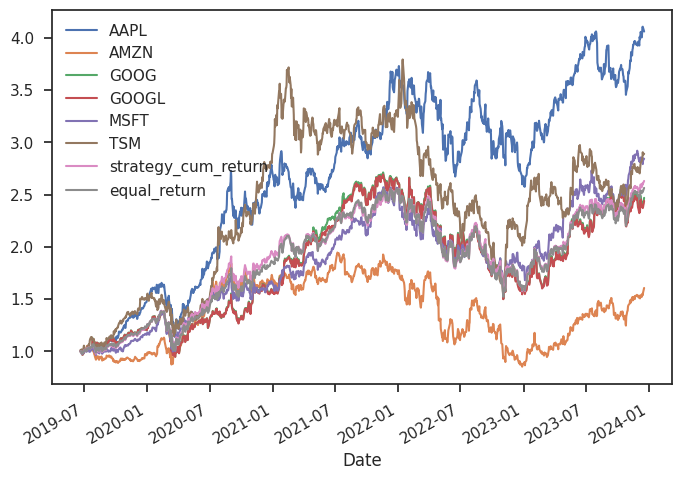

In [ ]:
# Convert the list to a NumPy array
train_result1 = np.array(last_value)

# Find the index of the maximum value in the last column
argmax = np.argmax(train_result1[:, len(train_result1[0]) - 1])
print(argmax)
print(train_result1[argmax])

# Plot the cumulative returns of all strategies
plt.plot(range(len(train_result1)), train_result1[:, len(train_result1[0]) - 1])

# Compare with equal weight
b_equal = np.ones([n, 1]) / n  # Equally weighted portfolio
day_equal, weight_equal = day_weight_start_end_netwon_2(returns_test, b_equal, n, cov, interval, cov_days)
result_equal = backtesting_start_end(day_equal, weight_equal, n)

# Generate weights and backtest results for the best-performing strategy
day_best, weight_best = day_weight_start_end_netwon_2(returns_test, train_result1[argmax][:n].reshape([n, 1]), n, cov, interval, cov_days)
result_best = backtesting_start_end(day_best, weight_best, n)

# Plot cumulative returns for the best-performing strategy and equal weight
result_best.iloc[:, 0:n] = (1 + result_best.iloc[:, 0:n]).cumprod(axis=0)
result_best["equal_return"] = result_equal.iloc[:, -1]
ax = result_best.plot()

# Print the results
print(result_best)


## Interval: 0.05, Upper Limit: 0.3

1. The cumulative returns of all strategies over time

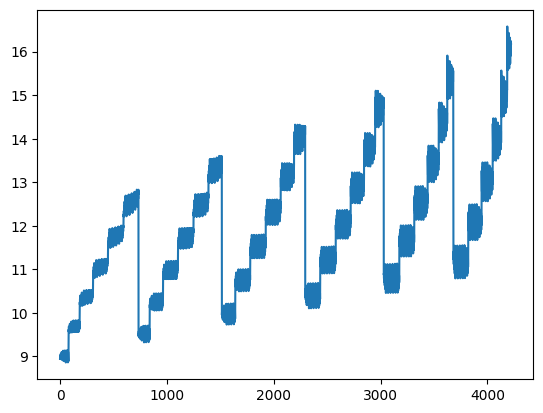

2. The cumulative returns for the best-performing strategy and equal weight on the test data

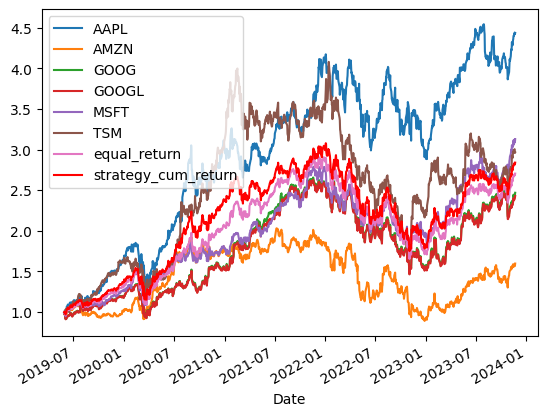

3. The weights over time

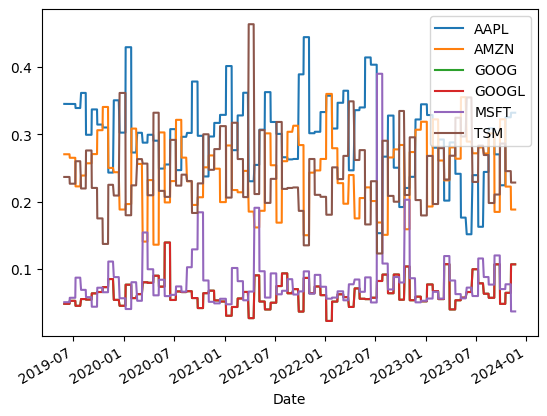



4186
[ 0.3         0.3         0.05        0.05        0.05        0.25
 16.57838206]
[0.3  0.3  0.05 0.05 0.05 0.25]
                AAPL      AMZN      GOOG     GOOGL      MSFT       TSM  \
Date                                                                     
2019-05-29  0.995231  0.990612  0.984402  0.982783  0.990330  1.001063   
2019-05-30  1.000393  0.989049  0.985716  0.984073  0.996592  1.010359   
2019-05-31  0.982270  0.966587  0.973090  0.970989  0.980342  1.018592   
2019-06-03  0.972339  0.921729  0.913662  0.911527  0.949905  1.031076   
2019-06-04  1.007911  0.941806  0.928493  0.925348  0.976221  1.037450   
...              ...       ...       ...       ...       ...       ...   
2023-11-16  4.400032  1.555518  2.445885  2.403208  3.115069  2.963099   
2023-11-17  4.399568  1.581111  2.414848  2.374776  3.062733  2.994372   
2023-11-20  4.440389  1.591457  2.432130  2.391274  3.125585  3.005798   
2023-11-21  4.421602  1.567171  2.444474  2.403910  3.089397  2.9591

<Axes: xlabel='Date'>

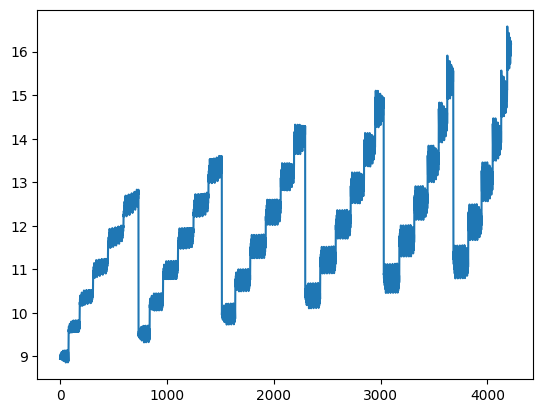

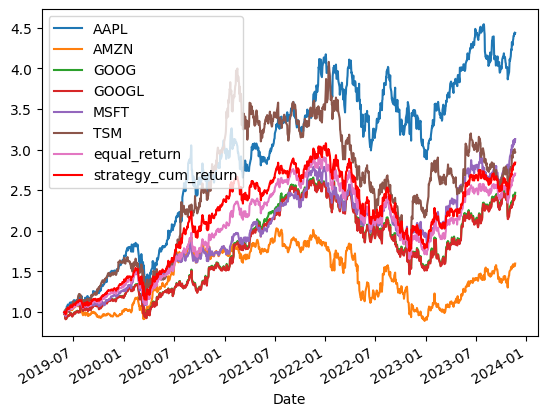

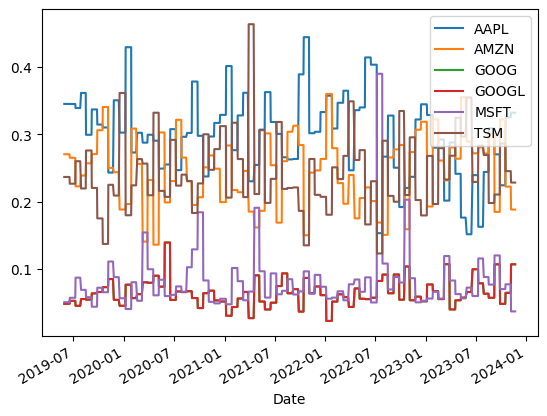

In [ ]:
# Convert the last_value list to a NumPy array for easier manipulation
train_result1 = np.array(last_value)

# Find the index of the best-performing strategy based on the final value
argmax = np.argmax(train_result1[:, len(train_result1[0]) - 1])

# Print information about the best-performing strategy
print(argmax)
print(train_result1[argmax])

# Plot the cumulative returns of all strategies over time
plt.plot(range(len(train_result1)), train_result1[:, len(train_result1[0]) - 1])

# Print the weight of the best-performing strategy
print(train_result1[argmax][:n])

# Define equal weight for comparison
b_equal = np.ones([n, 1])
b_equal /= n

# Generate weights and backtest results for the equally weighted strategy on the test data
day_equal, weight_equal = day_weight_start_end_netwon_2(returns_test, b_equal, n, cov, interval, cov_days)
result_equal = backtesting_start_end(day_equal, weight_equal, n)

# Generate weights and backtest results for the best-performing strategy on the test data
day, weight = day_weight_start_end_netwon_2(returns_test, train_result1[argmax][:n].reshape([n, 1]), n, cov, interval, cov_days)
result = backtesting_start_end(day, weight, n)

# Adjust the cumulative returns of the best-performing strategy for plotting
result.iloc[:, 0:n] = (1 + result.iloc[:, 0:n]).cumprod(axis=0)
result["equal_return"] = result_equal.iloc[:, -1]

# Plot cumulative returns for the best-performing strategy and equal weight on the test data
result_plot = result.iloc[:, 0:n].plot()
result_plot = result.iloc[:, -1].plot()
result_plot = result.strategy_cum_return.plot(color='red')
result_plot.legend()

# Display the results DataFrame
print(result)

# Create a DataFrame for the weights of the best-performing strategy
pd_weight = pd.DataFrame(weight, columns=stoke, index=day.index)

# Plot the weights over time
pd_weight.plot()


In [ ]:
# Define a weight vector for the strategy
weight_vector = np.array([0.3, 0.3, 0.05, 0.05, 0.05, 0.25]).reshape([n, 1])

# Generate weights and backtest results for the specified weight vector on the test data
day_equal, weight_equal = day_weight_start_end_netwon_2(returns_test, weight_vector, n, cov, interval, cov_days)
result = backtesting_start_end(day_equal, weight_equal, n)

# Extract the strategy cumulative returns for Sharpe ratio calculation
pct_return = result.loc[:, "strategy_cum_return"]

# Calculate the Sharpe ratio using the empyrical library
sharpe_ratio_empyrical = empyrical.sharpe_ratio(pct_return.pct_change())

# Calculate the Sharpe ratio using a custom function (assuming sharp_ratio is defined)
sharpe_ratio_custom = sharp_ratio(pct_return, 0)

# Print the Sharpe ratios
print(sharpe_ratio_custom * 252**0.5, sharpe_ratio_empyrical)


0.0011526807394385767
0.018141025670738862
1.0086662021081763 1.0086662021081763


## Using the Sharpe ratio as a basis

1. The cumulative returns of all strategies over time

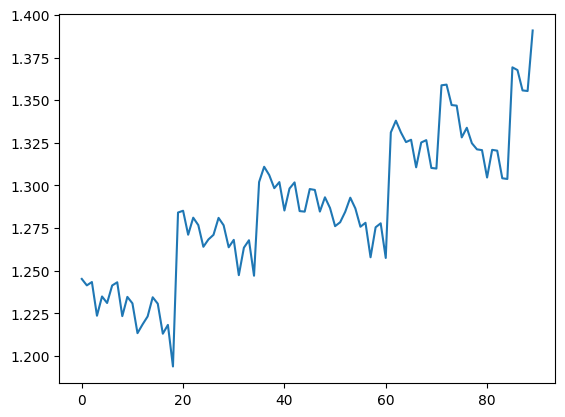


2. The cumulative returns for the best-performing strategy

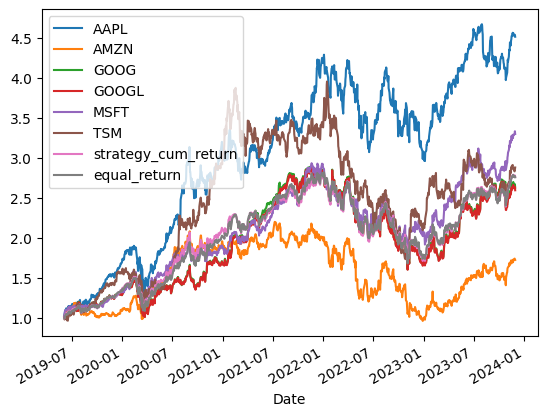


In [ ]:
stoke=['TSM','AAPL','GOOG','MSFT','AMZN','GOOGL']
stoke.sort()
n=len(stoke)
interval=14
cov_days=15

d = date.today()
returns_ALL=get_return(stoke,d - timedelta(days=365*15),d)
returns_train,returns_test=returns_ALL.iloc[:int(len(returns_ALL)*0.7)],returns_ALL.iloc[int(len(returns_ALL)*0.7):]
cov=list_cov(returns_train,n,interval,cov_days)
returns_train_pass=returns_train.copy()
returns_train_pass=retrieve_pass_day(returns_train_pass,cov_days)


participate=10 # 0.05 為間隔
base=[i for i in range(1,int(participate*0.3+1))]
# base=[0.2,0.1,0.05]
from itertools import product
base=list(product(base,repeat=n-1))
last_value=[]
print(len(base))
for i in range(len(base)):
  print(i)
  base[i]=list(base[i])
  temp = participate-sum(base[i])
  if sum(base[i])>=participate or temp>participate*0.3:
    continue
  else:
    base[i].append(temp)
    base[i]=[j/participate for j in base[i]]


  b=np.array(base[i]).reshape([n,1])
  day,weight = day_weight_start_end_netwon_2(returns_train_pass,b,n,cov,interval,cov_days)
  result=backtesting_start_end(day,weight,n)
  base[i].append(result.iloc[-1,-1])
  pct_return=result.loc[:,"strategy_cum_return"]
  # print(pct_return)
  sr=empyrical.sharpe_ratio(pct_return.pct_change())
  base[i].append(sr)
  # SR=sharp_ratio(pct_return,0.038)
  last_value.append(base[i])

89
[ 0.3         0.3         0.1         0.1         0.1         0.1
 17.42634415  1.39086479]
[0.3 0.3 0.1 0.1 0.1 0.1]
                AAPL      AMZN      GOOG     GOOGL      MSFT       TSM  \
Date                                                                     
2019-06-04  1.036584  1.021782  1.016232  1.015163  1.027704  1.006183   
2019-06-05  1.053318  1.027063  1.005781  1.005680  1.049983  0.984802   
2019-06-06  1.068783  1.036433  1.007826  1.008684  1.066589  0.990211   
2019-06-07  1.097230  1.065777  1.028768  1.028525  1.096462  1.000000   
2019-06-10  1.111252  1.099215  1.042606  1.042378  1.106475  1.020608   
...              ...       ...       ...       ...       ...       ...   
2023-11-22  4.563369  1.733454  2.702489  2.666500  3.293994  2.877002   
2023-11-24  4.531405  1.733808  2.667748  2.631842  3.290332  2.853088   
2023-11-27  4.527111  1.745506  2.664466  2.626451  3.300619  2.835006   
2023-11-28  4.541662  1.737235  2.675468  2.641662  3.336275  2.8

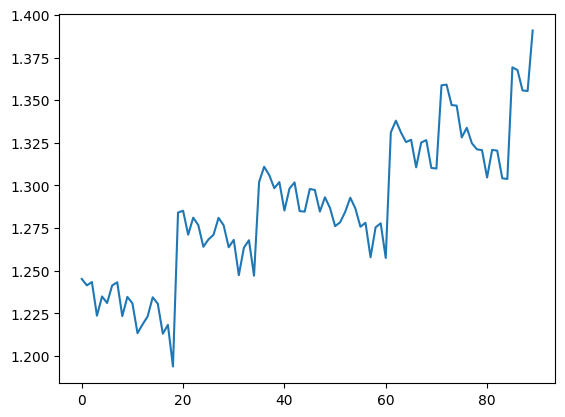

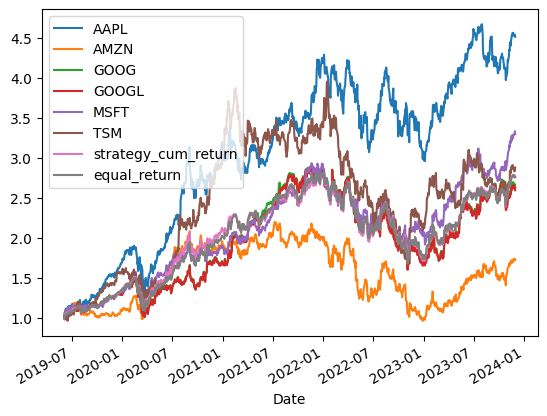

In [ ]:
train_result1=np.array(last_value)
# print(train_result1)
argmax=np.argmax(train_result1[:,len(train_result1[0])-1])
print(argmax)
print(train_result1[argmax])
plt.plot(range(len(train_result1)),train_result1[:,len(train_result1[0])-1])
print(train_result1[argmax][:n])
# 跟 equal weight 比
b_equal=np.ones([n,1])
b_equal/=n
day_equal,weight_equal = day_weight_start_end_netwon_2(returns_test,b_equal,n,cov,interval,cov_days)
result_equal=backtesting_start_end(day_equal,weight_equal,n)
day_equal,weight_equal = day_weight_start_end_netwon_2(returns_test,train_result1[argmax][:n].reshape([n,1]),n,cov,interval,cov_days)
result=backtesting_start_end(day_equal,weight_equal,n)
result.iloc[:,0:n]=(1+result.iloc[:,0:n]).cumprod(axis=0)
result["equal_return"]=result_equal.iloc[:,-1]
ax=result.plot()
print(result)
print(empyrical.sharpe_ratio(result["equal_return"].pct_change()))
print(empyrical.sharpe_ratio(result["strategy_cum_return"].pct_change()))

## Result

After various conclusions: testing different weight vectors (b values) doesn't seem very useful, \\

spending a lot of time on it doesn't yield significant results. It might be more effective to stick with equal weights. \\

Maybe can adjust b dynamically, similar to the method of on-line portfolio.


## Trying More assets (Selecting Taiwan 50 + Some Taiwan 100, Total 50 Stocks)
Stocks = ['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '1590.TW', '1722.TW', '2002.TW', '2105.TW', '2207.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2344.TW', '2357.TW', '2376.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2801.TW', '2881.TW', '2882.TW', '2884.TW', '2885.TW', '2886.TW', '2887.TW', '2891.TW', '2892.TW', '2912.TW', '3008.TW', '3034.TW', '3045.TW', '3711.TW', '4904.TW', '4938.TW', '5871.TW', '5876.TW', '5880.TW', '6415.TW', '6505.TW', '8046.TW', '9910.TW'] \\
Using Newton method to detetmine the weight. \\
Encountered Issues:
1. There's a chance of divergence.
2. There may be negative values.

It's because the Newton's method has issues with the initial values., \\
but in our practice it happens rarely. \\
When encountered, I use the weights from the previous period. \\

I also attempted to use the pyrb package to find weights, but for some reason, \\
weights didn't pose any issues. \\

However, the Sharpe ratio was nearly halved. \\
It seems that during the days when my algorithm couldn't produce the desired outcome, \\
PyRB, although executable, likely still has issues.



### Equal risk portfolio

1. The strategy cumulative return

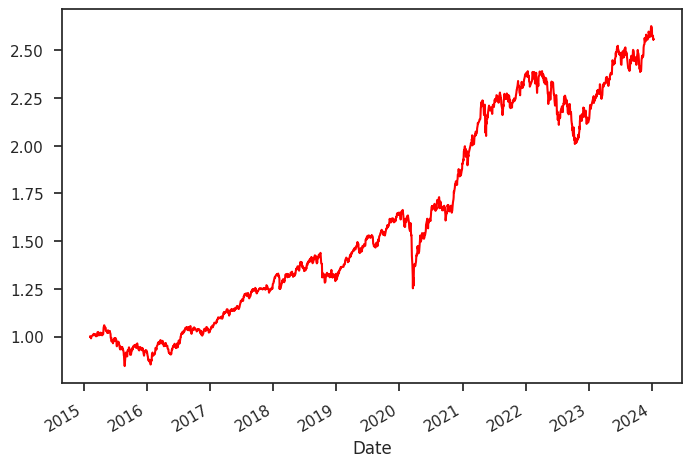

2. The weight evolution over time

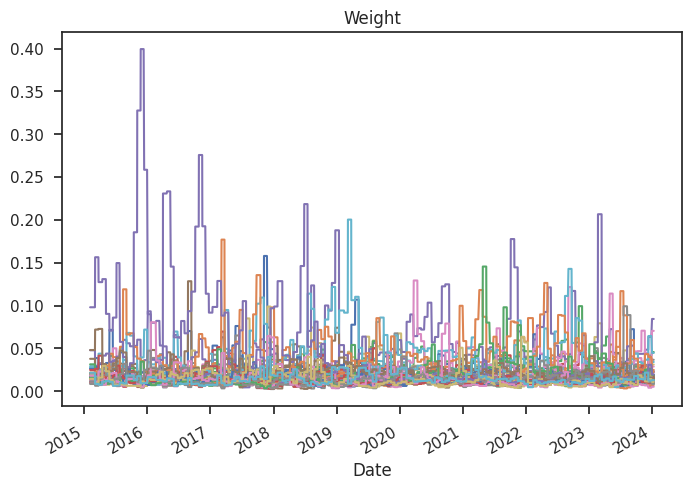


- The annualized Sharpe ratio \\
  1.0281036861205388
- Sharpe ratio \\
  1.0281036861205388



[*********************100%%**********************]  50 of 50 completed
<ipython-input-16-0471b498d338>:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns_test["pass_day"] = {}


Text(0.5, 1.0, 'Weight')

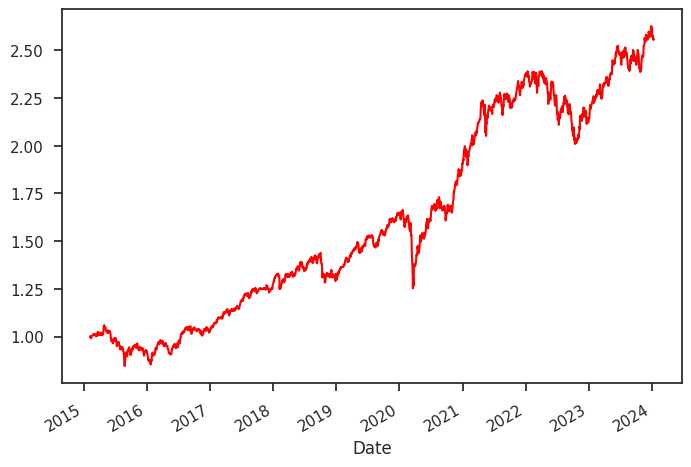

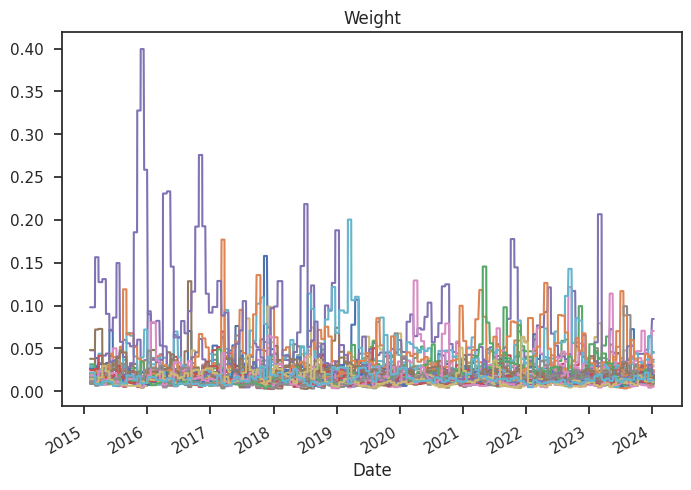

In [ ]:
# List of stock symbols
stoke =['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '1590.TW', '1722.TW', '2002.TW', '2105.TW', '2207.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2344.TW', '2357.TW', '2376.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2801.TW', '2881.TW', '2882.TW', '2884.TW', '2885.TW', '2886.TW', '2887.TW', '2891.TW', '2892.TW', '2912.TW', '3008.TW', '3034.TW', '3045.TW', '3711.TW', '4904.TW', '4938.TW', '5871.TW', '5876.TW', '5880.TW', '6415.TW', '6505.TW', '8046.TW', '9910.TW']
stoke.sort()

# Set parameters
interval = 14
cov_days = 30

# Get historical returns for the selected stocks
d = date.today()
returns_ALL = get_return(stoke, d - timedelta(days=365 * 9 + cov_days), d)

# Drop missing values in the returns
returns_ALL.dropna(inplace=True)

# Get the number of stocks
n = len(returns_ALL.columns)

# Calculate covariance matrices
cov = list_cov(returns_ALL, n, interval, cov_days)

# Retrieve the days that have passed for returns_ALL_pass data

returns_ALL_pass = returns_ALL.copy()
returns_ALL_pass = retrieve_pass_day(returns_ALL_pass, n, cov_days)

# Set initial weights
b = np.ones([n, 1])
b /= n

# Calculate day weights and perform backtesting
day, weight = day_weight_start_end_netwon_2(returns_ALL_pass, b, n, cov, interval, cov_days)
result = backtesting_start_end(day, weight, n)
# Plot the strategy cumulative return
result_plot = result.strategy_cum_return.plot(color='red')

# Plot the weight evolution over time
pd_weight = pd.DataFrame(weight, columns=returns_ALL_pass.columns, index=day.index)
weight_plt = pd_weight.plot()
weight_plt.legend_ = None
weight_plt.set_title("Weight")


<ipython-input-18-2db2001ab1c0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


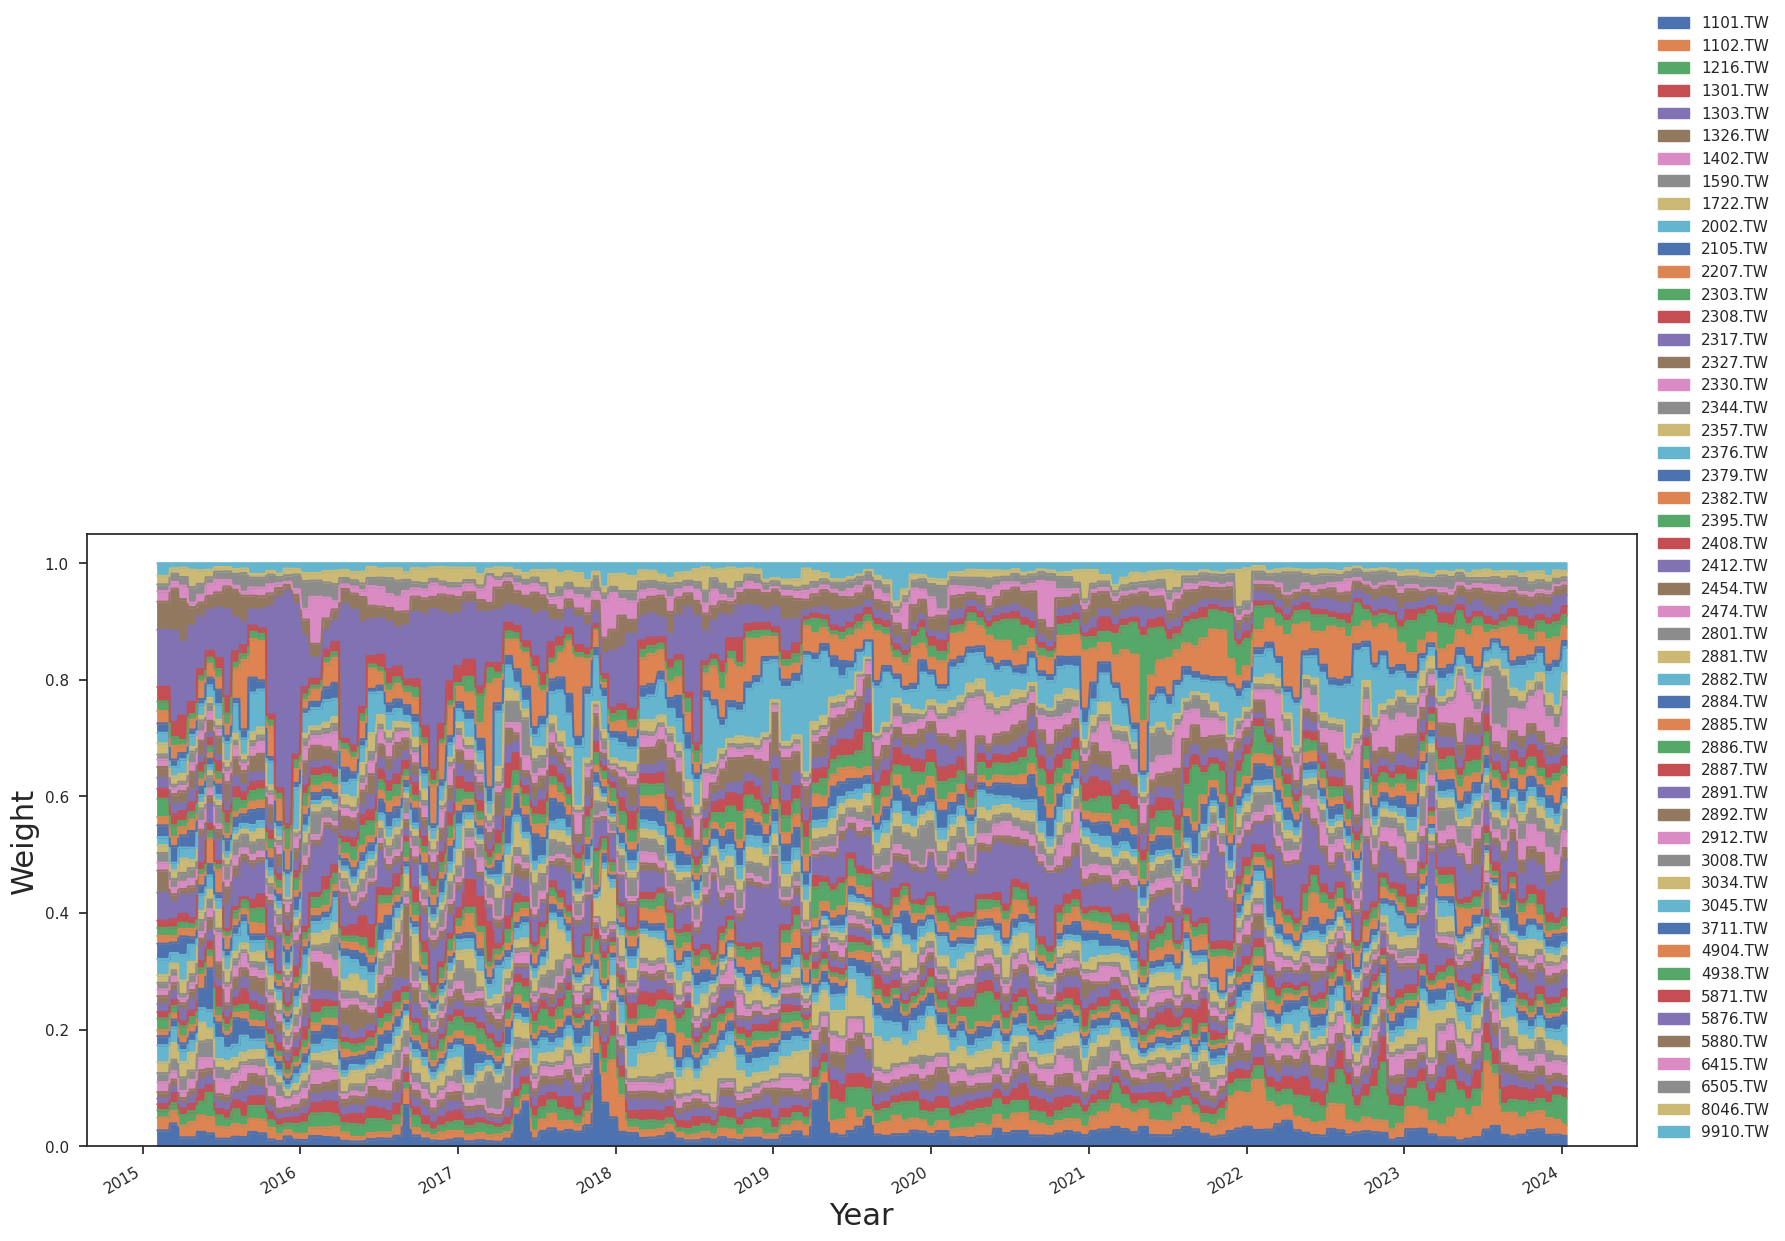

In [ ]:
plt.style.use('seaborn')
sns.set_style("white")
sns.set_theme(style = "ticks")

pd_weight.plot.area(figsize = (20,9))
plt.ylabel("Weight", fontsize = 22)
plt.xlabel("Year", fontsize = 22)
plt.legend(bbox_to_anchor=(1.01,0),loc=3,borderaxespad=0)


In [ ]:
print_SR_sr(result)

1.0281036861205388 1.0281036861205388


###The stock '5876.TW'
Observe that there is one purple line that stands out prominently in 2015/9~12.

1. The weight and corresponding cumulative return for the stock with the maximum weight

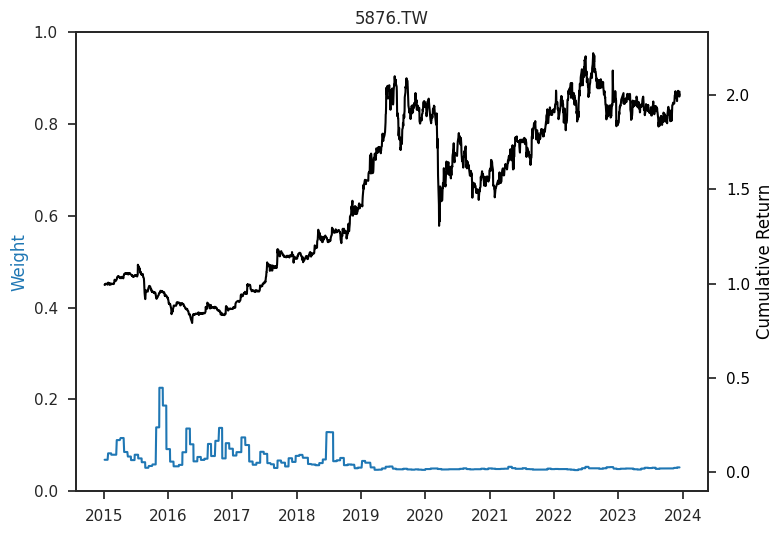

2. The weight on the left y-axis in blue

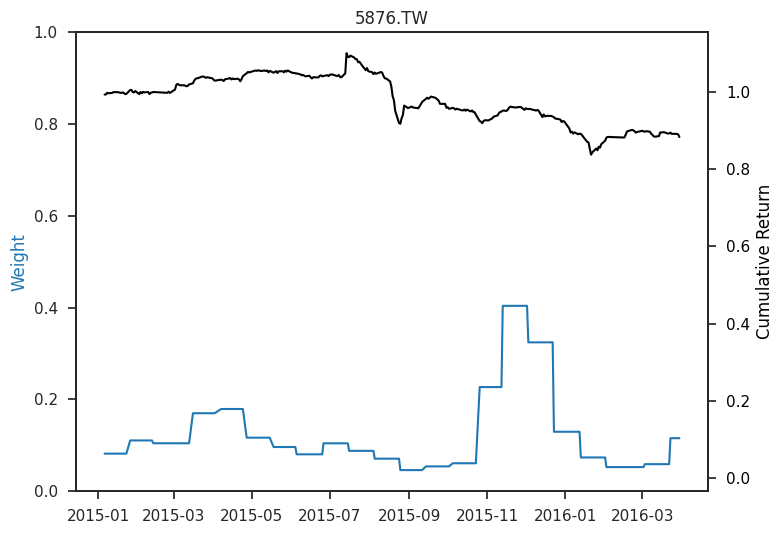



210 44
0.4461059312830006


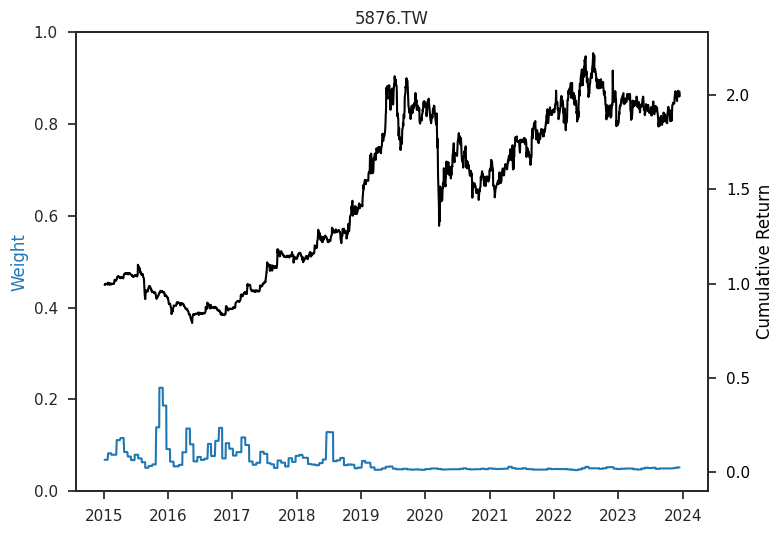

In [ ]:
# Find the index of the maximum weight in the flattened array
argmax = np.argmax(weight)

# Extract row and column indices from the flattened index
row_index = argmax // n
column_index = argmax % n

# Print the row and column indices along with the corresponding weight
print(row_index, column_index)
print(weight[row_index][column_index])

# Create a DataFrame for weight evolution over time
pd_weight = pd.DataFrame(weight, columns=returns_ALL_pass.columns, index=day.index)

# Plot the weight and corresponding cumulative return for the stock with the maximum weight
fig, ax1 = plt.subplots(1, 1)

# Set the title of the plot to the stock symbol with the maximum weight
plt.title(pd_weight.columns[column_index])

# Create a twin axes for two y-axes on the same plot
ax2 = ax1.twinx()

# Plot the weight on the left y-axis in blue
ax1.set_ylabel('Weight', color='tab:blue')
ax1 = pd_weight.iloc[:, column_index].plot(color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the cumulative return on the right y-axis in black
ax2.set_ylabel('Cumulative Return', color='black')
ax2 = ((1 + result[pd_weight.columns[column_index]]).cumprod()).iloc[:].plot(color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust layout for better appearance
fig.tight_layout()
plt.show()


210 44
0.4461059312830006


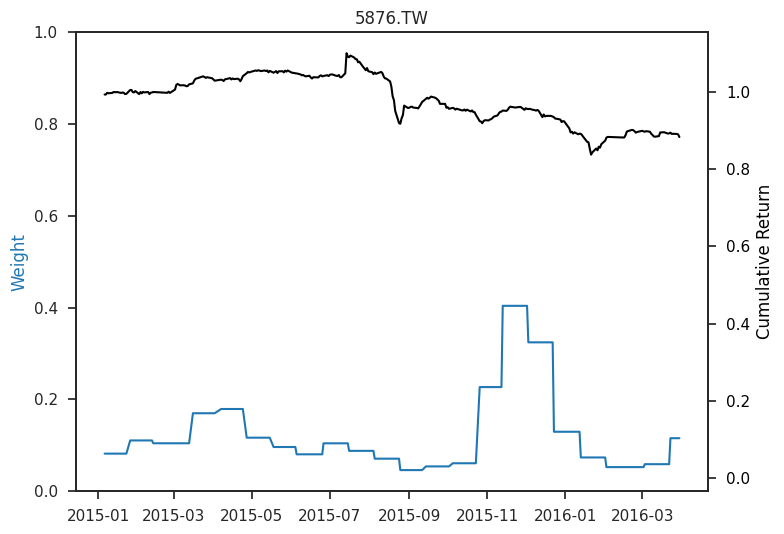

In [ ]:
# Find the index of the maximum weight in the flattened array
argmax = np.argmax(weight)

# Extract row and column indices from the flattened index
row_index = argmax // n
column_index = argmax % n

# Print the row and column indices along with the corresponding weight
print(row_index, column_index)
print(weight[row_index][column_index])

# Create a DataFrame for weight evolution over time
pd_weight = pd.DataFrame(weight, columns=returns_ALL_pass.columns, index=day.index)

# Plot the weight and corresponding cumulative return for the stock with the maximum weight
fig, ax1 = plt.subplots(1, 1)

# Set the title of the plot to the stock symbol with the maximum weight
plt.title(pd_weight.columns[column_index])

# Create a twin axes for two y-axes on the same plot
ax2 = ax1.twinx()

# Plot the weight on the left y-axis in blue
ax1.set_ylabel('Weight', color='tab:blue')
ax1 = pd_weight.iloc[:300, column_index].plot(color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the cumulative return on the right y-axis in black
ax2.set_ylabel('Cumulative Return', color='black')
ax2 = ((1 + result[pd_weight.columns[column_index]]).cumprod()).iloc[:300].plot(color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust layout for better appearance
fig.tight_layout()
plt.show()


### The average percentage of the top 5 assets by weight

1. The weights of the selected top 5 stocks

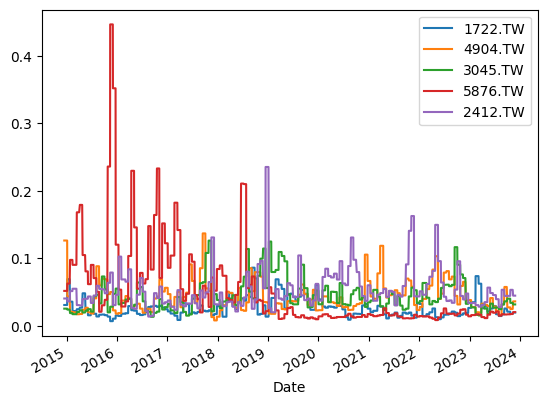

2. The cumulative returns of the selected top 5 stocks

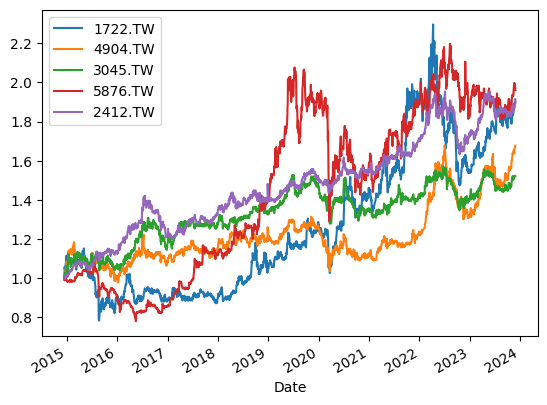

<Axes: xlabel='Date'>

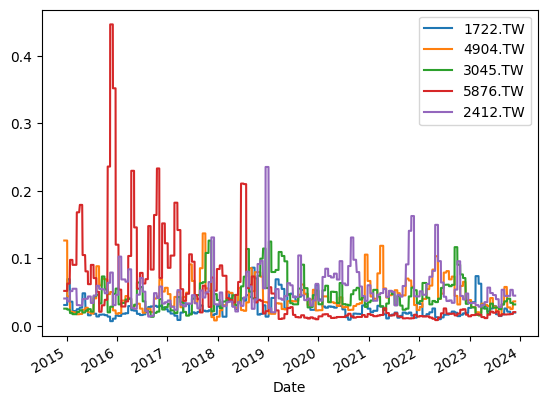

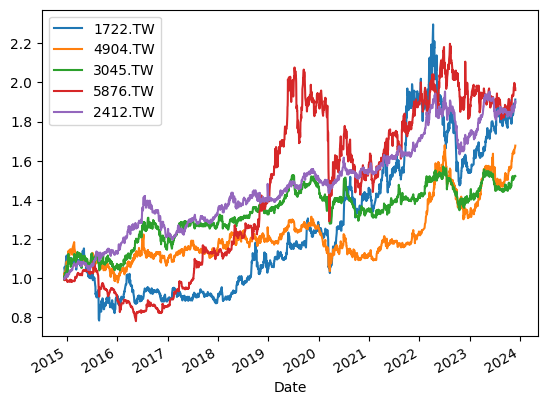

In [ ]:
# Create a copy of the weight DataFrame
pd_weight_avg = pd_weight.copy()

# Add a new row named "average" to store the average weight of each stock
pd_weight_avg.loc["average", :] = pd_weight_avg.mean(axis=0)

# Sort the columns based on the average weight
pd_weight_avg.sort_values(by="average", inplace=True, axis=1)

# Plot the weights of the selected top 5 stocks
weight_plt = pd_weight.plot(y=pd_weight_avg.columns[-5:])

# Plot the cumulative returns of the selected top 5 stocks
((1 + result[pd_weight_avg.columns[-5:]]).cumprod()).plot()


##Compare with the market and 0050 ETF
It is evident that the volatility is indeed smaller, and the trends are quite similar among them.

1. The cumulative return of the strategy along with the market indices

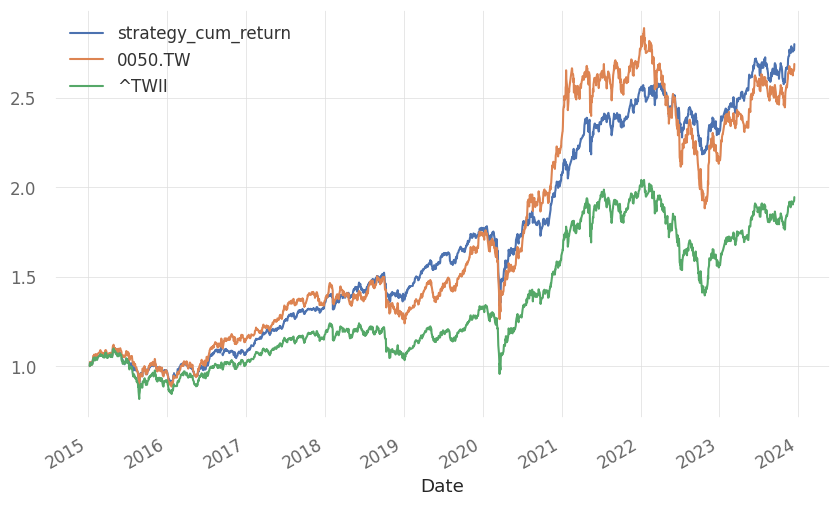

2. qs.plots strategy_cum_return

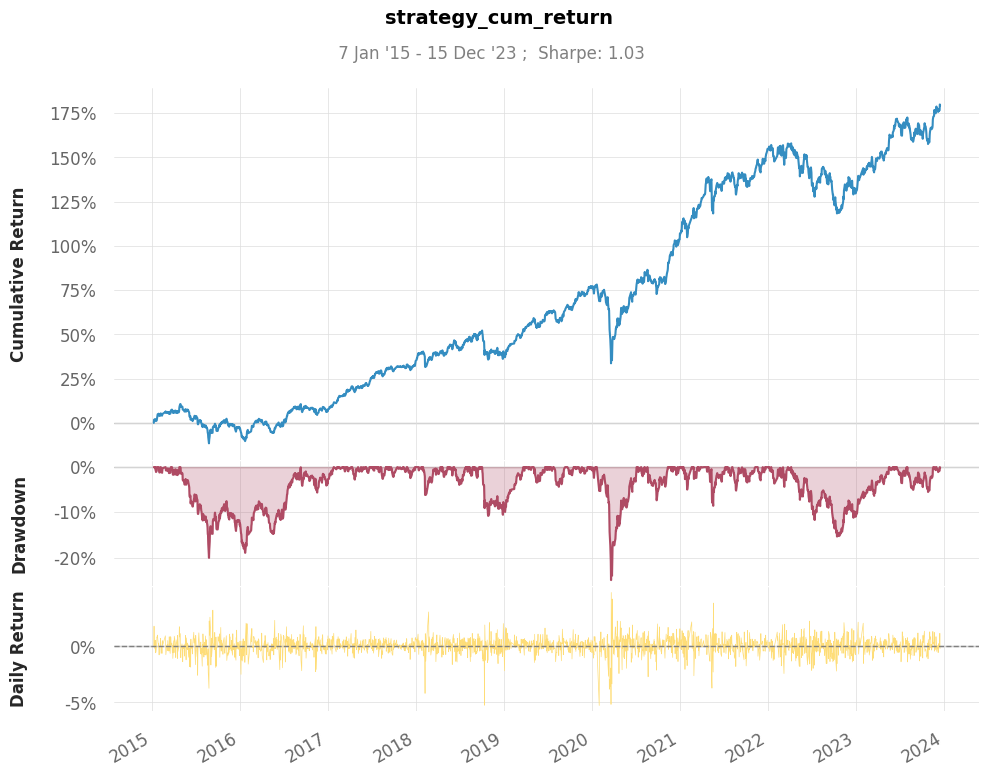


[*********************100%%**********************]  2 of 2 completed
             0050.TW     ^TWII
Date                          
2015-01-07  0.000000  0.000000
2015-01-08  0.023077  0.017394
2015-01-09 -0.005263 -0.002430
2015-01-12 -0.006047 -0.004045
2015-01-13  0.003042  0.005829
...              ...       ...
2023-12-08  0.008077  0.006091
2023-12-11  0.001145  0.001976
2023-12-12  0.002287  0.001854
2023-12-13  0.000380  0.001049
2023-12-14  0.012163  0.010543

[2184 rows x 2 columns]
[0.75709097 0.57224535]


<Axes: xlabel='Date'>

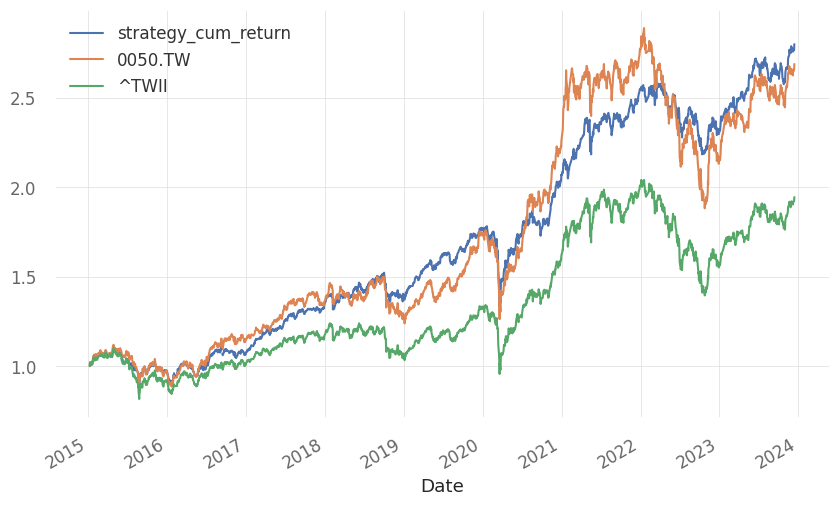

In [ ]:
# Get historical returns for the market indices: Taiwan 50 (^TWII) and ETF 0050.TW
market = get_return(['^TWII', "0050.TW"], pd_weight.index[0], pd_weight.index[-1])

# Print the returns of the market indices
print(market)

# Calculate and print the Sharpe ratio of the market
sharpe_ratio_market = empyrical.sharpe_ratio(market)
print(sharpe_ratio_market)

# Calculate the cumulative returns for the market indices
market.iloc[:] = (1 + market.iloc[:]).cumprod(axis=0)

# Merge the cumulative return of the strategy with the market returns based on the "Date" column
market = pd.merge(result, market, on="Date", how="right")

# Plot the cumulative return of the strategy along with the market indices
market.plot(y=["strategy_cum_return", '0050.TW', "^TWII"])


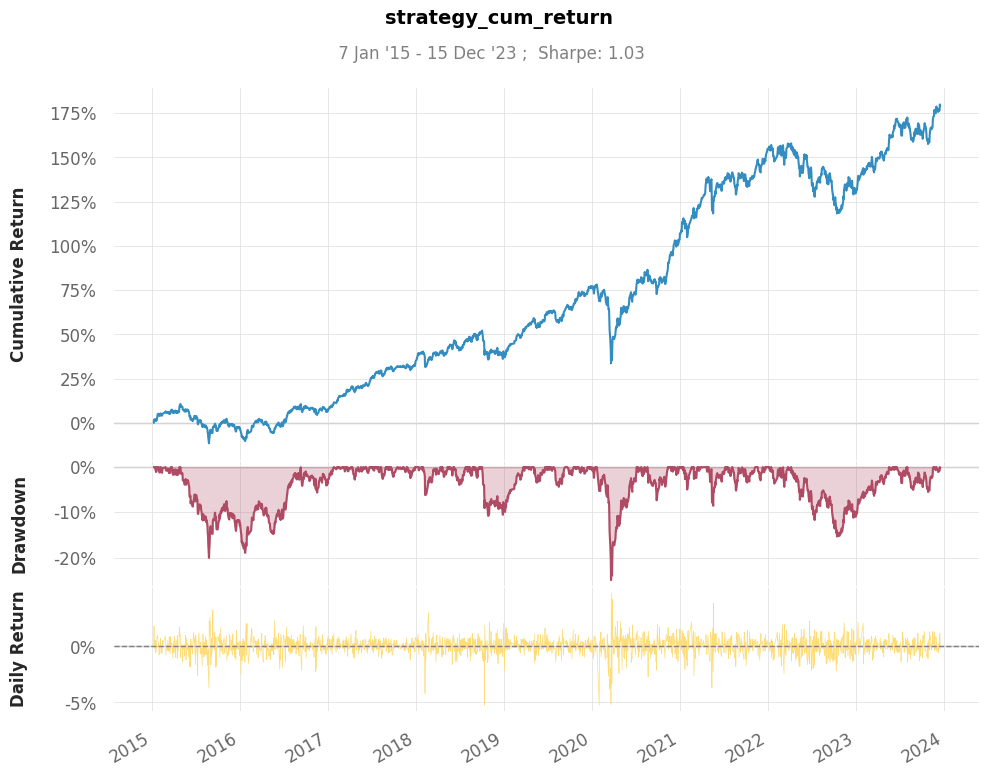

In [ ]:
qs.extend_pandas()
qs.plots.snapshot(result.strategy_cum_return.pct_change(), title='strategy_cum_return', show=True)


In [ ]:
aa = get_return(['^TWII', "0050.TW"], result.index[0], result.index[-1])
qs.reports.html(result.strategy_cum_return, aa["0050.TW"],output="output.html")
# qs.reports.html(aa["0050.TW"], "^TWII",output="output_hand1.html")


[*********************100%%**********************]  2 of 2 completed


In [ ]:
help(qs.plots.snapshot)


Help on function snapshot in module quantstats._plotting.wrappers:

snapshot(returns, grayscale=False, figsize=(10, 8), title='Portfolio Summary', fontname='Arial', lw=1.5, mode='comp', subtitle=True, savefig=None, show=True, log_scale=False, **kwargs)



## Equal risk portfolio with constraints

Set C=
$
\begin{pmatrix}
1 & 0 & \cdots & 0 \\\
0 & 1 & \cdots & 0 \\\
\vdots & \vdots & \vdots & \vdots \\\
0 & 0 & \cdots & 1
\end{pmatrix}
$,
D =
$
\begin{pmatrix}
0.1  \\\
0.1 \\\
\vdots \\\
0.1
\end{pmatrix}
$
s.t. $Cw\le D$

\\

That's, all assets have an upper limit of 0.1.

1. The strategy cumulative return

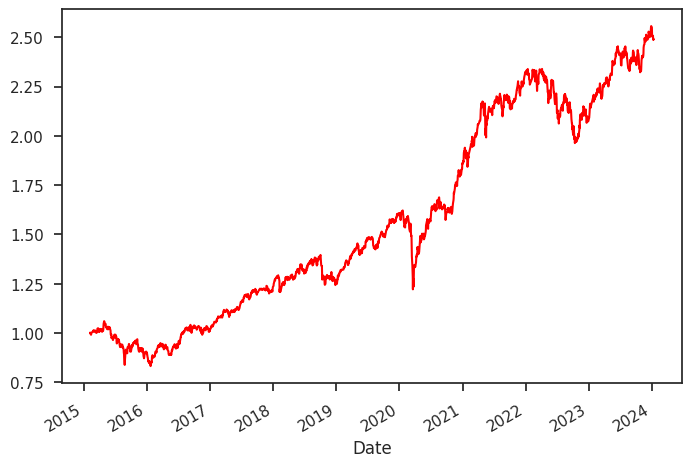

2. The weight evolution over time

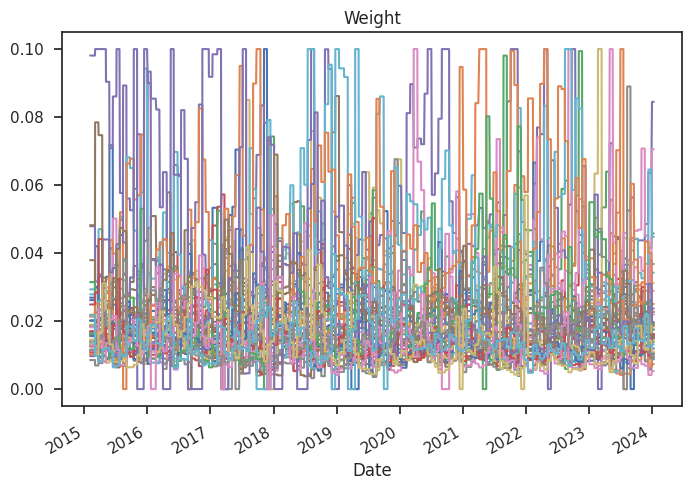


- The annualized Sharpe ratio \\
  1.0244498674935747
- Sharpe ratio \\
  1.0244498674935747


In [ ]:
def day_weight_start_end_SCRIP_2(returns_train_pass, n, mu, cov, interval=7, cov_days=30):
    """
    Calculates daily weights using the SCRIP for the training data.

    Parameters:
    - returns_train_pass: DataFrame, historical returns of stocks for training.
    - n: int, number of stocks.
    - cov: list, covariance matrices.
    - interval: int, interval for selecting data.
    - cov_days: int, number of days for covariance calculation.

    Returns:
    Tuple containing DataFrame with pass days and list of strategy weights.
    """
    pass_day = 0
    strategy_weight = []
    x0 = np.ones([n, 1])/n
    cov_index = 0
    # Get C, D s.t. w_i<=0.1
    C=np.eye(n)
    D=np.ones([n,1]) /10
    for i in range(len(returns_train_pass) - 1, -1, -1):
        if pass_day % interval == 0:

            x_SCRIP = SCRIP(n, mu[cov_index].values.reshape([n, 1]), cov[cov_index].values, C=C, D=D, c=0, lambda_=0, b=np.array([]), max_err=1e-6, times=100)
            strategy_weight.append(x_SCRIP[-1].reshape([n]))

            cov_index += 1
        else:
            strategy_weight.append(strategy_weight[-1])
        pass_day += 1
    return returns_train_pass, strategy_weight

[*********************100%%**********************]  50 of 50 completed
<ipython-input-19-cebb2f02bc28>:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns_test["pass_day"] = {}


Text(0.5, 1.0, 'Weight')

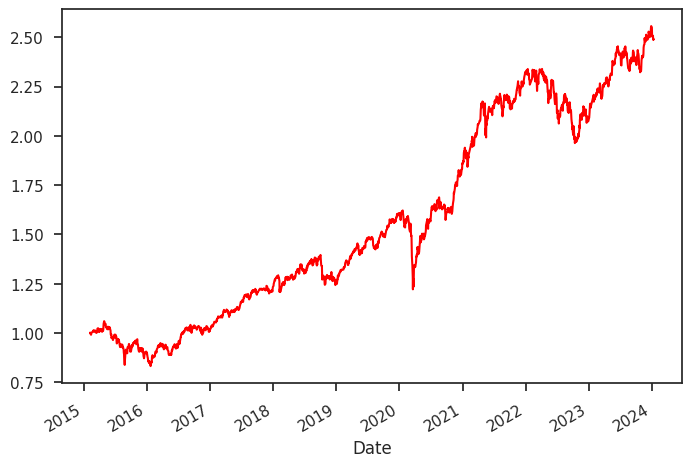

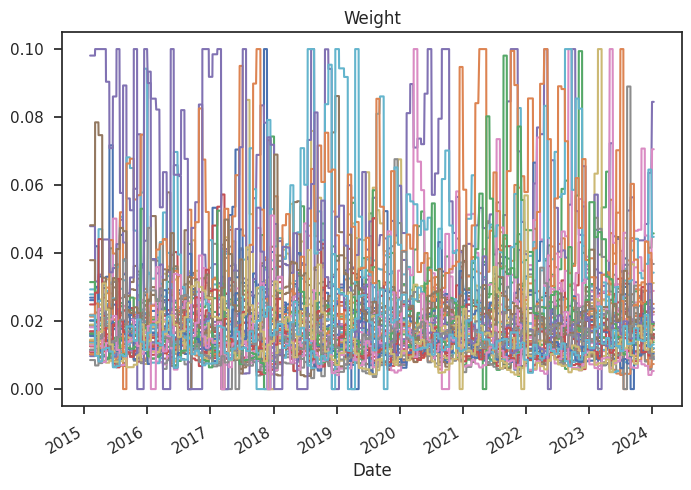

In [ ]:
# List of stock symbols
stoke = ['1101.TW', '1102.TW', '1216.TW', '1301.TW', '1303.TW', '1326.TW', '1402.TW', '1590.TW', '1722.TW', '2002.TW', '2105.TW', '2207.TW', '2303.TW', '2308.TW', '2317.TW', '2327.TW', '2330.TW', '2344.TW', '2357.TW', '2376.TW', '2379.TW', '2382.TW', '2395.TW', '2408.TW', '2412.TW', '2454.TW', '2474.TW', '2801.TW', '2881.TW', '2882.TW', '2884.TW', '2885.TW', '2886.TW', '2887.TW', '2891.TW', '2892.TW', '2912.TW', '3008.TW', '3034.TW', '3045.TW', '3711.TW', '4904.TW', '4938.TW', '5871.TW', '5876.TW', '5880.TW', '6415.TW', '6505.TW', '8046.TW', '9910.TW']
stoke.sort()

# Set parameters
interval = 14
cov_days = 30

# Get historical returns for the selected stocks
d = date.today()
returns_ALL = get_return(stoke, d - timedelta(days=365 * 9 + cov_days), d)

# Drop missing values in the returns
returns_ALL.dropna(inplace=True)

# Get the number of stocks
n = len(returns_ALL.columns)

# Calculate covariance matrices
mu = list_mu(returns_ALL, n, interval, cov_days)
cov = list_cov(returns_ALL, n, interval, cov_days)

# Retrieve the days that have passed for returns_ALL_pass data
returns_ALL_pass = returns_ALL.copy()
returns_ALL_pass = retrieve_pass_day(returns_ALL_pass, n, cov_days)

# Calculate day weights and perform backtesting
day, weight = day_weight_start_end_SCRIP_2(returns_ALL_pass, b, n, mu, cov, interval, cov_days)
result = backtestingt_start_end(day, weight, n)
# Plot the strategy cumulative return
result_plot = result.strategy_cum_return.plot(color='red')
# Plot the weight evolution over time
pd_weight = pd.DataFrame(weight, columns=returns_ALL_pass.columns, index=day.index)
weight_plt = pd_weight.plot()
weight_plt.legend_ = None
weight_plt.set_title("Weight")


<ipython-input-20-2db2001ab1c0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


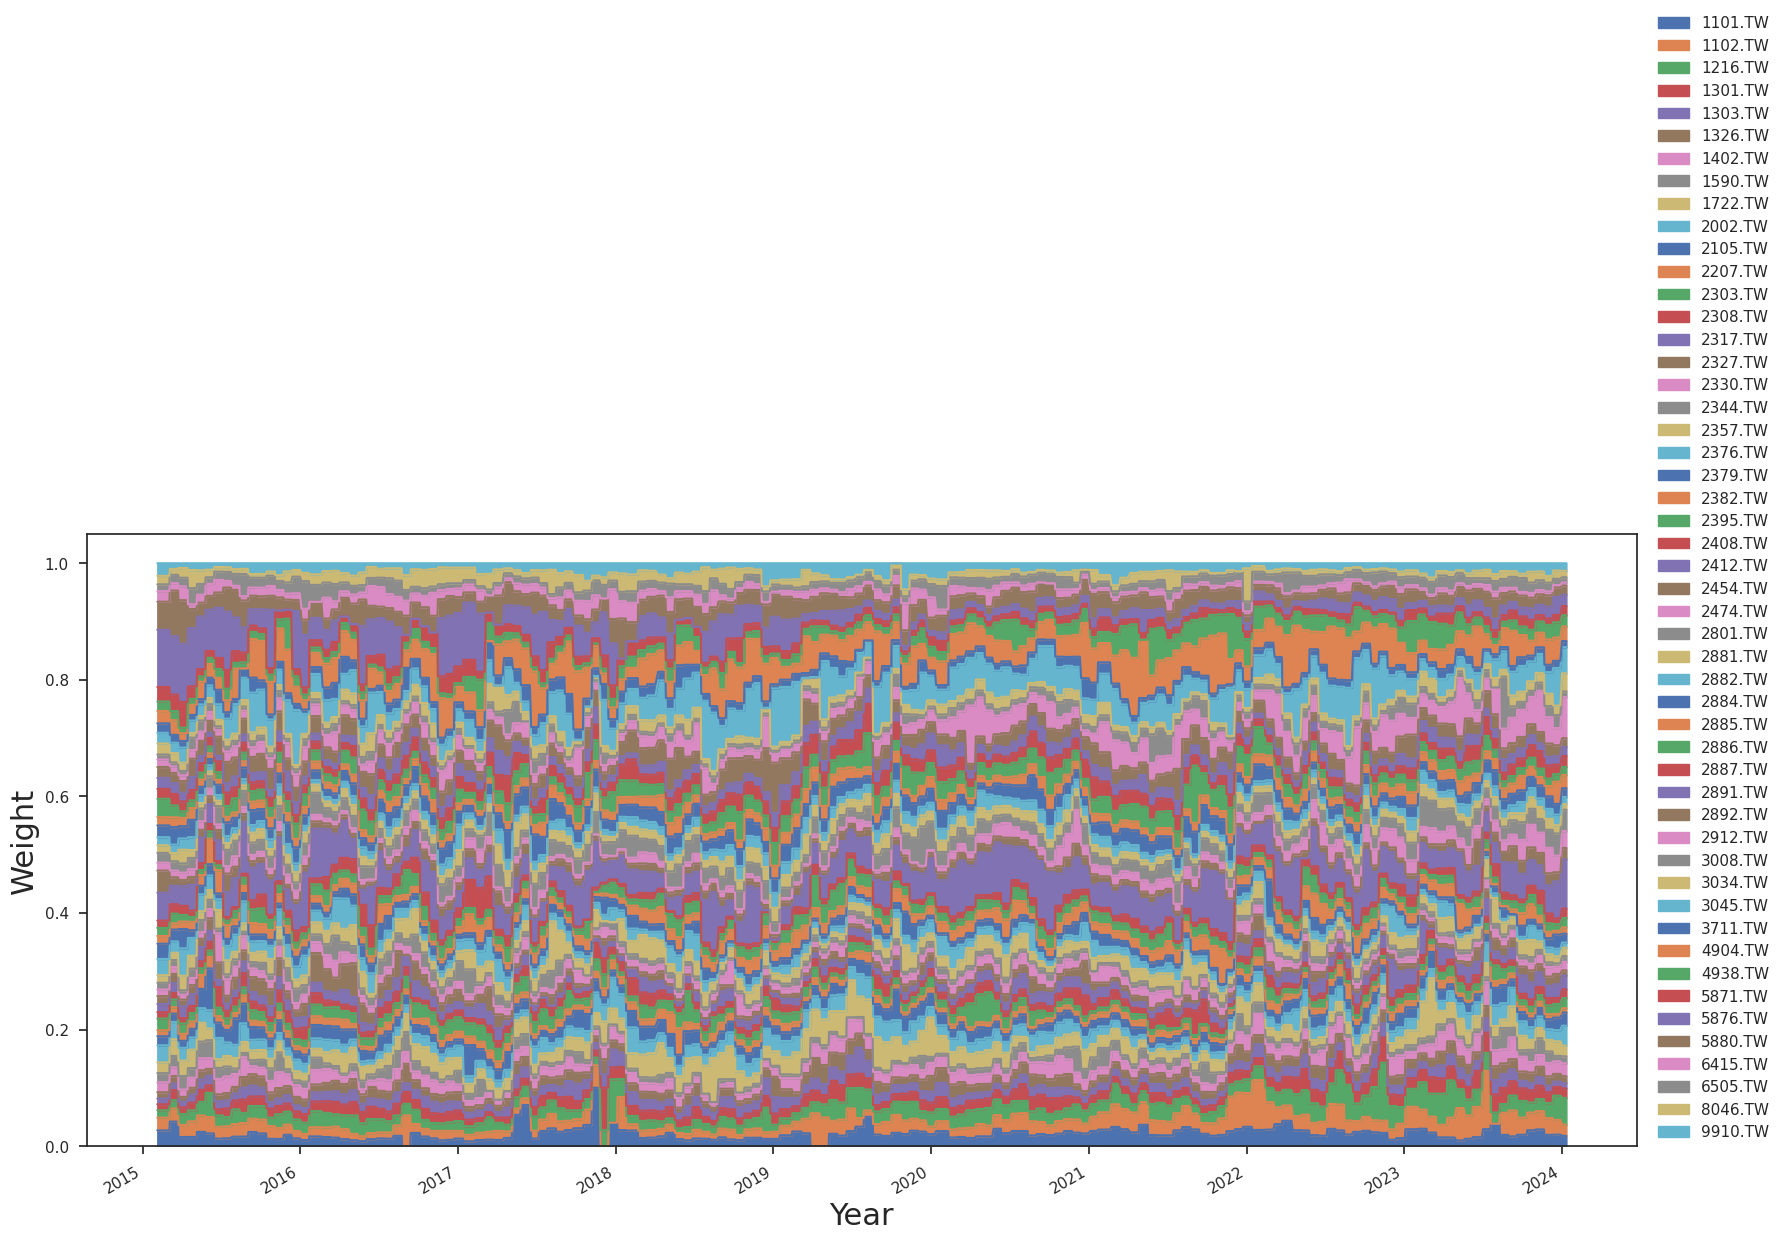

In [ ]:
plt.style.use('seaborn')
sns.set_style("white")
sns.set_theme(style = "ticks")

pd_weight.plot.area(figsize = (20,9))
plt.ylabel("Weight", fontsize = 22)
plt.xlabel("Year", fontsize = 22)
plt.legend(bbox_to_anchor=(1.01,0),loc=3,borderaxespad=0)


In [ ]:
print_SR_sr(result)

1.0244498674935747 1.0244498674935747


#References

- [A Signal Processing Perspective on Financial Engineering](https://palomar.home.ece.ust.hk/papers/2016/Feng&Palomar-FnT2016.pdf)
- [SCRIP: Successive Convex Optimization Methods for Risk Parity Portfolio Design](https://www.semanticscholar.org/paper/SCRIP%3A-Successive-Convex-Optimization-Methods-for-Feng-Palomar/6080f7f7dbde982d90535c3fc87fbcff28eae235)
- Introduction to Risk Parity and Budgeting (Chapman and Hall/CRC Financial Mathematics Series) by Thierry Roncalli
- [Risk Parity Portfolio by Prof. Daniel P. Palomar](https://palomar.home.ece.ust.hk/ELEC5470_lectures/slides_risk_parity_portfolio.pdf)
- [Risk-Based Indexation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1582998)
- [Constrained Risk Budgeting Portfolios Theory, Algorithms, Applications & Puzzles](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3331184)